In [1]:
import wfdb
import os
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import FastICA
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML
# from google.colab import files
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.svm import SVC
import itertools
import warnings
np.warnings = warnings

# ここから

In [2]:
# ガウス関数定義
def gaussian_2d(coord, A, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coord #coord[:, 0], coord[:, 1]
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    return A * np.exp(-(a*(x - x0)**2 + 2*b*(x - x0)*(y - y0) + c*(y - y0)**2)) + offset

In [3]:
def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal, axis=0)), axis=0)

def ptp(signal):
    return np.ptp(signal, axis=0)

def arv(signal):
    return np.mean(np.abs(signal), axis=0)

def rms(signal):
    return np.sqrt(np.mean(signal**2, axis=0))

def zc(signal):
    s = np.sign(signal)
    s_prev = s[:-1]
    s_next = s[1:]
    sign_change = (s_prev * s_next) < 0
    return np.sum(sign_change, axis=0)

In [4]:
def get_centers_directions(emg_data, curve, feature_func, fs=2000, window_ms=25, threshold=0):
  # ---------- パラメータ設定 ----------
  emg_data = emg_data  # shape: (n_samples, n_channels)
  curve = curve  # 近似曲面
  feature_func = feature_func  # 特徴量抽出関数
  fs = fs  # サンプリング周波数
  window_ms = window_ms    # ウィンドウ幅 [ms]
  window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
  threshold = threshold   # featureの最大 - 平均がこの値以上なら採用
  half_win = window_size // 2

  # ---------- EMG信号（例：num_samples × 64） ----------
  # num_samples = 5000
  emg_data = emg_data

  # ---------- 出力先 ----------
  valid_indices = []

  # ---------- 64チャネルすべてに対してピーク検出 ----------
  peak_mask = np.zeros(emg_data.shape[0], dtype=bool)

  for ch in range(64):
      rms_signal = np.sqrt(emg_data[:,ch]**2)
      peaks, _ = find_peaks(rms_signal, distance=50,
                        height=np.mean(rms_signal) + np.std(rms_signal))
      # peaks, _ = find_peaks(emg_data[:, ch], distance=window_size//2, height=np.std(emg_data[:,ch]) * 1)
      peak_mask[peaks] = True  # どこか1チャネルでもピークがあればTrue

  # ---------- 全体でのピーク位置で条件を評価 ----------
  for t in np.where(peak_mask)[0]:
      if t - half_win < 0 or t + half_win >= emg_data.shape[0]:
          continue  # ウィンドウが境界を超えるならスキップ

      snippet = emg_data[t - half_win : t + half_win, :]  # shape: [window_size, 64]
      feature_per_ch = feature_func(snippet)  # 各チャネルのfeature
      feature_mean = np.mean(feature_per_ch)
      feature_max = np.max(feature_per_ch)

      if feature_max - feature_mean >= threshold:
          valid_indices.append(t)

  print(f"検出されたピーク数（条件を満たすもの）: {len(valid_indices)}")

  # ----- MUAP波形の切り出し -----
  snippets = []
  valid_peaks = []
  for peak in valid_indices:
      if peak - window_size//2 >= 0 and peak + window_size//2 < emg_data.shape[0]:
          snippet = emg_data[peak - window_size//2 : peak + window_size//2, :]
          snippets.append(snippet)
          valid_peaks.append(peak)

  snippets = np.array(snippets)
  valid_peaks = np.array(valid_peaks)


  # ガウス関数定義
  def gaussian_2d(coord, A, x0, y0, sigma_x, sigma_y, theta, offset):
      x, y = coord #coord[:, 0], coord[:, 1]
      a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
      b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
      c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
      return A * np.exp(-(a*(x - x0)**2 + 2*b*(x - x0)*(y - y0) + c*(y - y0)**2)) + offset

  # 座標グリッド
  x = np.arange(8)
  y = np.arange(8)
  xv, yv = np.meshgrid(x, y)
  coords = np.vstack((xv.ravel(), yv.ravel()))



  centers = []
  directions = []
  theta_1s = []
  features = []
  for snippet in snippets[:]:
    segment = snippet
    #ピーク間振幅
    feature = feature_func(segment) #shape:(64,)
    map_2d = feature.reshape(8, 8)

    # フィッティング
    max_index = np.unravel_index(np.argmax(map_2d), map_2d.shape)
    initial = [np.max(feature)-np.min(feature), max_index[0], max_index[1], 1, 1, 0, np.min(feature)]
    bounds = ([0, 0, 0, 0.1, 0.1, -np.pi/2, -np.inf],
            [np.inf, 7, 7, 5, 5, np.pi/2, np.inf])
    popt, _ = curve_fit(curve, coords, feature, p0=initial, bounds=bounds, maxfev=10000)
    A, x0, y0, sigma_x, sigma_y, theta, offset = popt #パラメータ取得
    center = (x0, y0)
    if sigma_x > sigma_y:
        theta_1 = theta
        # print('σx > σy')
    else:
      if theta >= 0:
        theta_1 = theta - np.pi/2
      else:
        theta_1 = theta + np.pi/2
      # print('σy >= σx')
    direction = (np.cos(theta_1), np.sin(theta_1))

    centers.append(center)
    directions.append(direction)
    theta_1s.append(np.degrees(theta_1))

    feature = []
    feature.append(center[0])
    feature.append(center[1])
    feature.append(np.degrees(theta_1))
    features.append(feature)

  # print(centers)
  # print(directions)
  # print(theta_1s)
  # print(f'all centers:: ave:{np.mean(centers, axis=0)}, std:{np.std(centers, axis=0)}')
  # print(f'all theta_1:: ave:{np.mean(theta_1s, axis=0)}, std:{np.std(theta_1s, axis=0)}')

  return features

In [5]:
def clustering(features, k1=4, k2=3):
    # 1. 特徴ベクトルを構築
    features = np.array(features)
    results_df = pd.DataFrame(data=features, columns=['center_x', 'center_y', 'theta_deg'])

    # --- 第1段階：中心座標でクラスタリング ---
    # 特徴量：center_x, center_y
    center_features = results_df[['center_x', 'center_y']].dropna()
    k1 = k1  # 中心クラスタ数（例）
    kmeans1 = KMeans(n_clusters=k1, random_state=0)
    center_labels = kmeans1.fit_predict(center_features)

    # 結果に追加
    results_df['center_cluster'] = -1
    results_df.loc[center_features.index, 'center_cluster'] = center_labels

    # # --- 第2段階：方向角でクラスタリング（各中心クラスタ内で） ---
    # # θの周期性を考慮 → sinθ, cosθでクラスタリング
    # results_df['theta_sin'] = np.sin(results_df['theta_rad'])
    # results_df['theta_cos'] = np.cos(results_df['theta_rad'])

    direction_cluster_labels = np.full(len(results_df), -1)  # 初期化

    k2 = k2  # 各中心クラスタ内の方向クラスタ数（例）

    for group_id in range(k1):
        group_df = results_df[results_df['center_cluster'] == group_id]
        idx = group_df.index
        if len(group_df) >= k2:  # クラスタ数以上あるか確認
            dir_features = group_df[['theta_deg']].values
            kmeans2 = KMeans(n_clusters=k2, random_state=0)  # 固定乱数
            sub_labels = kmeans2.fit_predict(dir_features)
            direction_cluster_labels[idx] = sub_labels + group_id * 10  # 固有ラベル化

    # 結果に追加
    results_df['direction_cluster'] = direction_cluster_labels


    # クラスタごとに平均・標準偏差を集計
    cluster_stats = results_df.groupby('direction_cluster').agg({
        'center_x': ['mean', 'std'],
        'center_y': ['mean', 'std'],
        'theta_deg': ['mean', 'std'],
        'direction_cluster': 'count'
    })

    # 結果をまとめ直す
    summary_df = pd.DataFrame({
        'cluster': cluster_stats.index,
        'center_x_mean': cluster_stats[('center_x', 'mean')],
        'center_x_std': cluster_stats[('center_x', 'std')],
        'center_y_mean': cluster_stats[('center_y', 'mean')],
        'center_y_std': cluster_stats[('center_y', 'std')],
        'theta_deg_mean': cluster_stats[('theta_deg', 'mean')],
        'theta_deg_std': cluster_stats[('theta_deg', 'std')],
        # 'count': results_df['cluster'].value_counts().sort_index(),
        'count': cluster_stats[('direction_cluster', 'count')]
    }).reset_index(drop=True)

    # 結果表示
    summary_df

    return results_df, summary_df

In [6]:
def get_cluster_colors(n_clusters, cmap_name='tab20'):
    cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.
    return [cmap(i) for i in range(n_clusters)]

In [7]:
def plot_fiber(results_df, arrow_scale=0.5):
  arrow_scale = arrow_scale

  n_clusters = results_df['direction_cluster'].nunique()
  cluster_colors = get_cluster_colors(n_clusters)

  # プロット準備
  plt.figure(figsize=(7, 6))
  for n, center_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == center_cluster]
    color = cluster_colors[n]

    for _, row in sub_df.iterrows():
          x, y = row['center_x'], row['center_y']
          theta = row['theta_deg']
          dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale

          # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
          plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
          plt.plot(x, y, 'o', color=color,
                  label=f"Center Cl {center_cluster}" if f"Center Cl {center_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")

  # ラベル・軸
  plt.xlabel("center_x")
  plt.ylabel("center_y")
  plt.title("2-Stage Clustering of Muscle Fiber Direction")
  plt.grid(True)
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.axis('equal')
  plt.tight_layout()
  plt.xlim(0, 7)
  plt.ylim(0, 7)
  plt.show()

In [8]:
def get_virtual_bipolars(results_df, ied=2, arrow_scale=0.5):
  #仮想双極電極の電極間距離（cm）
  a = ied

#   n_clusters = results_df['direction_cluster'].nunique()
#   cluster_colors = get_cluster_colors(n_clusters)

  virtual_bipolars = []
  labels = []
  center_direction = []
  n_virtual_bipolars_checker = []
  for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
    # if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
    x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
    theta = sub_df['theta_deg'].mean()
    #dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale
    # print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
    x1 = x - a/2*np.cos(np.radians(theta))
    y1 = y - a/2*np.sin(np.radians(theta))
    x2 = x + a/2*np.cos(np.radians(theta))
    y2 = y + a/2*np.sin(np.radians(theta))
    virtual_bipolars.append([x1, y1, x2, y2])
    labels.append(direction_cluster)
    center_direction.append([x, y, theta])
    n_virtual_bipolars_checker.append(True)
  # if len(n_virtual_bipolars_checker) == 1:
  #   virtual_bipolars.append([0,0,0,0])
  #   labels.append(999)
  #   center_direction.append([0,0,0])

  return virtual_bipolars, labels, center_direction, len(n_virtual_bipolars_checker)

In [9]:
def extract_rms_features(windows):
    """
    各ウィンドウからチャネルごとのRMS特徴量を抽出
    入力: shape = (window_size, n_channels)
    出力: shape = (n_channels)
    """
    return np.sqrt(np.mean(np.square(windows), axis=0))

In [10]:
def get_virtual_emg(emg_data, virtual_bipolars):
  # --- データ読み込み ---
  emg_data = emg_data

  # === スライディングウィンドウ抽出 ===
  n_samples = emg_data.shape[0]
  segments = []
  time_stamps = []

  # 座標グリッド
  x = np.arange(8)
  y = np.arange(8)
  xv, yv = np.meshgrid(x, y)
  coords = np.vstack((xv.ravel(), yv.ravel()))
  # # パラメータ計算
  # f = RectBivariateSpline(x, y, map_2d)

  virtual_emg = []
  for i in range(n_samples):
    f = RectBivariateSpline(x, y, emg_data[i].reshape(8,8))
    z_list = []
    for bipolar in virtual_bipolars:
      x1=bipolar[0]
      y1=bipolar[1]
      x2=bipolar[2]
      y2=bipolar[3]
      z1 = f(x1, y1)
      z2 = f(x2, y2)
      z_diff = z1 - z2
      z_list.append(z_diff)
    virtual_emg.append(np.array(z_list).reshape(-1))
  virtual_emg = np.array(virtual_emg)

  # print(emg_data.shape)
  # print(virtual_emg.shape)

  return virtual_emg

In [11]:
def get_features(virtual_emg, labels, fs=2000, window_ms=50, stride_ms=20):
  # --- データ読み込み例（ここではダミーデータ） ---
  fs = fs  # サンプリング周波数
  window_ms = window_ms    # ウィンドウ幅 [ms]
  stride_ms = stride_ms    # スライド幅 [ms]
  window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
  stride_size = int(fs * stride_ms / 1000)  # スライド数
  n_samples = virtual_emg.shape[0]
  X = []
  y = []
  for start in range(0, n_samples - window_size + 1, stride_size):
      end = start + window_size
      window_emg = virtual_emg[start:end, :]
      #特徴量抽出
      rms = extract_rms_features(window_emg) # shape: (virtual_bipolar_channels,)
      X.append(rms)
      y.append(labels)
  return X, y

In [12]:
#分類器
def SVC_classifier(X_session1, y_session1, X_session2, y_session2):

    X_train = np.array(X_session1).reshape(-1,1)
    y_train = np.array(y_session1).reshape(-1,1)
    X_test = np.array(X_session2).reshape(-1,1)
    y_test = np.array(y_session2).reshape(-1,1)

    # データ分割
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # SVMモデル学習
    model = SVC(kernel='rbf', probability=True, random_state=0)
    model.fit(X_train, y_train)

    prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
    # === 各テストラベルごとに学習クラスへの平均確率を出力 ===
    class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

    result = []

    for test_label in np.unique(y_test):
        idx = y_test.reshape(-1) == test_label
        mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
        result.append([test_label] + list(mean_prob))

    # # === 表形式で表示 ===
    # columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
    # df_result = pd.DataFrame(result, columns=columns)
    # print(df_result)
    
    return result, y_train, y_test

In [13]:
def calc_diff(train_idx, test_idx, center_direction_session1, center_direction_session2):
    center_direction_session1 = center_direction_session1
    center_direction_session2 = center_direction_session2
    #計算
    center_x_train = np.array(center_direction_session1)[train_idx, 0]
    center_y_train = np.array(center_direction_session1)[train_idx, 1]
    theta_train = np.array(center_direction_session1)[train_idx, 2]
    center_x_test = np.array(center_direction_session2)[test_idx, 0]
    center_y_test = np.array(center_direction_session2)[test_idx, 1]
    theta_test = np.array(center_direction_session2)[test_idx, 2]
    center_x_diff = center_x_train - center_x_test
    center_y_diff = center_y_train - center_y_test
    theta_diff = theta_train - theta_test
    return center_x_diff, center_y_diff, theta_diff

In [14]:
def diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2):
  max_train_idx = []
  for i in range(np.array(result).shape[0]):
    j = np.argmax(np.array(result)[i,1:])
    max_train_idx.append(j)
  # print(max_train_idx)
  diff =[]
  for k in set(max_train_idx):
    if max_train_idx.count(k) >=2:
      idx = max_train_idx == k
      l = np.argmax(np.array(result)[idx, k+1], axis=0)
      max_test_idx = [i for i, j in enumerate(idx) if j == True]
      # print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_test_idx[l]], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})
    else:
      # print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_train_idx.index(k)], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})

  return diff

# 分析

## 各sessionで得られたvpolarの位置

In [15]:
n_subjects = 5 #20
n_sessions = 2

vpolars = []
for i in range(n_subjects):
    for j in range(n_sessions):
        lines = []
        gestures= open('pr_dataset/subject{:02}'.format(i+1) + '_session' + str(j+1) + '/label_maintenance.txt', 'r')
        line = gestures.read()
        for l in line.split(','):
            lines.append(l.strip())
        gestures.close()
        gesture = 0
        for k, line in enumerate(lines):
            if gesture == line:
                trial = 2
            else:
                trial = 1
            gesture = line
            record_name = 'pr_dataset/subject{:02}'.format(i+1) + '_session' + str(j+1) + '/maintenance_preprocess_sample'+str(k+1)
            # lists.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1})
            print(record_name) # ファイル名
            try:
                record = wfdb.rdrecord(record_name)

                filtered_emg_ED = record.p_signal[:,:64] #Extensor Distal
                filtered_emg_EP = record.p_signal[:,64:128] #Extensor Proximal
                filtered_emg_FD = record.p_signal[:,128:192] #Flexor Distal
                filtered_emg_FP = record.p_signal[:,192:256] #Flexor Proximal

                electrode_places = [[filtered_emg_ED, 'ED'],
                                    [filtered_emg_EP, 'EP'],
                                    [filtered_emg_FD, 'FD'],
                                    [filtered_emg_FP, 'FP']]

                for electrode_place in electrode_places:
                    print(electrode_place[1]) #電極位置
                    
                    try:
                        emg_data = electrode_place[0]
                        features = get_centers_directions(emg_data, gaussian_2d, ptp, window_ms=25, threshold=0)
                        results_df, summary_df = clustering(features)
                        virtual_bipolars, labels, center_direction, n_virtual_bipolars = get_virtual_bipolars(results_df)
                        vpolars.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1, 'electrode_place':electrode_place[1], 'emg_data': emg_data, 'virtual_bipolars': virtual_bipolars, 'labels': labels, 'center_direction': center_direction, 'n_virtual_bipolars': n_virtual_bipolars})
                    except RuntimeError:
                        vpolars.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1, 'electrode_place':electrode_place[1], 'emg_data': [], 'virtual_bipolars': [], 'labels': [], 'center_direction': [], 'n_virtual_bipolars': 0})
            except FileNotFoundError:
                pass

pr_dataset/subject01_session1/maintenance_preprocess_sample1
ED
検出されたピーク数（条件を満たすもの）: 645
EP
検出されたピーク数（条件を満たすもの）: 452
FD
検出されたピーク数（条件を満たすもの）: 912
FP
検出されたピーク数（条件を満たすもの）: 520
pr_dataset/subject01_session1/maintenance_preprocess_sample2
ED
検出されたピーク数（条件を満たすもの）: 683
EP
検出されたピーク数（条件を満たすもの）: 478
FD
検出されたピーク数（条件を満たすもの）: 953
FP
検出されたピーク数（条件を満たすもの）: 589
pr_dataset/subject01_session1/maintenance_preprocess_sample3
ED
検出されたピーク数（条件を満たすもの）: 893
EP
検出されたピーク数（条件を満たすもの）: 515
FD
検出されたピーク数（条件を満たすもの）: 968
FP
検出されたピーク数（条件を満たすもの）: 827
pr_dataset/subject01_session1/maintenance_preprocess_sample4
ED
検出されたピーク数（条件を満たすもの）: 877
EP
検出されたピーク数（条件を満たすもの）: 743
FD
検出されたピーク数（条件を満たすもの）: 722
FP
検出されたピーク数（条件を満たすもの）: 893
pr_dataset/subject01_session1/maintenance_preprocess_sample5
ED
検出されたピーク数（条件を満たすもの）: 1088
EP
検出されたピーク数（条件を満たすもの）: 1234
FD
検出されたピーク数（条件を満たすもの）: 1704
FP
検出されたピーク数（条件を満たすもの）: 1307
pr_dataset/subject01_session1/maintenance_preprocess_sample6
ED
検出されたピーク数（条件を満たすもの）: 1158
EP
検出されたピーク数（条件を満たすもの）: 1170
FD
検出されたピーク数

In [ ]:
vpolars

NameError: name 'vpolars' is not defined

: 

In [ ]:
distances = []
for list_session1 in vpolars:
    for list_session2 in vpolars:
        if list_session1['subject'] == list_session2['subject'] and list_session1['session'] == 1 and list_session2['session'] == 2 and list_session1['gesture'] == list_session2['gesture'] and list_session1['trial'] == list_session2['trial'] and list_session1['electrode_place'] == list_session2['electrode_place']:
            print(f'file_name: {list_session1["file_name"]}, gesture: {list_session1["gesture"]}, trial: {list_session1["trial"]}, subject: {list_session1["subject"]}, session: {list_session1["session"]}')
            print(f'file_name: {list_session2["file_name"]}, gesture: {list_session2["gesture"]}, trial: {list_session2["trial"]}, subject: {list_session2["subject"]}, session: {list_session2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_session1['n_virtual_bipolars'] > 0 and list_session2['n_virtual_bipolars'] > 0:
                for i in range(len(list_session1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_session2['center_direction'])):
                        x_distance[i].append(list_session2['center_direction'][j][0] - list_session1['center_direction'][i][0])
                        y_distance[i].append(list_session2['center_direction'][j][1] - list_session1['center_direction'][i][1])
                        theta_distance[i].append(list_session2['center_direction'][j][2] - list_session1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_session1['labels'][i],
                        'session2_cluster': list_session2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_session1['subject']}, gesture={list_session1['gesture']}, trial={list_session1['trial']}, electrode_place={list_session1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_session1['labels'][i]}, session2_cluster={list_session2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances.append({'subject': list_session1['subject'], 'gesture': list_session1['gesture'], 'trial': list_session1['trial'], 'electrode_place': list_session1['electrode_place'], 'result_distance': result_distance})
            

file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2
j=11,x_distance[0]: [-6.072140049649136, -5.959167081798536, -6.528546043956742, -0.016132578555978938, -0.22293570481850455, 0.2589829382643005, -0.6355043368060231, -1.7616270566401457, -1.3139776462956618, -3.8259491881339103, -3.6032277980341427, -4.0124245777301795], y_distance[0]: [-2.062845982084796, -1.8416851144269288, 0.07981326565340208, 1.7682881034253137, 1.6100335125092622, 1.354478111486098, -0.2968244295037339, -0.4469915498896686, 0.3827801444068246, -3.593425777750928, -2.7089865844876133, -3.3977785710989132], theta_distance[0]: [-121.01797723039834, -33.9333949496416, -80.69916826013052, -153.84695957319568, -13.909706118873089, -130.54816609821006, -126.80880311567324, 8.493755675951192, -156.46207236432986, -132.32900987559782, 9.33

In [ ]:
distances

[]

## 各subjectでの分析

In [ ]:
n_sessions_list = []
for distance in distances:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [ ]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

In [ ]:
ED_xy_list = {}
EP_xy_list = {}
FD_xy_list = {}
FP_xy_list = {}
for subject in subjects:
    ED_xy_list[subject] = []
    EP_xy_list[subject] = []
    FD_xy_list[subject] = []
    FP_xy_list[subject] = []
    for i in range(n_gestures):
        # ED
        ED_xy_list[subject].append(x_ED_gesture[subject][i+1])
        ED_xy_list[subject].append(y_ED_gesture[subject][i+1])
        # EP
        EP_xy_list[subject].append(x_EP_gesture[subject][i+1])
        EP_xy_list[subject].append(y_EP_gesture[subject][i+1])
        # FD
        FD_xy_list[subject].append(x_FD_gesture[subject][i+1])
        FD_xy_list[subject].append(y_FD_gesture[subject][i+1])
        # FP
        FP_xy_list[subject].append(x_FP_gesture[subject][i+1])
        FP_xy_list[subject].append(y_FP_gesture[subject][i+1])

ED_theta_list = {}
EP_theta_list = {}
FD_theta_list = {}
FP_theta_list = {}
for subject in subjects:
    ED_theta_list[subject] = []
    EP_theta_list[subject] = []
    FD_theta_list[subject] = []
    FP_theta_list[subject] = []
    for i in range(n_gestures):
        # ED
        ED_theta_list[subject].append(theta_ED_gesture[subject][i+1])
        # EP
        EP_theta_list[subject].append(theta_EP_gesture[subject][i+1])
        # FD
        FD_theta_list[subject].append(theta_FD_gesture[subject][i+1])
        # FP
        FP_theta_list[subject].append(theta_FP_gesture[subject][i+1])

In [ ]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    ax.boxplot(ED_xy_list[subject])
    ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
    plt.title('Subject'+str(subject)+' ED x&y diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-6, 7, 1))
    plt.show()

    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    bp = ax.boxplot(ED_theta_list[subject])
    ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
    plt.title('Subject'+str(subject)+' ED θ diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-150, 151, 10))
    plt.show()

### 各subjectでの全ジェスチャーの平均値

In [ ]:
x_ED_gesture_mean = {}
y_ED_gesture_mean = {}
theta_ED_gesture_mean = {}
x_EP_gesture_mean = {}
y_EP_gesture_mean = {}
theta_EP_gesture_mean = {}
x_FD_gesture_mean = {}
y_FD_gesture_mean = {}
theta_FD_gesture_mean = {}
x_FP_gesture_mean = {}
y_FP_gesture_mean = {}
theta_FP_gesture_mean = {}
for subject in subjects:
    x_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_ED_gesture_mean[subject]['value'].append(x_ED_gesture[subject][i+1][l])
            y_ED_gesture_mean[subject]['value'].append(y_ED_gesture[subject][i+1][l])
            theta_ED_gesture_mean[subject]['value'].append(theta_ED_gesture[subject][i+1][l])
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_EP_gesture_mean[subject]['value'].append(x_EP_gesture[subject][i+1][l])
            y_EP_gesture_mean[subject]['value'].append(y_EP_gesture[subject][i+1][l])
            theta_EP_gesture_mean[subject]['value'].append(theta_EP_gesture[subject][i+1][l])
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_FD_gesture_mean[subject]['value'].append(x_FD_gesture[subject][i+1][l])
            y_FD_gesture_mean[subject]['value'].append(y_FD_gesture[subject][i+1][l])
            theta_FD_gesture_mean[subject]['value'].append(theta_FD_gesture[subject][i+1][l])
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_FP_gesture_mean[subject]['value'].append(x_FP_gesture[subject][i+1][l])
            y_FP_gesture_mean[subject]['value'].append(y_FP_gesture[subject][i+1][l])
            theta_FP_gesture_mean[subject]['value'].append(theta_FP_gesture[subject][i+1][l])
    x_ED_gesture_mean[subject]['mean'] = np.mean(x_ED_gesture_mean[subject]['value'])
    x_ED_gesture_mean[subject]['std'] = np.std(x_ED_gesture_mean[subject]['value'])
    y_ED_gesture_mean[subject]['mean'] = np.mean(y_ED_gesture_mean[subject]['value'])
    y_ED_gesture_mean[subject]['std'] = np.std(y_ED_gesture_mean[subject]['value'])
    theta_ED_gesture_mean[subject]['mean'] = np.mean(theta_ED_gesture_mean[subject]['value'])
    theta_ED_gesture_mean[subject]['std'] = np.std(theta_ED_gesture_mean[subject]['value'])
    x_EP_gesture_mean[subject]['mean'] = np.mean(x_EP_gesture_mean[subject]['value'])
    x_EP_gesture_mean[subject]['std'] = np.std(x_EP_gesture_mean[subject]['value'])
    y_EP_gesture_mean[subject]['mean'] = np.mean(y_EP_gesture_mean[subject]['value'])
    y_EP_gesture_mean[subject]['std'] = np.std(y_EP_gesture_mean[subject]['value'])
    theta_EP_gesture_mean[subject]['mean'] = np.mean(theta_EP_gesture_mean[subject]['value'])
    theta_EP_gesture_mean[subject]['std'] = np.std(theta_EP_gesture_mean[subject]['value'])
    x_FD_gesture_mean[subject]['mean'] = np.mean(x_FD_gesture_mean[subject]['value'])
    x_FD_gesture_mean[subject]['std'] = np.std(x_FD_gesture_mean[subject]['value'])
    y_FD_gesture_mean[subject]['mean'] = np.mean(y_FD_gesture_mean[subject]['value'])
    y_FD_gesture_mean[subject]['std'] = np.std(y_FD_gesture_mean[subject]['value'])
    theta_FD_gesture_mean[subject]['mean'] = np.mean(theta_FD_gesture_mean[subject]['value'])
    theta_FD_gesture_mean[subject]['std'] = np.std(theta_FD_gesture_mean[subject]['value'])
    x_FP_gesture_mean[subject]['mean'] = np.mean(x_FP_gesture_mean[subject]['value'])
    x_FP_gesture_mean[subject]['std'] = np.std(x_FP_gesture_mean[subject]['value'])
    y_FP_gesture_mean[subject]['mean'] = np.mean(y_FP_gesture_mean[subject]['value'])
    y_FP_gesture_mean[subject]['std'] = np.std(y_FP_gesture_mean[subject]['value'])
    theta_FP_gesture_mean[subject]['mean'] = np.mean(theta_FP_gesture_mean[subject]['value'])
    theta_FP_gesture_mean[subject]['std'] = np.std(theta_FP_gesture_mean[subject]['value'])

In [ ]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_ED_gesture_mean[subject]['mean'], x_ED_gesture_mean[subject]['std'],
                 y_ED_gesture_mean[subject]['mean'], y_ED_gesture_mean[subject]['std'],
                 theta_ED_gesture_mean[subject]['mean'], theta_ED_gesture_mean[subject]['std']])
ED_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_EP_gesture_mean[subject]['mean'], x_EP_gesture_mean[subject]['std'],
                 y_EP_gesture_mean[subject]['mean'], y_EP_gesture_mean[subject]['std'],
                 theta_EP_gesture_mean[subject]['mean'], theta_EP_gesture_mean[subject]['std']])
EP_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_FD_gesture_mean[subject]['mean'], x_FD_gesture_mean[subject]['std'],
                 y_FD_gesture_mean[subject]['mean'], y_FD_gesture_mean[subject]['std'],
                 theta_FD_gesture_mean[subject]['mean'], theta_FD_gesture_mean[subject]['std']])
FD_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_FP_gesture_mean[subject]['mean'], x_FP_gesture_mean[subject]['std'],
                 y_FP_gesture_mean[subject]['mean'], y_FP_gesture_mean[subject]['std'],
                 theta_FP_gesture_mean[subject]['mean'], theta_FP_gesture_mean[subject]['std']])
FP_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])

NameError: name 'pd' is not defined

In [ ]:
ED_df

NameError: name 'ED_df' is not defined

In [ ]:
EP_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1 -0.130977  1.642844  0.212428  1.335021   -6.017668  76.215262
1        2  0.468502  1.167275  0.576702  1.214514  -27.923534  81.009510
2        3 -0.070535  1.476779  0.531342  1.435957   -1.644584  93.483319

In [ ]:
FD_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1 -0.572298  1.699704  0.227409  1.489235    3.373903  75.926167
1        2 -0.270722  1.957790  0.270751  2.194912   28.272362  82.512988
2        3  0.311265  1.670500  0.030458  1.848328    6.769794  85.687374

In [ ]:
FP_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1 -0.572298  1.699704  0.227409  1.489235    3.373903  75.926167
1        2 -0.270722  1.957790  0.270751  2.194912   28.272362  82.512988
2        3  0.311265  1.670500  0.030458  1.848328    6.769794  85.687374

### 各被験者の全ジェスチャー・全電極位置の平均値

In [ ]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_ED_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_ED_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_ED_gesture[subject][i+1][l])
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_EP_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_EP_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_EP_gesture[subject][i+1][l])
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_FD_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_FD_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_FD_gesture[subject][i+1][l])
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_FP_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_FP_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_FP_gesture[subject][i+1][l])
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [ ]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

### 差分の絶対値

In [ ]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [ ]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

### ジェスチャーごとの差分

In [ ]:
n_gestures_list = []
for distance in distances:
    n_gestures_list.append(int(distance['gesture']))
gestures = set(n_gestures_list)

x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for gesture in gestures:
    x_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    for subject in subjects:
        for l in range(len(x_ED_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_ED_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_ED_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_ED_gesture[subject][gesture][l]))
        for l in range(len(x_EP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_EP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_EP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_EP_gesture[subject][gesture][l]))
        for l in range(len(x_FD_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FD_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FD_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FD_gesture[subject][gesture][l]))
        for l in range(len(x_FP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FP_gesture[subject][gesture][l]))
    x_gesture_mean[gesture]['mean'] = np.mean(x_gesture_mean[gesture]['value'])
    x_gesture_mean[gesture]['std'] = np.std(x_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['mean'] = np.mean(y_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['std'] = np.std(y_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['mean'] = np.mean(theta_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['std'] = np.std(theta_gesture_mean[gesture]['value'])

NameError: name 'distances' is not defined

In [ ]:
# 表の作成
rows = []
for gesture in gestures:
    rows.append([gesture, 
                 x_gesture_mean[gesture]['mean'], x_gesture_mean[gesture]['std'],
                 y_gesture_mean[gesture]['mean'], y_gesture_mean[gesture]['std'],
                 theta_gesture_mean[gesture]['mean'], theta_gesture_mean[gesture]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Gesture', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

### ジェスチャーごとの差分

In [ ]:
n_gestures_list = []
for distance in distances:
    n_gestures_list.append(int(distance['gesture']))
gestures = set(n_gestures_list)

x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for gesture in gestures:
    x_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    for subject in subjects:
        for l in range(len(x_ED_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_ED_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_ED_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_ED_gesture[subject][gesture][l]))
        for l in range(len(x_EP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_EP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_EP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_EP_gesture[subject][gesture][l]))
        for l in range(len(x_FD_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FD_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FD_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FD_gesture[subject][gesture][l]))
        for l in range(len(x_FP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FP_gesture[subject][gesture][l]))
    x_gesture_mean[gesture]['mean'] = np.mean(x_gesture_mean[gesture]['value'])
    x_gesture_mean[gesture]['std'] = np.std(x_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['mean'] = np.mean(y_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['std'] = np.std(y_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['mean'] = np.mean(theta_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['std'] = np.std(theta_gesture_mean[gesture]['value'])

In [ ]:
# 表の作成
rows = []
for gesture in gestures:
    rows.append([gesture, 
                 x_gesture_mean[gesture]['mean'], x_gesture_mean[gesture]['std'],
                 y_gesture_mean[gesture]['mean'], y_gesture_mean[gesture]['std'],
                 theta_gesture_mean[gesture]['mean'], theta_gesture_mean[gesture]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Gesture', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

## trial間の差分

In [ ]:
distances_between_trials = []
for list_1 in vpolars:
    for list_2 in vpolars:
        if list_1['subject'] == list_2['subject'] and list_1['session'] == list_2['session']  and list_1['gesture'] == list_2['gesture'] and list_1['trial'] == 1 and list_2['trial'] == 2 and list_1['electrode_place'] == list_2['electrode_place']:
            print(f'file_name: {list_1["file_name"]}, gesture: {list_1["gesture"]}, trial: {list_1["trial"]}, subject: {list_1["subject"]}, session: {list_1["session"]}')
            print(f'file_name: {list_2["file_name"]}, gesture: {list_2["gesture"]}, trial: {list_2["trial"]}, subject: {list_2["subject"]}, session: {list_2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_1['n_virtual_bipolars'] > 0 and list_2['n_virtual_bipolars'] > 0:
                for i in range(len(list_1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_2['center_direction'])):
                        x_distance[i].append(list_2['center_direction'][j][0] - list_1['center_direction'][i][0])
                        y_distance[i].append(list_2['center_direction'][j][1] - list_1['center_direction'][i][1])
                        theta_distance[i].append(list_2['center_direction'][j][2] - list_1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_1['labels'][i],
                        'session2_cluster': list_2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_1['subject']}, gesture={list_1['gesture']}, trial={list_1['trial']}, electrode_place={list_1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_1['labels'][i]}, session2_cluster={list_2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances_between_trials.append({'subject': list_1['subject'], 'gesture': list_1['gesture'], 'session': list_1['session'], 'electrode_place': list_1['electrode_place'], 'result_distance': result_distance})

In [ ]:
n_sessions_list = []
for distance in distances_between_trials:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [ ]:
for diff_list in distances_between_trials:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

In [ ]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [ ]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

## 異なるsessionの異なるtrialを比較

In [ ]:
distances_across_session_trials = []
for list_1 in vpolars:
    for list_2 in vpolars:
        if list_1['subject'] == list_2['subject'] and list_1['session'] == 1 and list_2['session'] == 2  and list_1['gesture'] == list_2['gesture'] and list_1['trial'] != list_2['trial'] and list_1['electrode_place'] == list_2['electrode_place']:
            print(f'file_name: {list_1["file_name"]}, gesture: {list_1["gesture"]}, trial: {list_1["trial"]}, subject: {list_1["subject"]}, session: {list_1["session"]}')
            print(f'file_name: {list_2["file_name"]}, gesture: {list_2["gesture"]}, trial: {list_2["trial"]}, subject: {list_2["subject"]}, session: {list_2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_1['n_virtual_bipolars'] > 0 and list_2['n_virtual_bipolars'] > 0:
                for i in range(len(list_1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_2['center_direction'])):
                        x_distance[i].append(list_2['center_direction'][j][0] - list_1['center_direction'][i][0])
                        y_distance[i].append(list_2['center_direction'][j][1] - list_1['center_direction'][i][1])
                        theta_distance[i].append(list_2['center_direction'][j][2] - list_1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_1['labels'][i],
                        'session2_cluster': list_2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_1['subject']}, gesture={list_1['gesture']}, trial={list_1['trial']}, electrode_place={list_1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_1['labels'][i]}, session2_cluster={list_2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances_across_session_trials.append({'subject': list_1['subject'], 'gesture': list_1['gesture'], 'session': list_1['session'], 'electrode_place': list_1['electrode_place'], 'result_distance': result_distance})

In [ ]:
n_sessions_list = []
for distance in distances_across_session_trials:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [ ]:
for diff_list in distances_across_session_trials:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

In [ ]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [ ]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

## 全subjectsでの分析

In [84]:
x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for i in range(n_gestures):
    x_ED_gesture[i+1] = []
    y_ED_gesture[i+1] = []
    theta_ED_gesture[i+1] = []
    x_EP_gesture[i+1] = []
    y_EP_gesture[i+1] = []
    theta_EP_gesture[i+1] = []
    x_FD_gesture[i+1] = []
    y_FD_gesture[i+1] = []
    theta_FD_gesture[i+1] = []
    x_FP_gesture[i+1] = []
    y_FP_gesture[i+1] = []
    theta_FP_gesture[i+1] = []

In [85]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[gesture].append(diff['x_distance'])
                y_ED_gesture[gesture].append(diff['y_distance'])
                theta_ED_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[gesture].append(diff['x_distance'])
                y_EP_gesture[gesture].append(diff['y_distance'])
                theta_EP_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[gesture].append(diff['x_distance'])
                y_FD_gesture[gesture].append(diff['y_distance'])
                theta_FD_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[gesture].append(diff['x_distance'])
                y_FP_gesture[gesture].append(diff['y_distance'])
                theta_FP_gesture[gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 20, 'x_distance': 0.6355043368060231, 'y_distance': 0.2968244295037339, 'theta_distance': 126.80880311567324}, {'session1_cluster': 1, 'session2_cluster': 20, 'x_distance': 0.8046718794426484, 'y_distance': 0.20238527097442738, 'theta_distance': 6.995579169369314}, {'session1_cluster': 2, 'session2_cluster': 20, 'x_distance': 0.34048013321548076, 'y_distance': 0.3659353932278293, 'theta_distance': -18.365583335385004}, {'session1_cluster': 30, 'session2_cluster': 10, 'x_distance': -0.02485568984674824, 'y_distance': -0.05747863767190342, 'theta_distance': 9.093665741959128}]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'EP', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 20, 'x_distance': 0.6355043368060231, 'y_distance': 0.2968244295037339, 'theta_distance': 126.80880311567324}, {'session1_cluster': 1, 'session2_cluster'

In [86]:
ED_xy_list = []
EP_xy_list = []
FD_xy_list = []
FP_xy_list = []
for i in range(n_gestures):
    ED_xy_list.append(x_ED_gesture[i+1])
    ED_xy_list.append(y_ED_gesture[i+1])
    # ED_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_xy_list.append(x_EP_gesture[i+1])
    EP_xy_list.append(y_EP_gesture[i+1])
    # EP_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_xy_list.append(x_FD_gesture[i+1])
    FD_xy_list.append(y_FD_gesture[i+1])
    # FD_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_xy_list.append(x_FP_gesture[i+1])
    FP_xy_list.append(y_FP_gesture[i+1])
    # FP_list.append(theta_FP_gesture[i+1])

ED_theta_list = []
EP_theta_list = []
FD_theta_list = []
FP_theta_list = []
for i in range(n_gestures):
    ED_theta_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_theta_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_theta_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_theta_list.append(theta_FP_gesture[i+1])


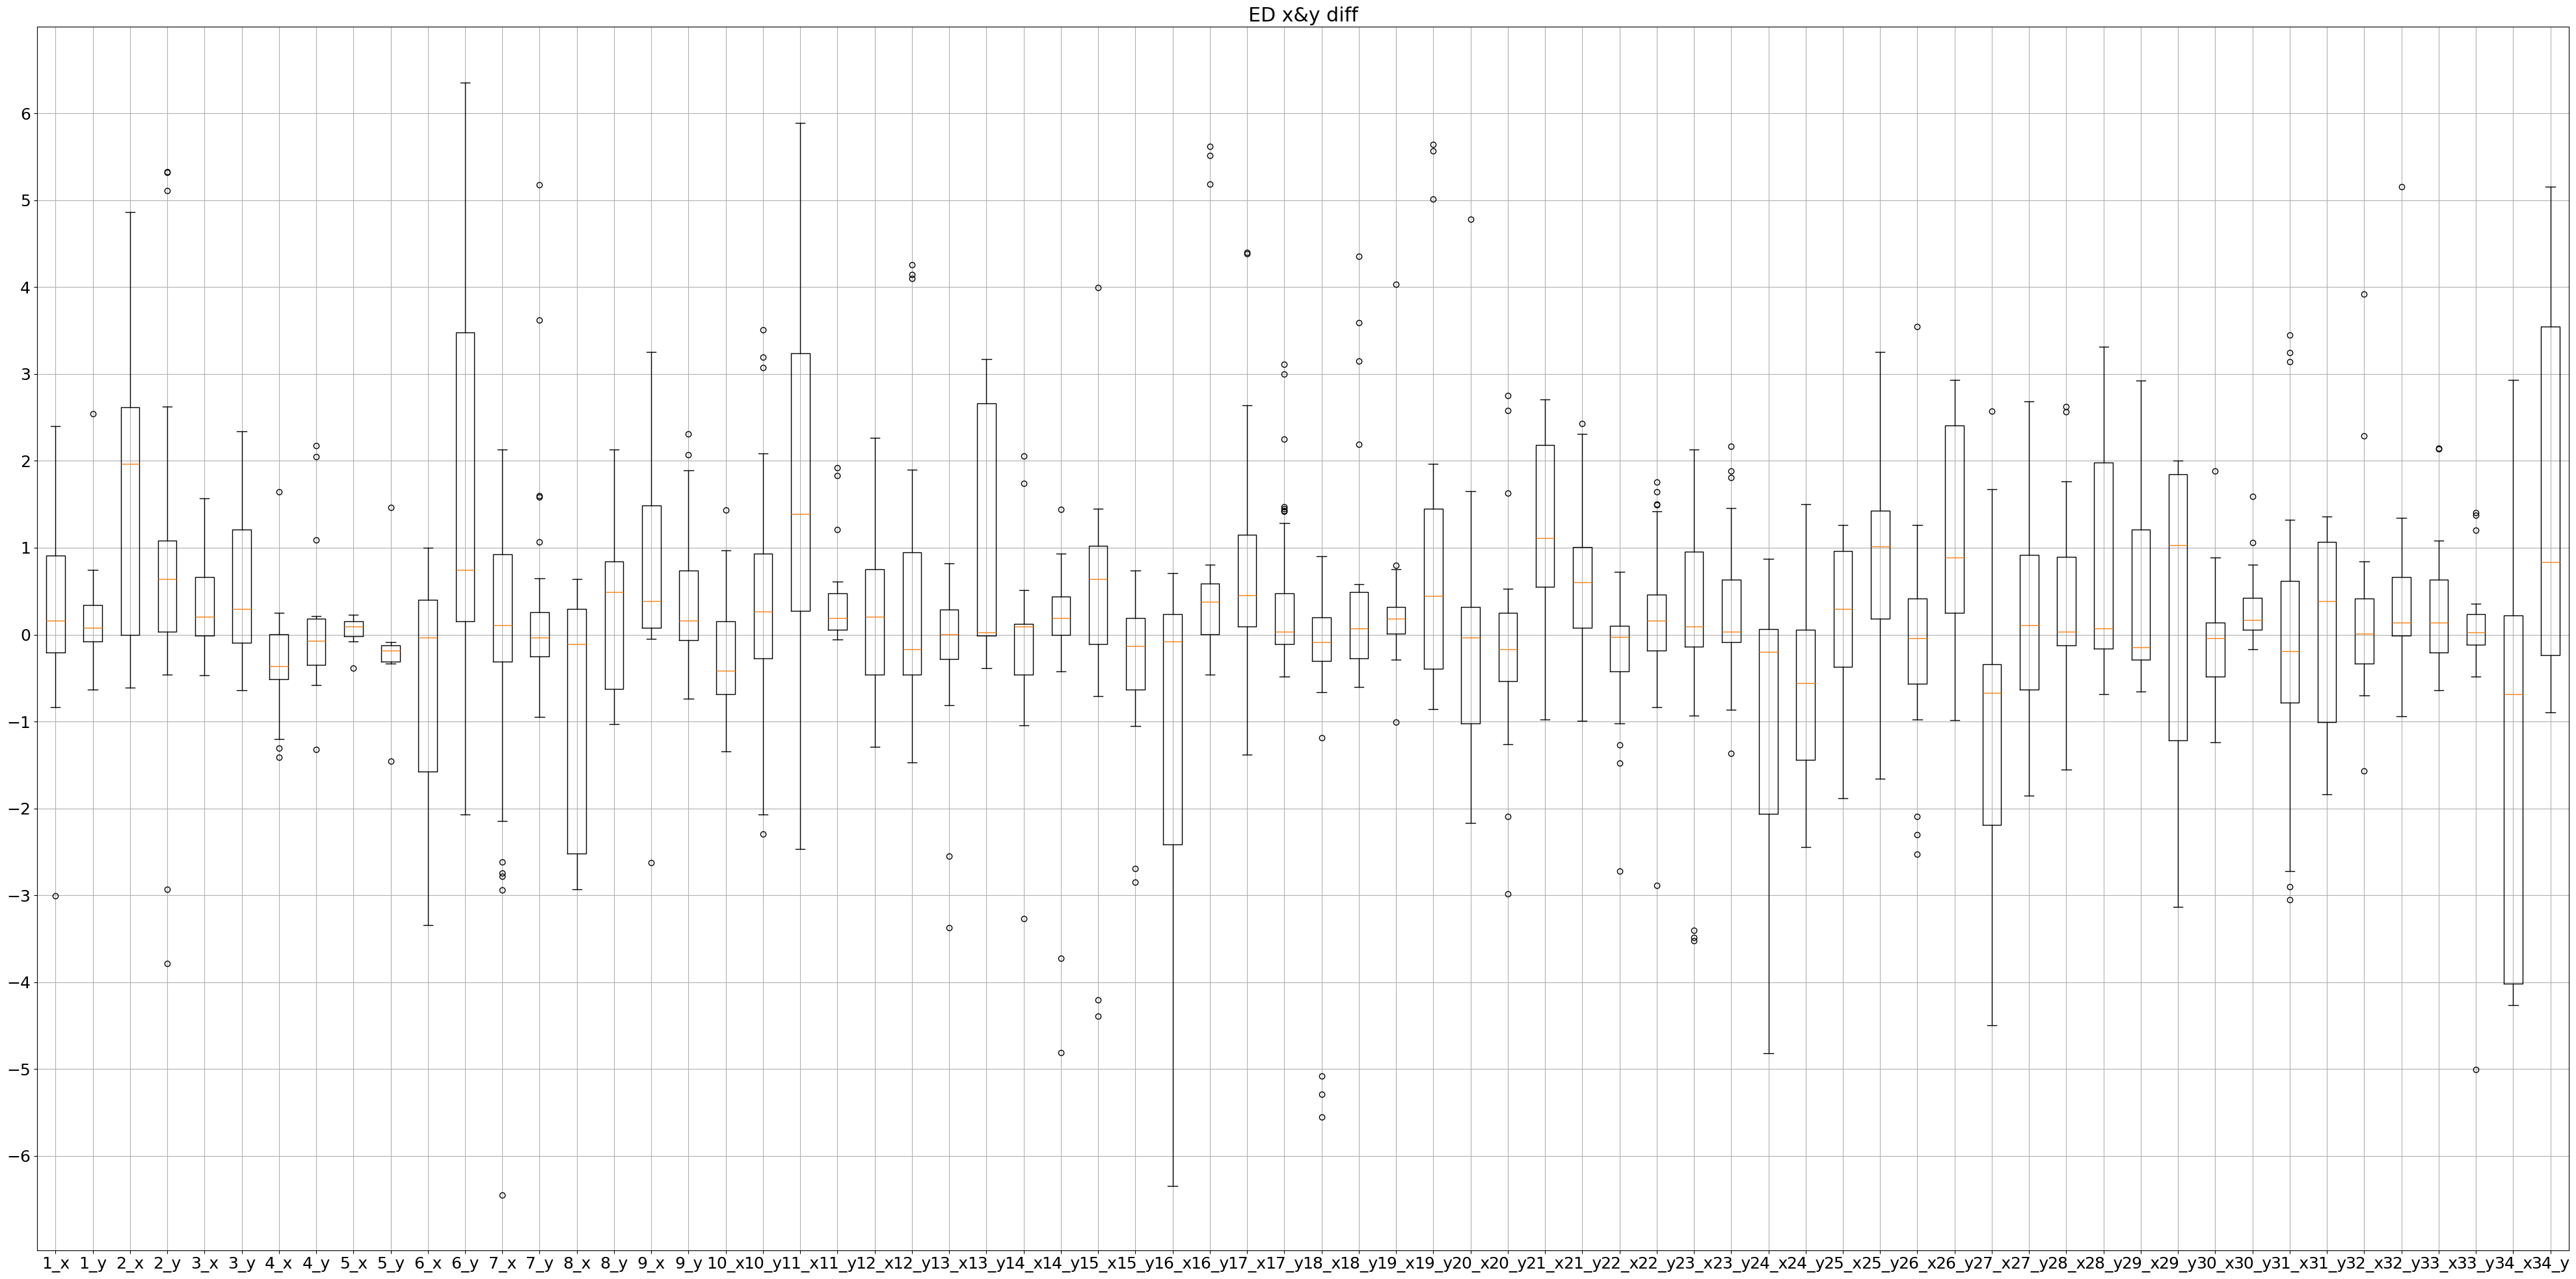

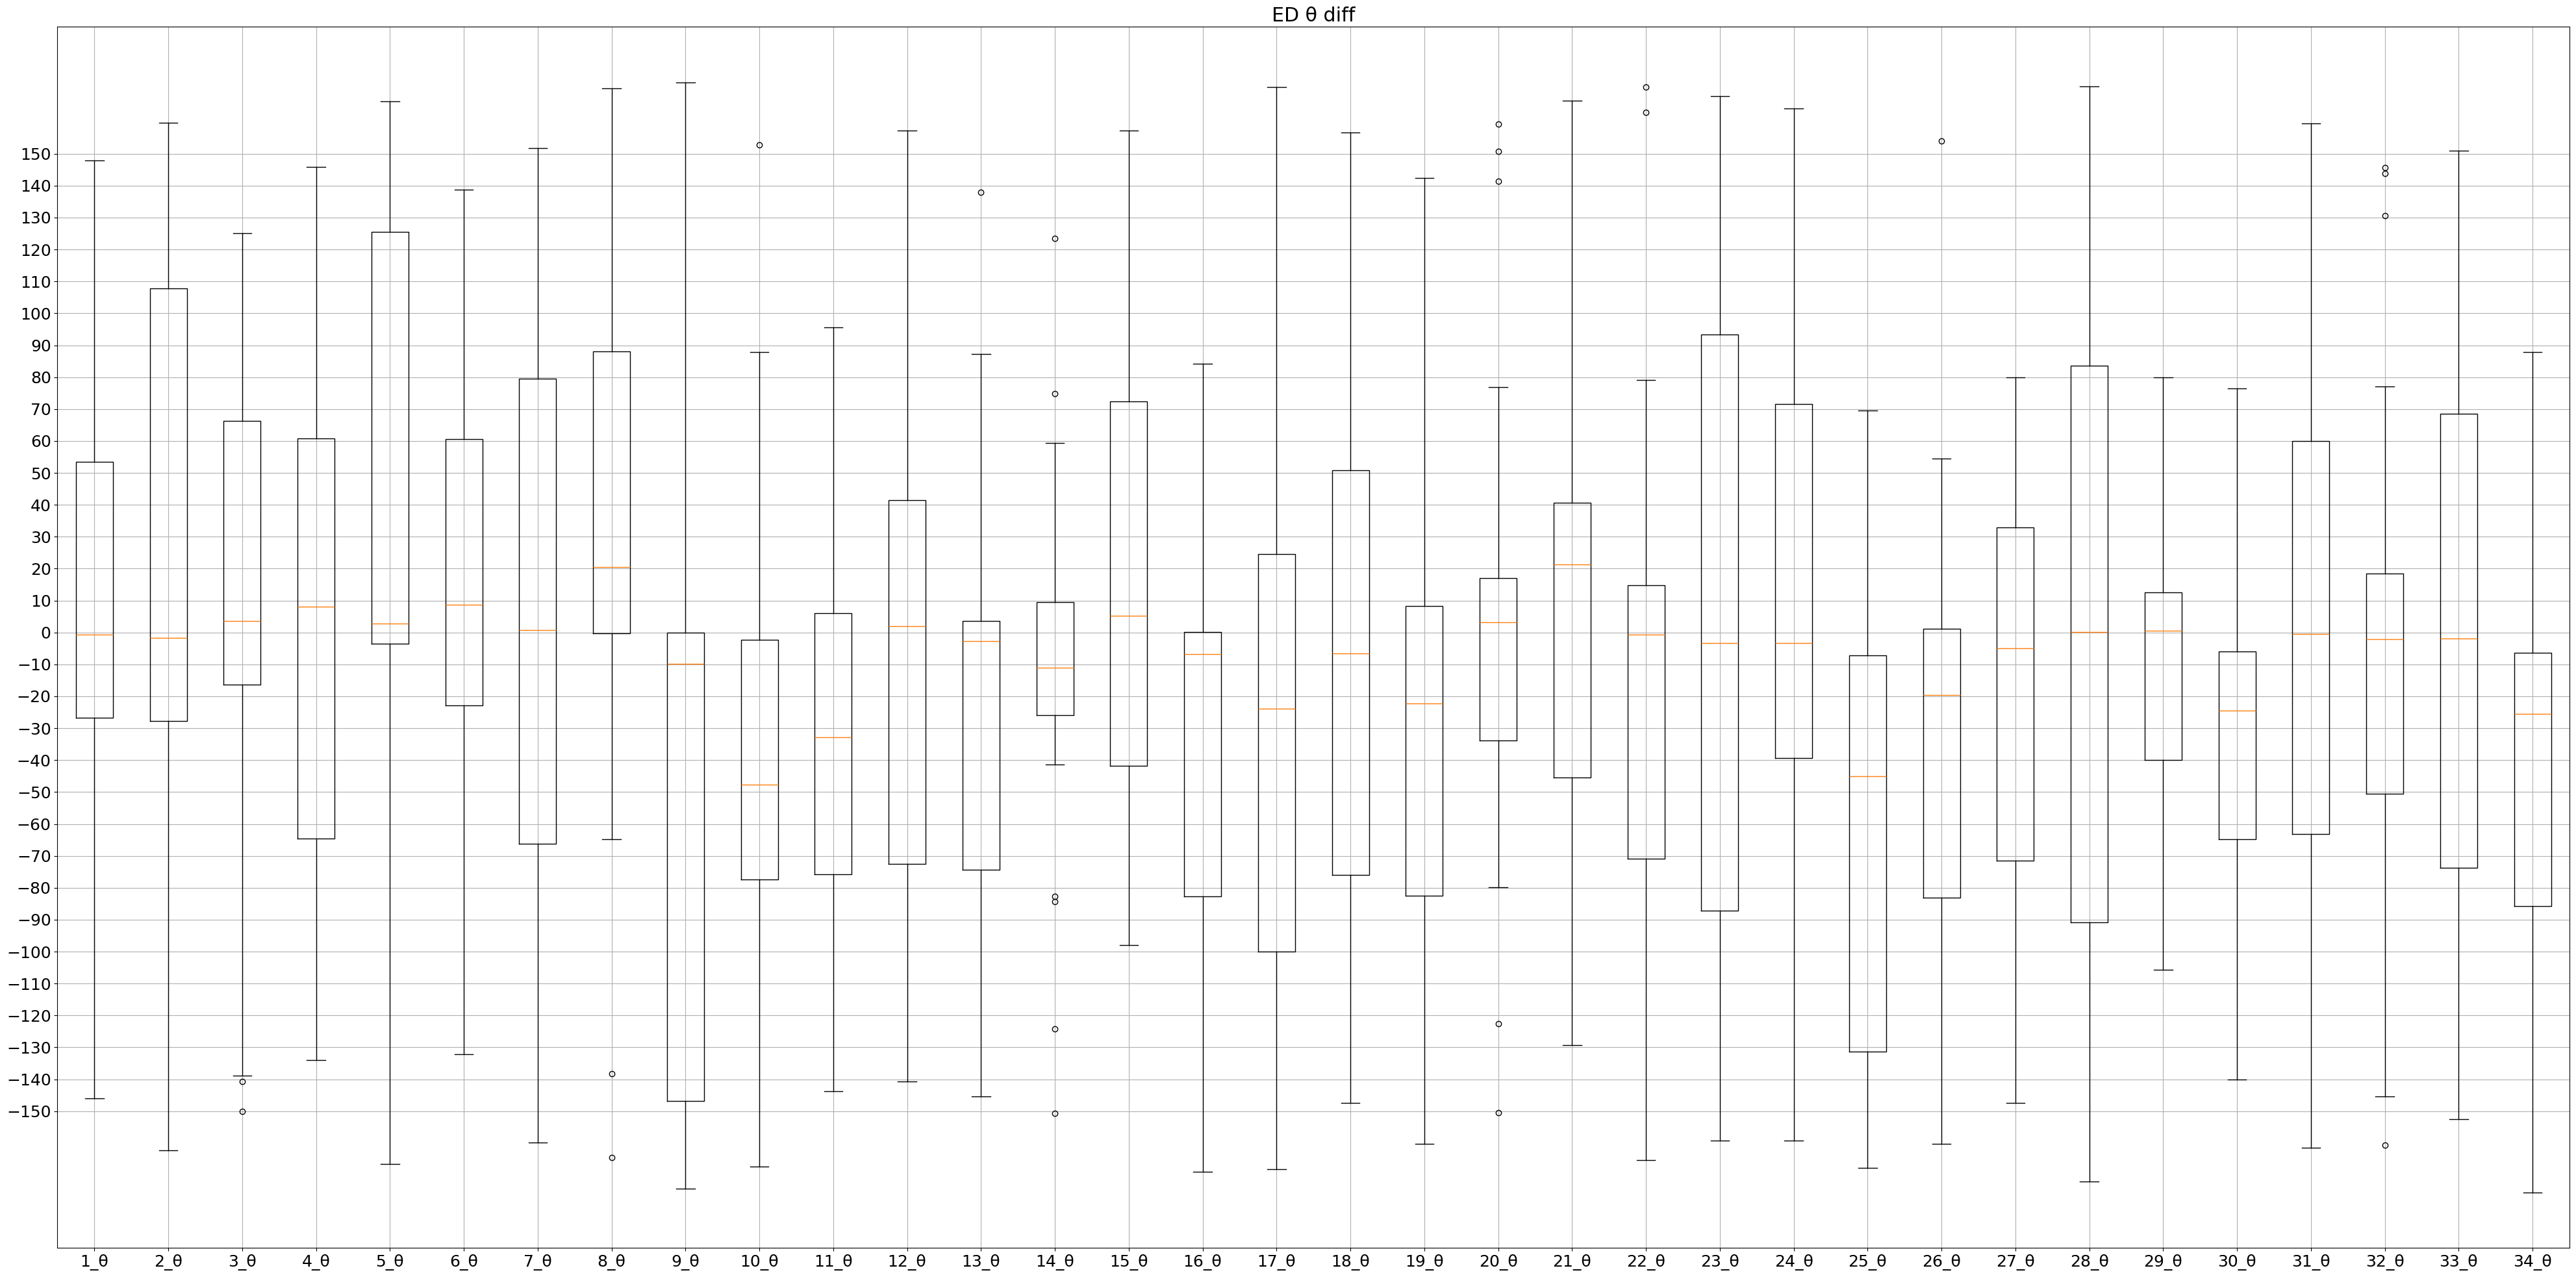

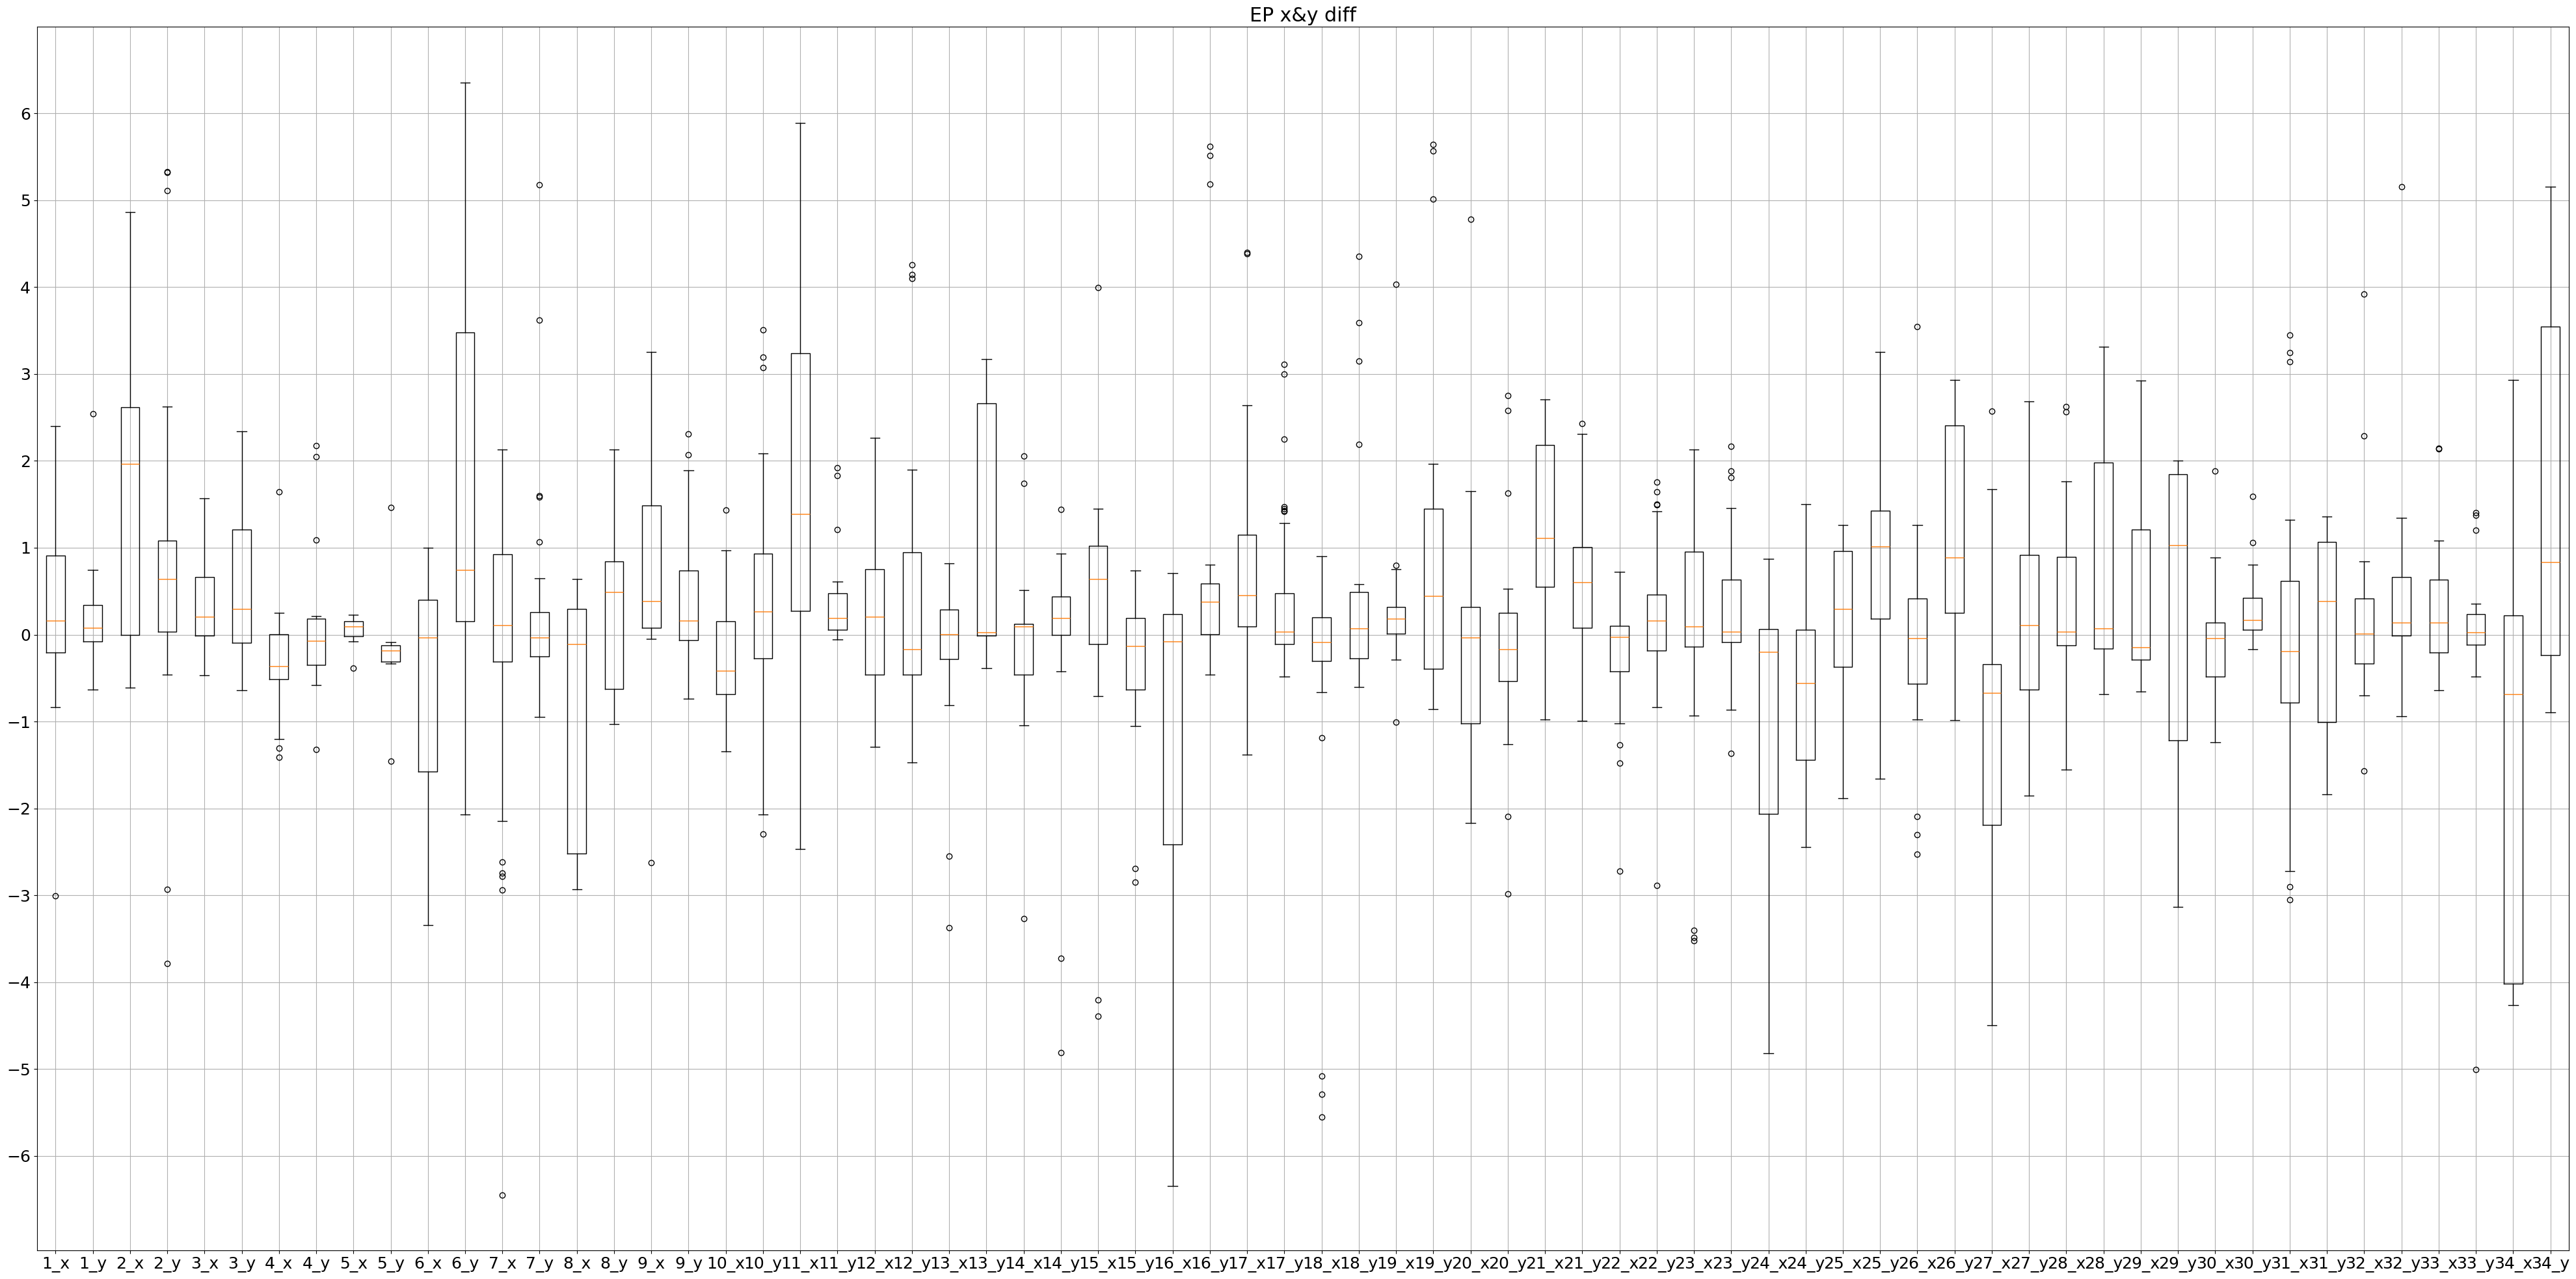

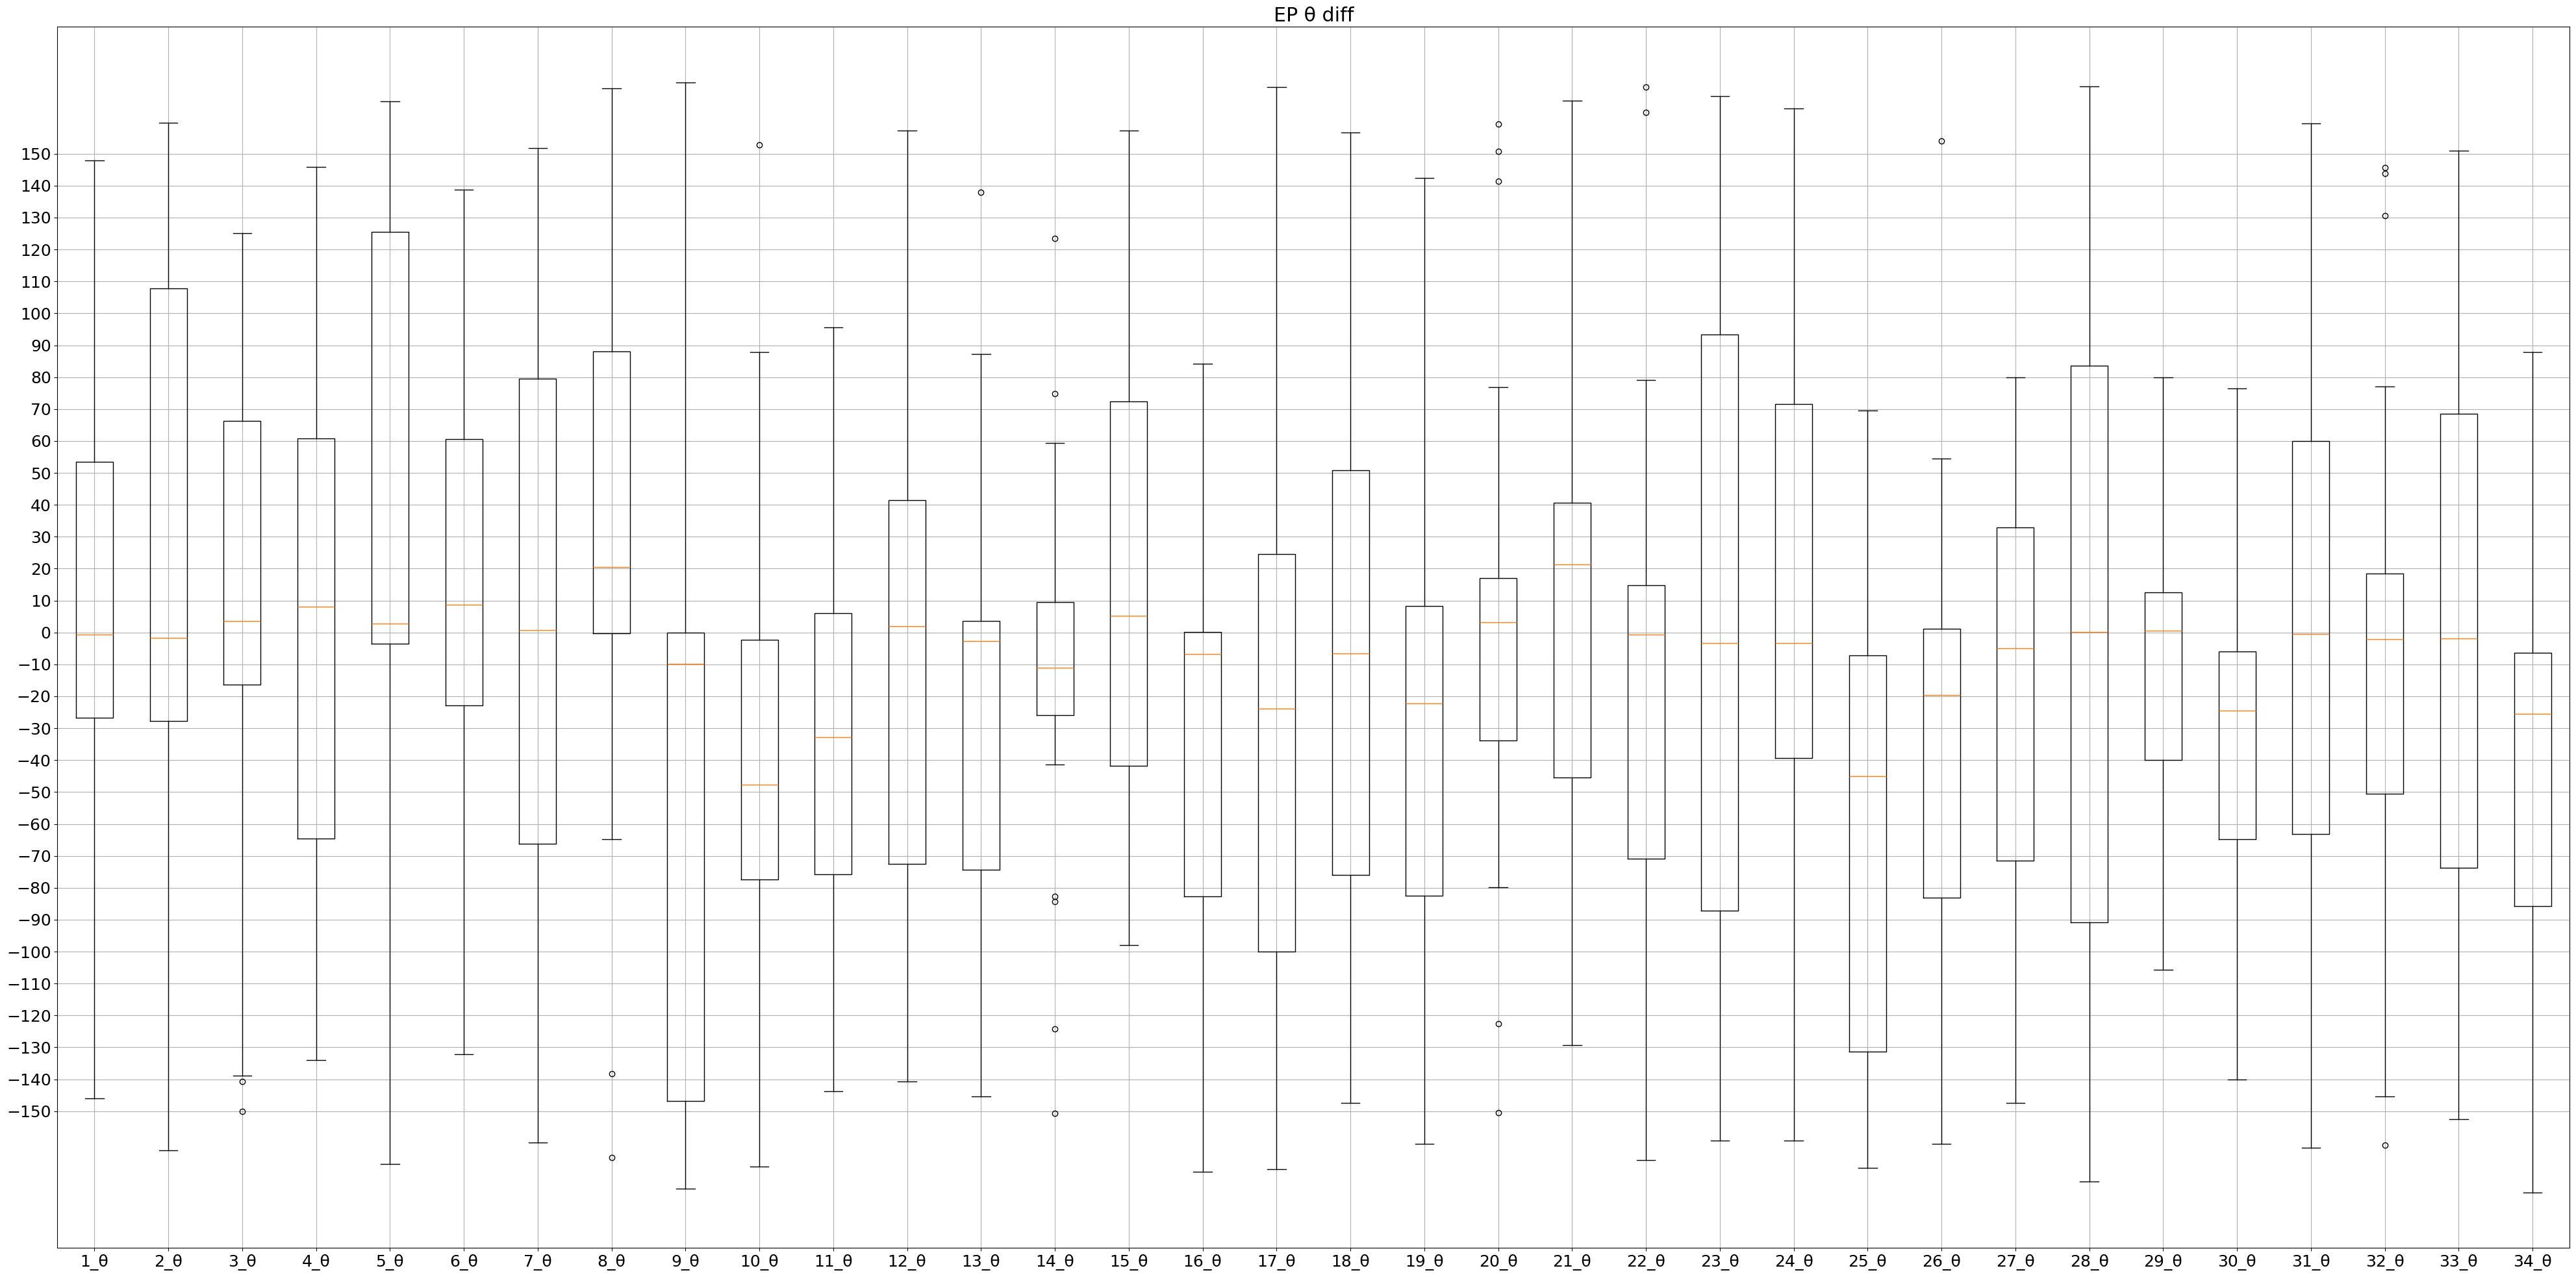

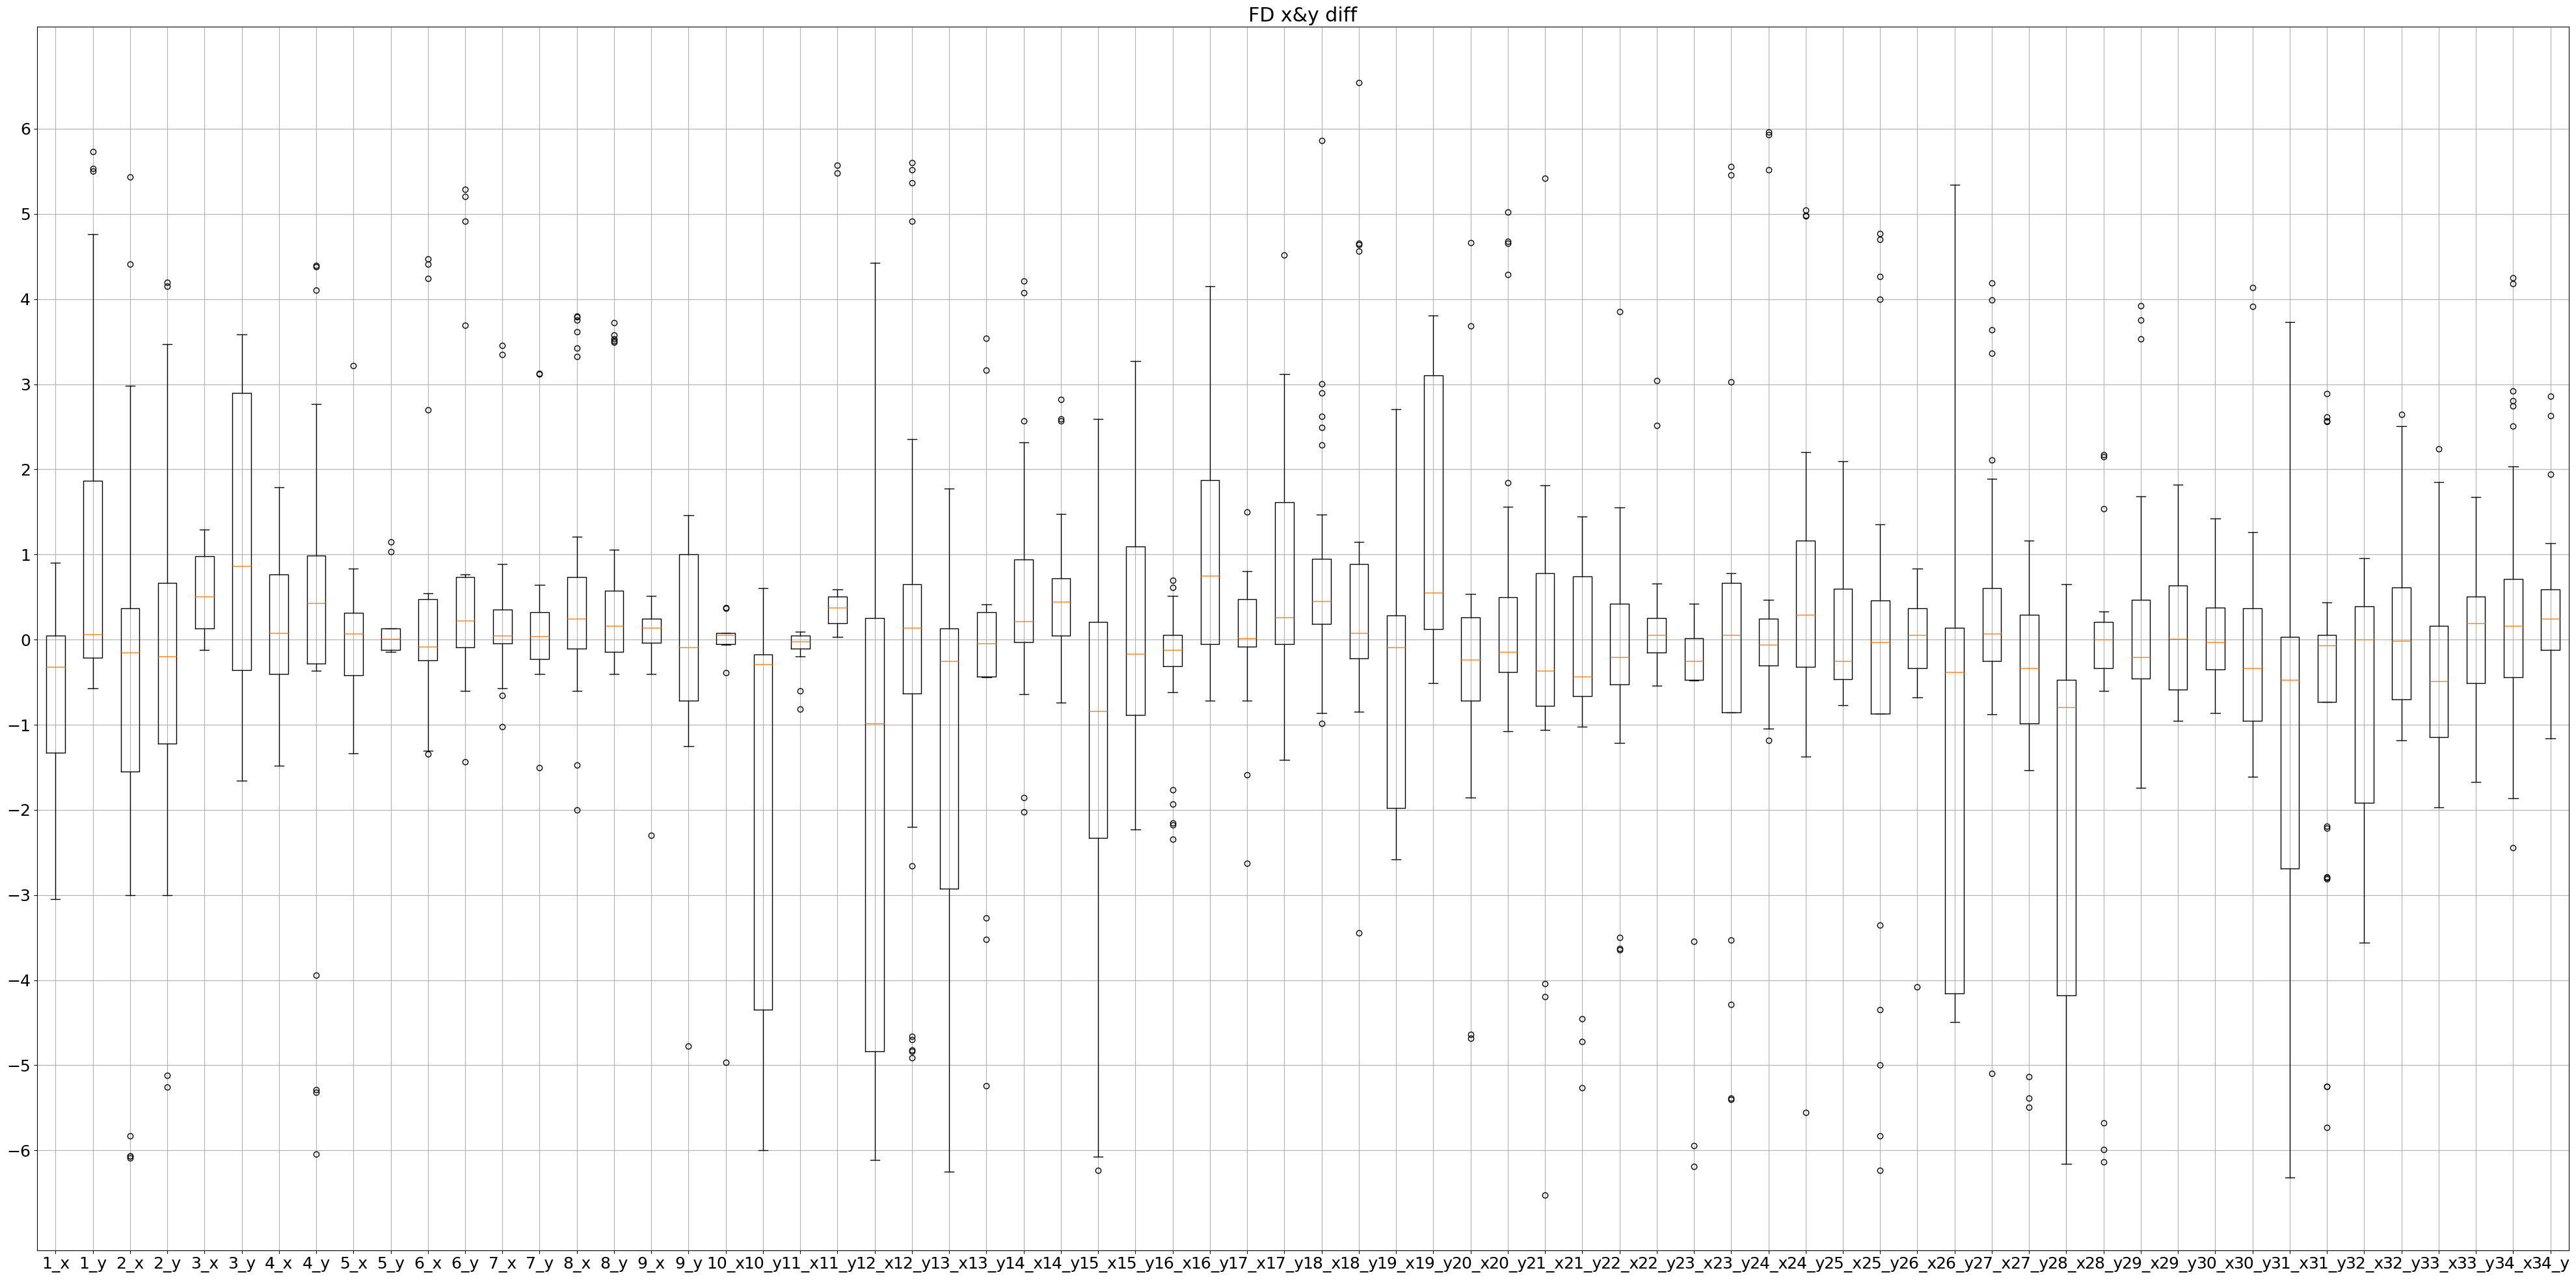

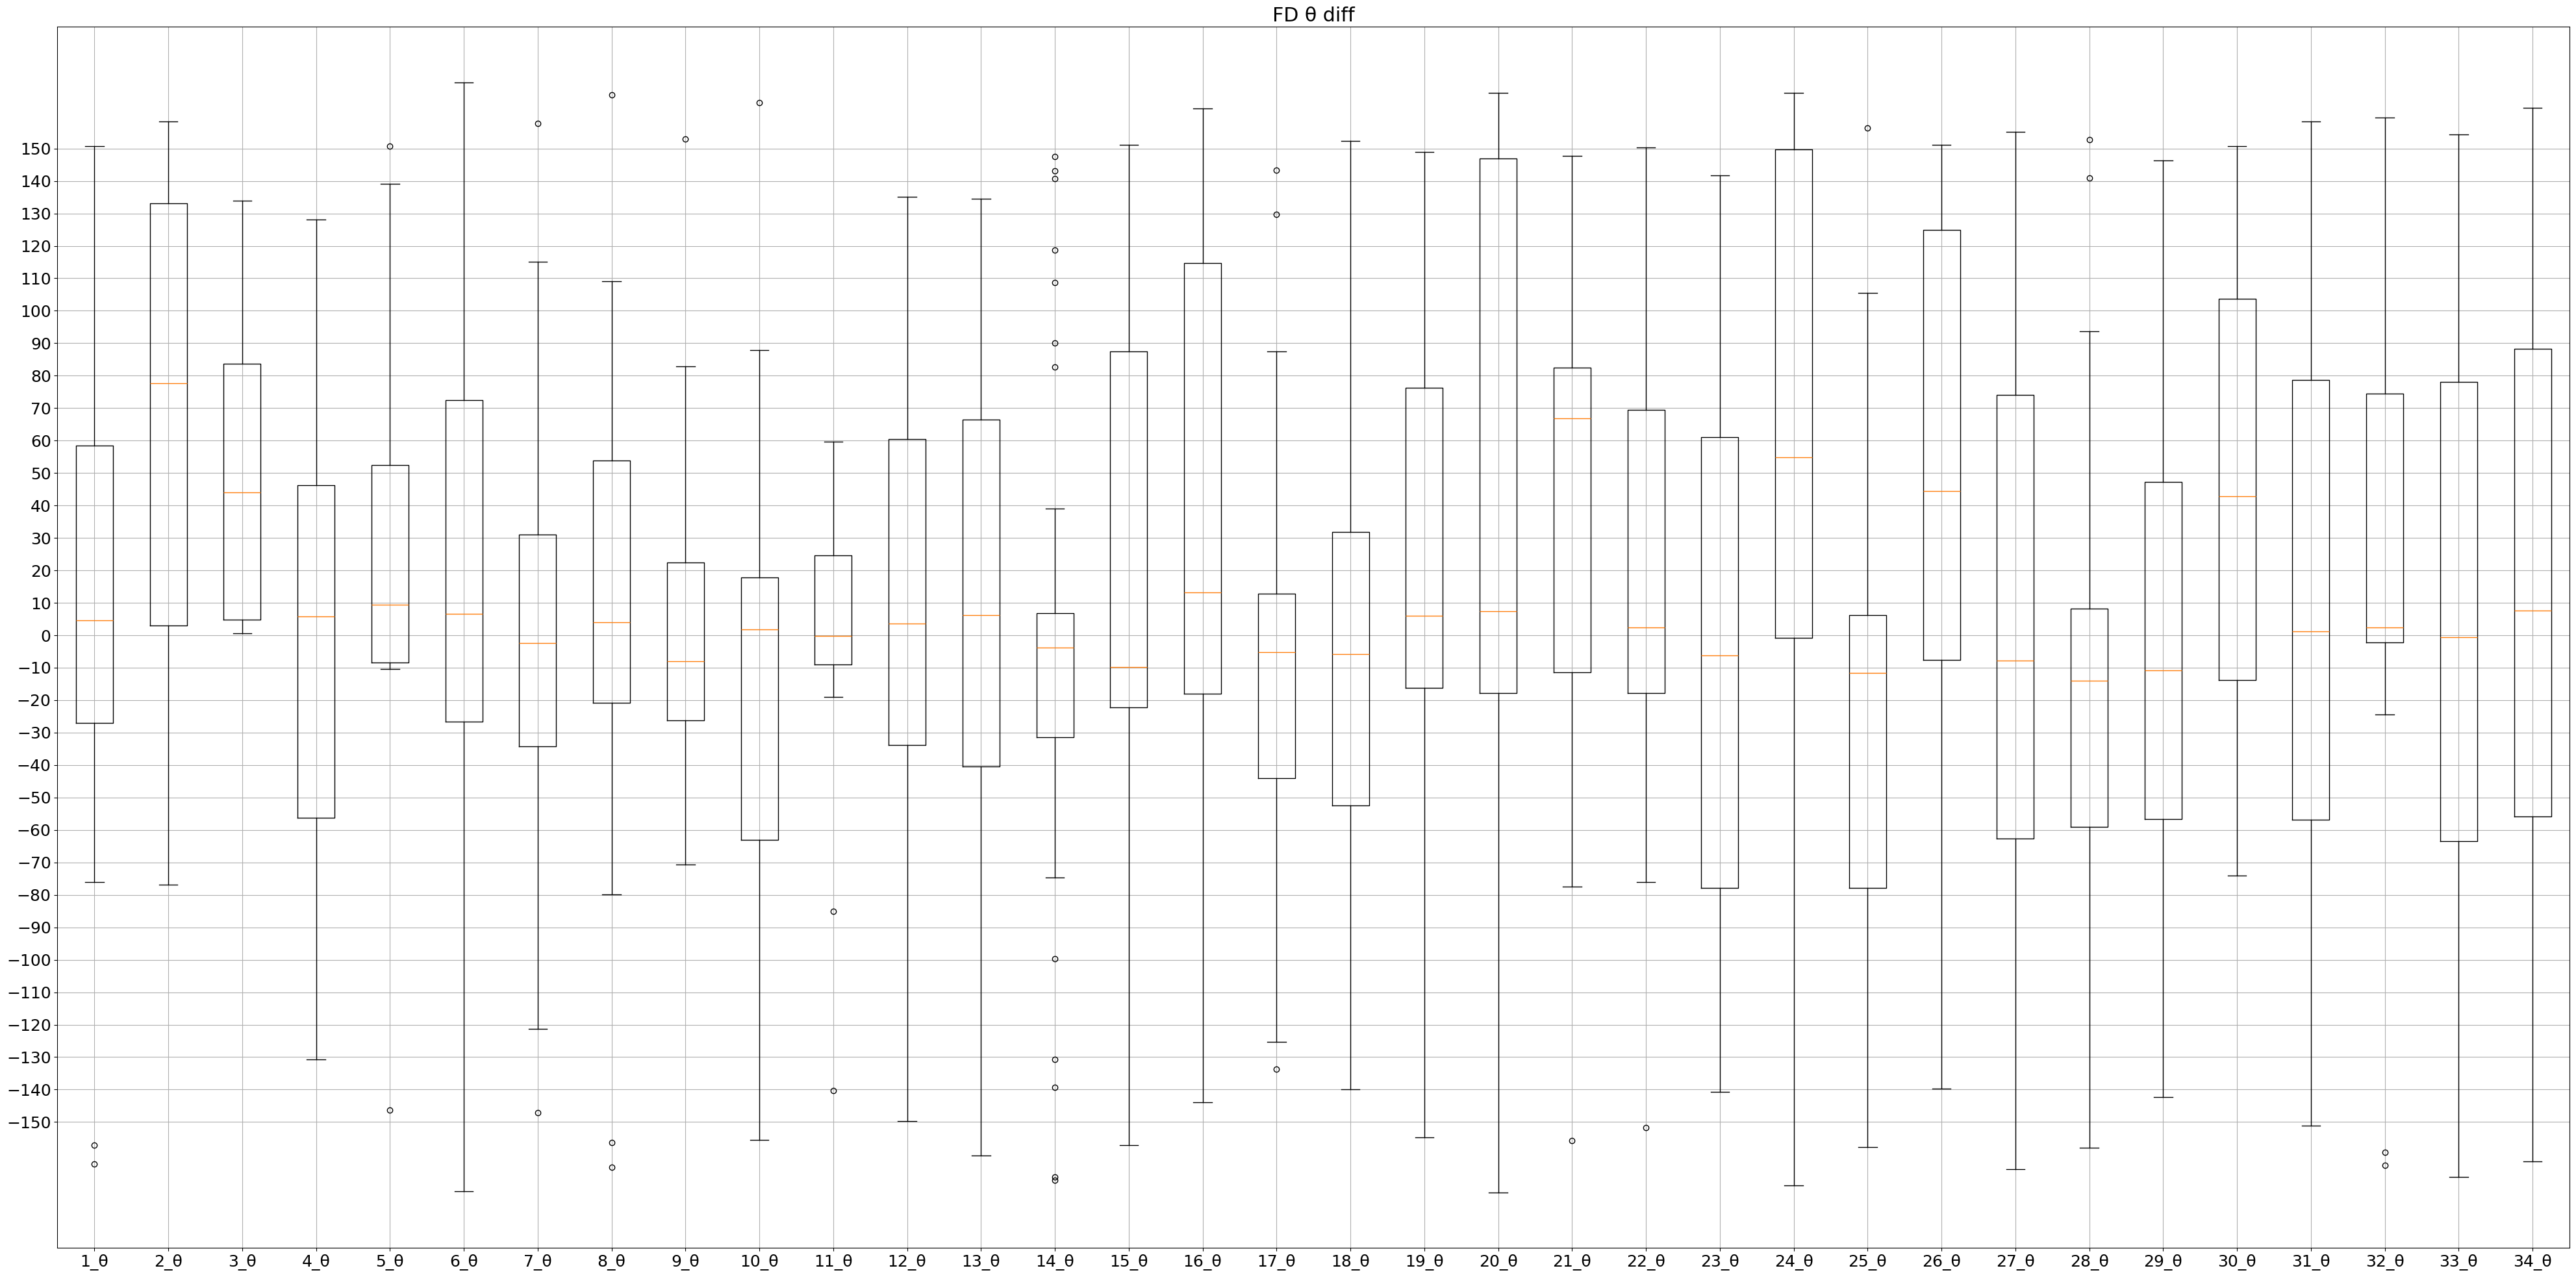

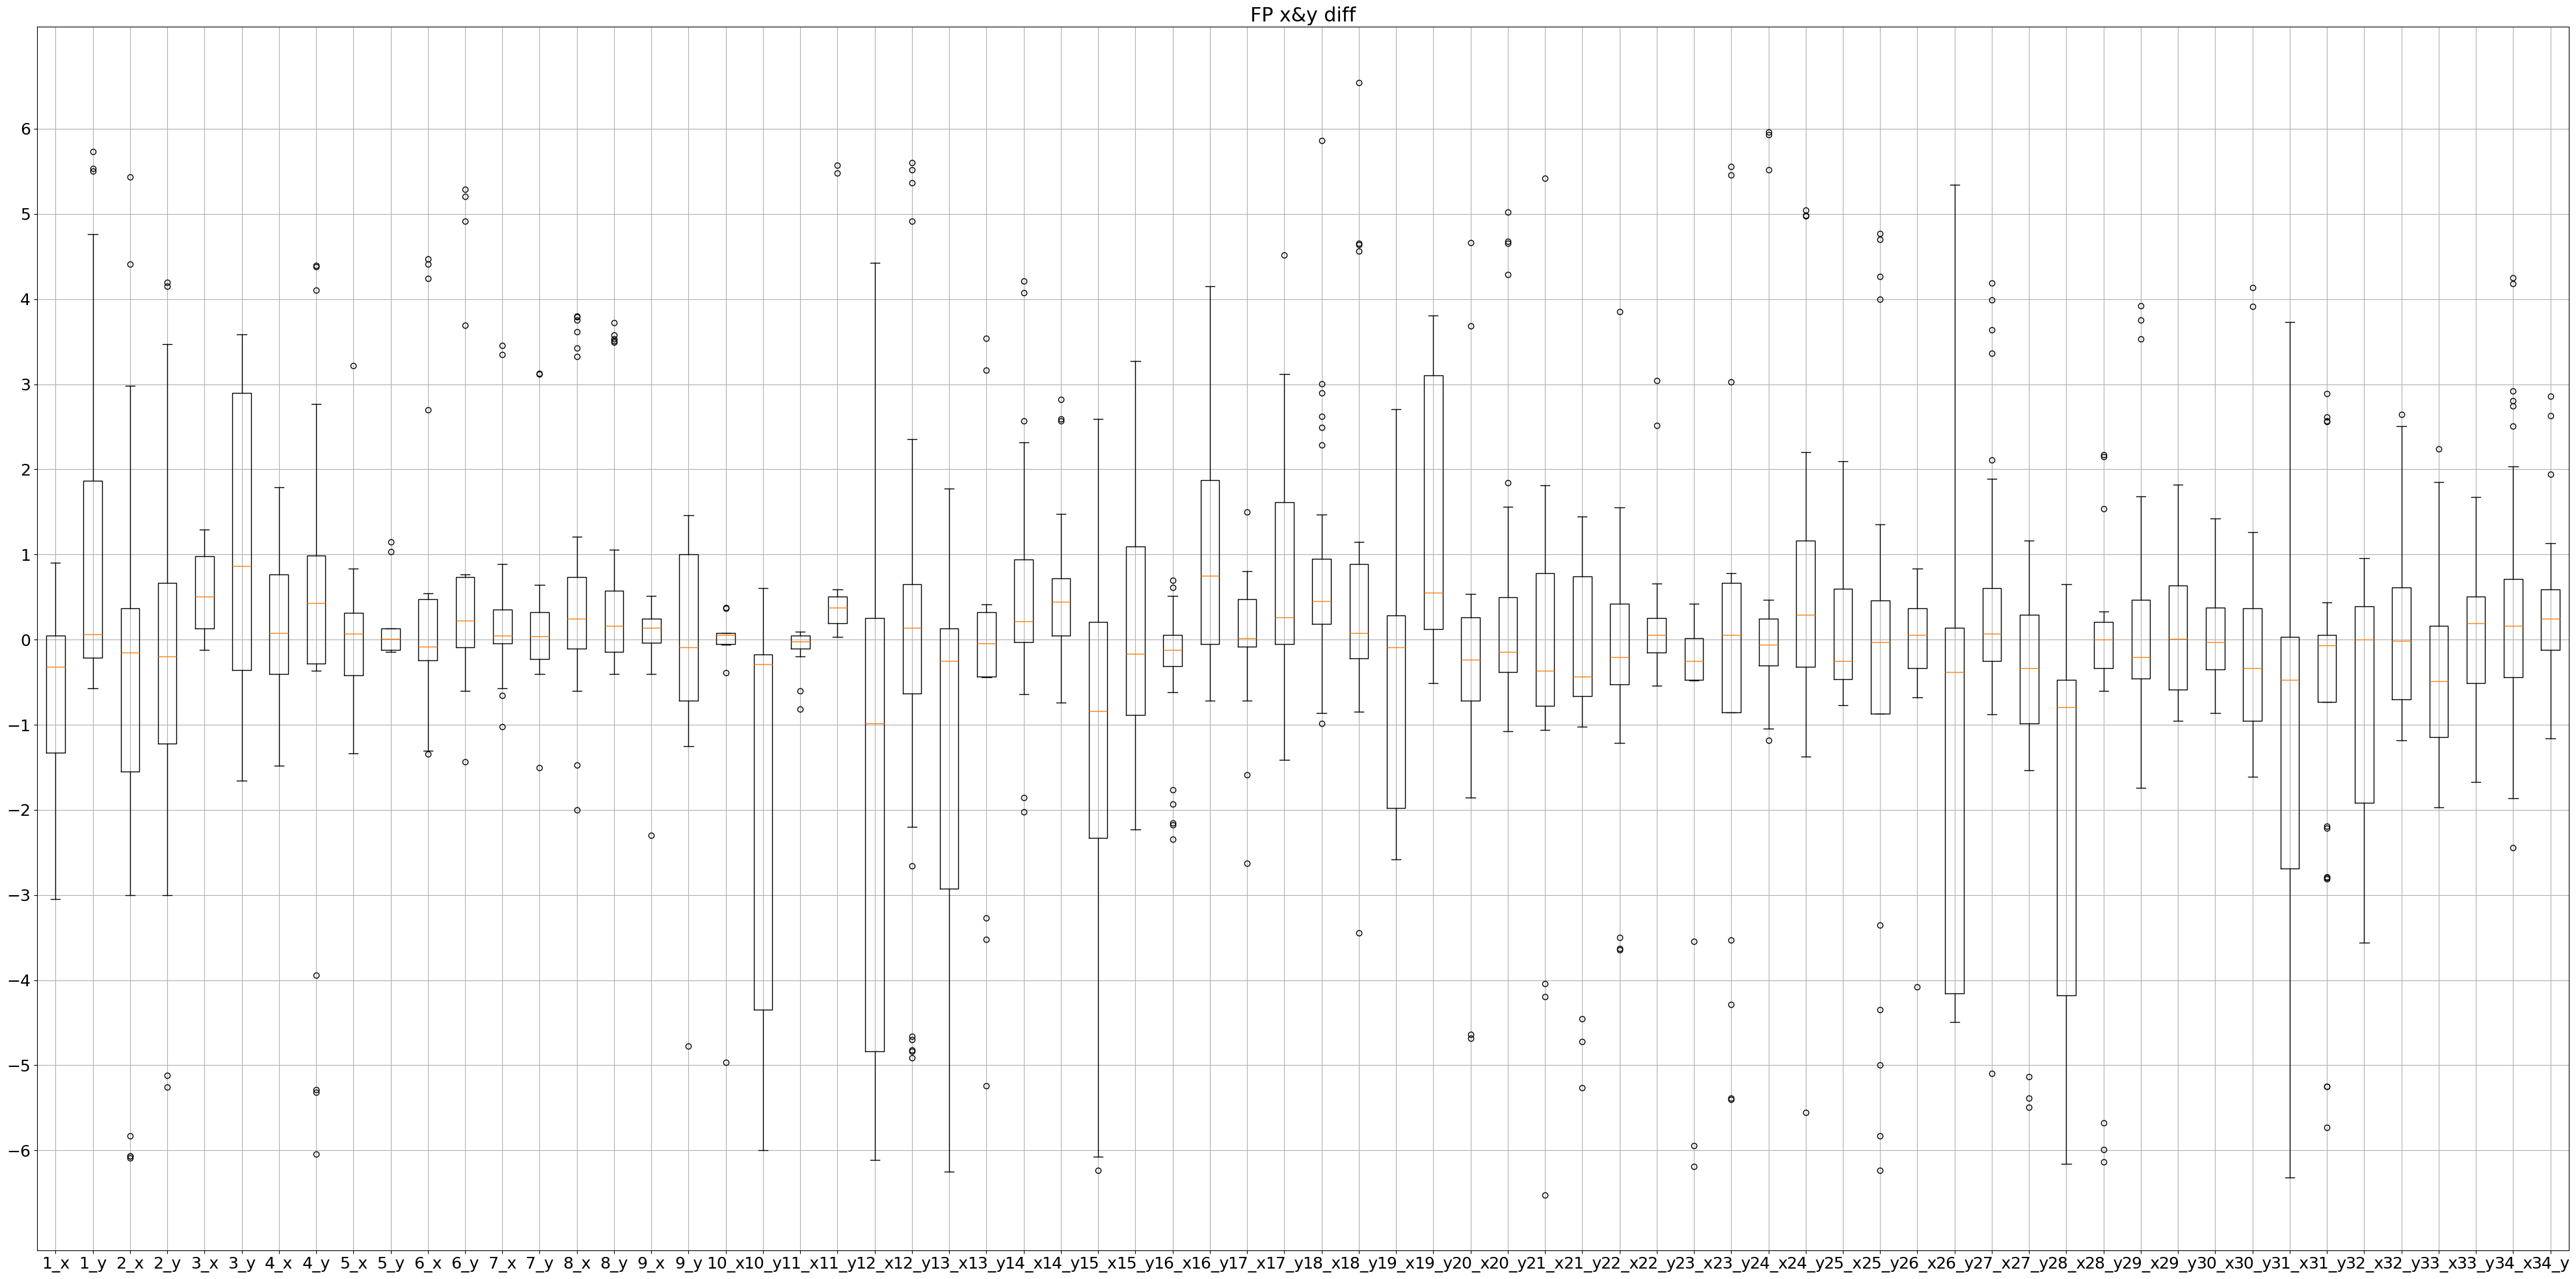

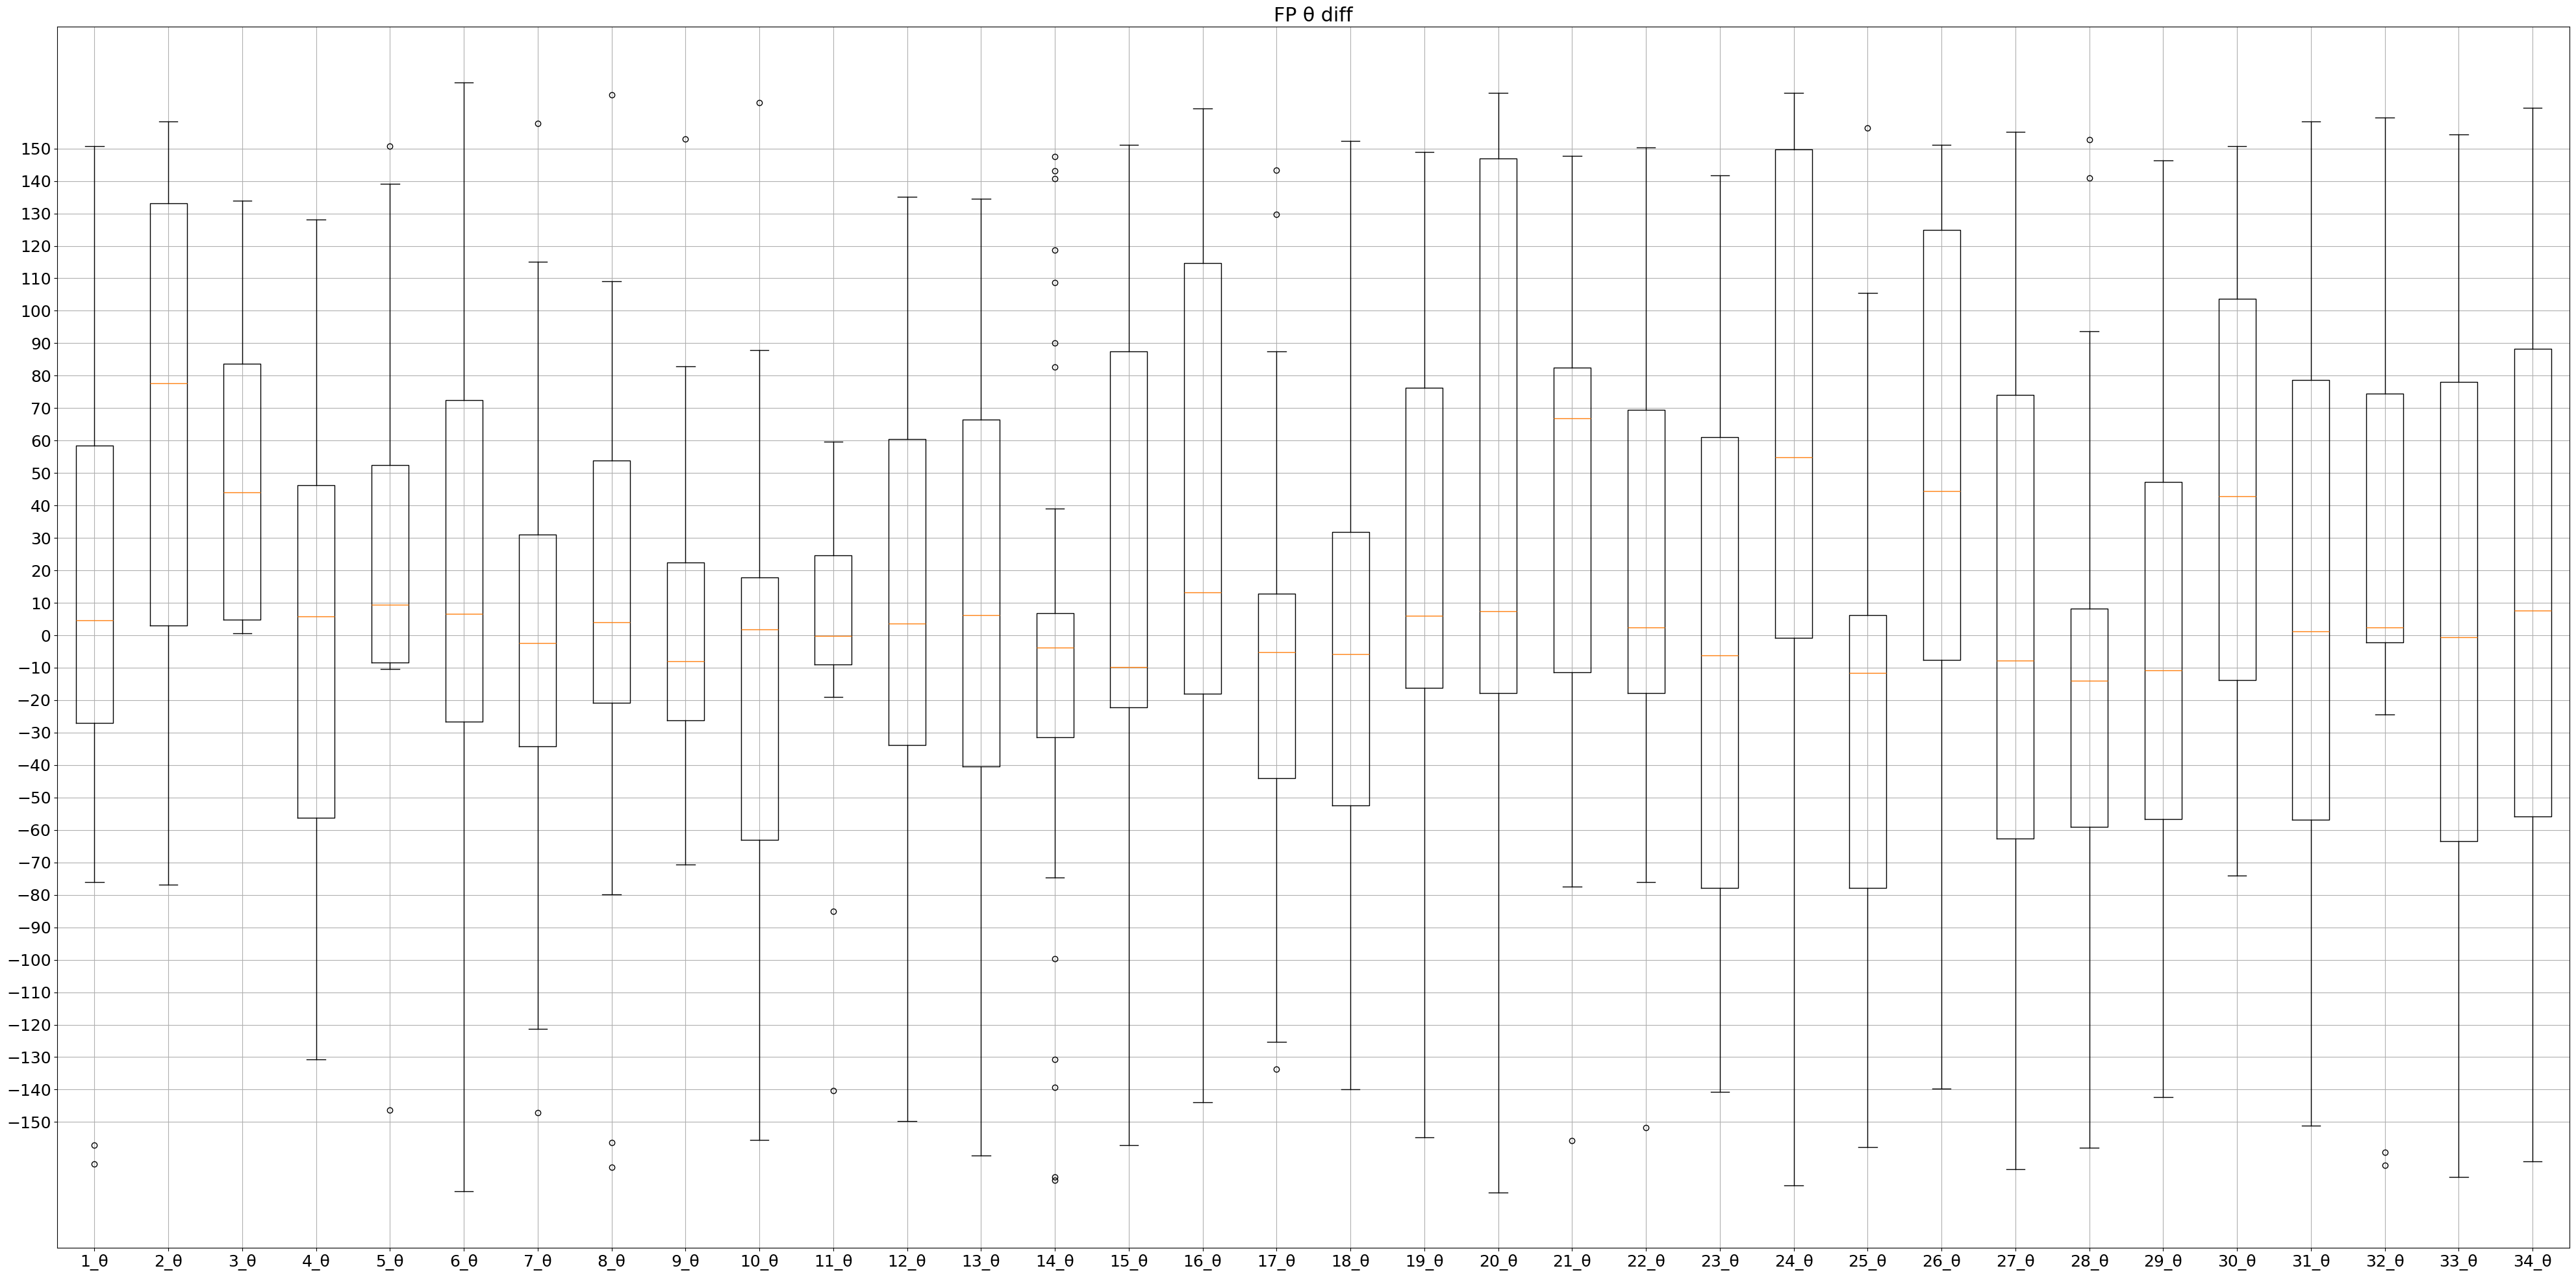

In [87]:
fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
ax.boxplot(ED_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('ED x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(ED_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('ED θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('EP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('EP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FD x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FD θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

## SVCで高確率と判断されたバイポーラ間の差分

In [88]:
diffs = []
for list_session1 in vpolars:
    for list_session2 in vpolars:
        if list_session1['subject'] == list_session2['subject'] and list_session1['session'] == 1 and list_session2['session'] == 2 and list_session1['gesture'] == list_session2['gesture'] and list_session1['trial'] == list_session2['trial'] and list_session1['electrode_place'] == list_session2['electrode_place']:
            print(f'file_name: {list_session1["file_name"]}, gesture: {list_session1["gesture"]}, trial: {list_session1["trial"]}, subject: {list_session1["subject"]}, session: {list_session1["session"]}, electrode_place: {list_session1["electrode_place"]}')
            print(f'file_name: {list_session2["file_name"]}, gesture: {list_session2["gesture"]}, trial: {list_session2["trial"]}, subject: {list_session2["subject"]}, session: {list_session2["session"]}, electrode_place: {list_session2["electrode_place"]}')
            if list_session1['n_virtual_bipolars'] > 0 and list_session2['n_virtual_bipolars'] > 0:
                record_session1 = wfdb.rdrecord(list_session1["file_name"])
                record_session2 = wfdb.rdrecord(list_session2["file_name"])

                if list_session1['electrode_place'] == 'ED':
                    emg_data_session1 = record_session1.p_signal[:,:64] #Extensor Distal
                    emg_data_session2 = record_session2.p_signal[:,:64] #Extensor Distal
                elif list_session1['electrode_place'] == 'EP':
                    emg_data_session1 = record_session1.p_signal[:,64:128] #Extensor Proximal
                    emg_data_session2 = record_session2.p_signal[:,64:128] #Extensor Proximal
                elif list_session1['electrode_place'] == 'FD': 
                    emg_data_session1 = record_session1.p_signal[:,128:192] #Flexor Distal
                    emg_data_session2 = record_session2.p_signal[:,128:192] #Flexor Distal
                elif list_session1['electrode_place'] == 'FP':
                    emg_data_session1 = record_session1.p_signal[:,192:256] #Flexor Proximal
                    emg_data_session2 = record_session2.p_signal[:,192:256] #Flexor Proximal
                
                virtual_bipolars_session1 = list_session1['virtual_bipolars']
                virtual_bipolars_session2 = list_session2['virtual_bipolars']
                labels_session1 = list_session1['labels']
                labels_session2 = list_session2['labels']
                center_direction_session1 = list_session1['center_direction']
                center_direction_session2 = list_session2['center_direction']

                if list_session1['n_virtual_bipolars'] == 1:
                    virtual_bipolars_session1.append([0,0,0,0])
                    labels_session1.append(999)
                    center_direction_session1.append([0,0,0])
                
                virtual_emg_session1 = get_virtual_emg(emg_data_session1, virtual_bipolars_session1)
                X_session1, y_session1 = get_features(virtual_emg_session1, labels_session1)
                
                virtual_emg_session2 = get_virtual_emg(emg_data_session2, virtual_bipolars_session2)
                X_session2, y_session2 = get_features(virtual_emg_session2, labels_session2)

                result, y_train, y_test = SVC_classifier(X_session1, y_session1, X_session2, y_session2)
                diff = diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2)
            else:
                diff = [None]
            diffs.append({'file_name':[list_session1["file_name"], list_session2["file_name"]],'subject':list_session1['subject'], 'gesture':list_session1['gesture'], 'trial': list_session1['trial'], 'electrode_place':list_session1['electrode_place'], 'diff':diff})
            

file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subje

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample10, gesture: 5, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample10, gesture: 5, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample22, gesture: 11, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample26, gesture: 13, trial: 2, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample30, gesture: 15, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 1, session: 2, electrode_place: FD
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 1, session: 2, electrode_place: FP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 1, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 1, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 1, session: 1, electrode_place: ED
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 1, session: 2, electrode_place: ED
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 1, session: 1, electrode_place: EP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 1, session: 2, electrode_place: EP
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 1, session: 1, electrode_place: FD
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 1, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 1, session: 1, electrode_place: FP
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 1, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subje

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample7, gesture: 4, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample8, gesture: 4, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample9, gesture: 5, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subje

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample11, gesture: 6, trial: 1, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample12, gesture: 6, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample13, gesture: 7, trial: 1, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample14, gesture: 7, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample15, gesture: 8, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample16, gesture: 8, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_datase

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample17, gesture: 9, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample18, gesture: 9, trial: 2, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample19, gesture: 10, trial: 1, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample20, gesture: 10, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample21, gesture: 11, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample23, gesture: 12, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample24, gesture: 12, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample25, gesture: 13, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample27, gesture: 14, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample28, gesture: 14, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample29, gesture: 15, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample30, gesture: 16, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample30, gesture: 16, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample30, gesture: 16, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample30, gesture: 16, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample31, gesture: 16, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample31, gesture: 16, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample31, gesture: 16, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample31, gesture: 16, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample31, gesture: 16, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample32, gesture: 16, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample32, gesture: 17, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample32, gesture: 17, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample32, gesture: 17, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample32, gesture: 17, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample33, gesture: 17, trial: 1, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample33, gesture: 17, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample33, gesture: 17, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample33, gesture: 17, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample33, gesture: 17, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample34, gesture: 17, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample34, gesture: 18, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample34, gesture: 18, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample34, gesture: 18, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample34, gesture: 18, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample35, gesture: 18, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample35, gesture: 18, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample35, gesture: 18, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample35, gesture: 18, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample35, gesture: 18, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample36, gesture: 18, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample36, gesture: 19, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample36, gesture: 19, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample36, gesture: 19, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample36, gesture: 19, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample37, gesture: 19, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample37, gesture: 19, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample37, gesture: 19, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample37, gesture: 19, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample37, gesture: 19, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample38, gesture: 19, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample38, gesture: 20, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample38, gesture: 20, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample38, gesture: 20, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample38, gesture: 20, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample39, gesture: 20, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample39, gesture: 20, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample39, gesture: 20, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample39, gesture: 20, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample39, gesture: 20, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample40, gesture: 20, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample40, gesture: 21, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample40, gesture: 21, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample40, gesture: 21, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample40, gesture: 21, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample41, gesture: 21, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample41, gesture: 21, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample41, gesture: 21, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample41, gesture: 21, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample41, gesture: 21, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample42, gesture: 21, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample42, gesture: 22, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample42, gesture: 22, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample42, gesture: 22, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample42, gesture: 22, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample43, gesture: 22, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample43, gesture: 22, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample43, gesture: 22, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample43, gesture: 22, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample43, gesture: 22, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample44, gesture: 22, trial: 2, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample44, gesture: 23, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample44, gesture: 23, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample44, gesture: 23, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample44, gesture: 23, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample45, gesture: 23, trial: 1, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample45, gesture: 23, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample45, gesture: 23, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample45, gesture: 23, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample45, gesture: 23, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample46, gesture: 23, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample46, gesture: 24, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample46, gesture: 24, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample46, gesture: 24, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample46, gesture: 24, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample47, gesture: 24, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample47, gesture: 24, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample47, gesture: 24, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample47, gesture: 24, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample47, gesture: 24, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample48, gesture: 24, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample48, gesture: 25, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample49, gesture: 25, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample48, gesture: 25, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample49, gesture: 25, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample48, gesture: 25, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample49, gesture: 25, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample48, gesture: 25, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample49, gesture: 25, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample49, gesture: 25, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample50, gesture: 25, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample49, gesture: 25, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample50, gesture: 25, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample49, gesture: 25, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample50, gesture: 25, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample49, gesture: 25, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample50, gesture: 25, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample50, gesture: 26, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample50, gesture: 26, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample50, gesture: 26, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample50, gesture: 26, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample51, gesture: 26, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample51, gesture: 26, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample51, gesture: 26, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample51, gesture: 26, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample51, gesture: 26, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample52, gesture: 26, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample52, gesture: 27, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample52, gesture: 27, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample52, gesture: 27, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample52, gesture: 27, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample53, gesture: 27, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample53, gesture: 27, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample53, gesture: 27, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample53, gesture: 27, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample53, gesture: 27, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample54, gesture: 27, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample54, gesture: 28, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample54, gesture: 28, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample54, gesture: 28, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample54, gesture: 28, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample55, gesture: 28, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample55, gesture: 28, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample55, gesture: 28, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample55, gesture: 28, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample55, gesture: 28, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample56, gesture: 28, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample56, gesture: 29, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample56, gesture: 29, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample56, gesture: 29, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample56, gesture: 29, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample57, gesture: 29, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample57, gesture: 29, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample57, gesture: 29, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample57, gesture: 29, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample57, gesture: 29, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample58, gesture: 29, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample58, gesture: 30, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample58, gesture: 30, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample58, gesture: 30, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample58, gesture: 30, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample59, gesture: 30, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample59, gesture: 30, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample59, gesture: 30, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample59, gesture: 30, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample59, gesture: 30, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample60, gesture: 30, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample60, gesture: 31, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample60, gesture: 31, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample60, gesture: 31, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample60, gesture: 31, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample61, gesture: 31, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample61, gesture: 31, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample61, gesture: 31, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample61, gesture: 31, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample61, gesture: 31, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample62, gesture: 31, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample62, gesture: 32, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample62, gesture: 32, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample62, gesture: 32, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample62, gesture: 32, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample63, gesture: 32, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample63, gesture: 32, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample63, gesture: 32, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample63, gesture: 32, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 2, session: 2, electrode_place: FD
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample63, gesture: 32, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample64, gesture: 32, trial: 2, subject: 2, session: 2, electrode_place: FP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample64, gesture: 33, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample64, gesture: 33, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample64, gesture: 33, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample64, gesture: 33, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample65, gesture: 33, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample65, gesture: 33, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 2, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample65, gesture: 33, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 2, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample65, gesture: 33, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample65, gesture: 33, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample66, gesture: 33, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample66, gesture: 34, trial: 1, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample66, gesture: 34, trial: 1, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample66, gesture: 34, trial: 1, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample66, gesture: 34, trial: 1, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample67, gesture: 34, trial: 1, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample67, gesture: 34, trial: 2, subject: 2, session: 1, electrode_place: ED
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 2, session: 2, electrode_place: ED
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample67, gesture: 34, trial: 2, subject: 2, session: 1, electrode_place: EP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 2, session: 2, electrode_place: EP
file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample67, gesture: 34, trial: 2, subject: 2, session: 1, electrode_place: FD
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 2, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject02_session1/maintenance_preprocess_sample67, gesture: 34, trial: 2, subject: 2, session: 1, electrode_place: FP
file_name: pr_dataset/subject02_session2/maintenance_preprocess_sample68, gesture: 34, trial: 2, subject: 2, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample3, gesture: 2, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample4, gesture: 2, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample5, gesture: 3, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subje

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample6, gesture: 3, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample7, gesture: 5, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subje

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample8, gesture: 5, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample9, gesture: 6, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample10, gesture: 6, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample11, gesture: 7, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample12, gesture: 7, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample13, gesture: 8, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample14, gesture: 8, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample15, gesture: 9, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample16, gesture: 9, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample17, gesture: 10, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample18, gesture: 10, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample19, gesture: 11, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample20, gesture: 11, trial: 2, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample21, gesture: 12, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample22, gesture: 12, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample23, gesture: 13, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample24, gesture: 13, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample25, gesture: 14, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample26, gesture: 14, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample27, gesture: 15, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample28, gesture: 15, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample29, gesture: 16, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample30, gesture: 16, trial: 2, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample31, gesture: 17, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample32, gesture: 17, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample33, gesture: 18, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample34, gesture: 18, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample35, gesture: 19, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample36, gesture: 19, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample37, gesture: 20, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample38, gesture: 20, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample39, gesture: 21, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample40, gesture: 21, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample41, gesture: 22, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample42, gesture: 22, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample43, gesture: 23, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample44, gesture: 23, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample45, gesture: 24, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample46, gesture: 24, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample46, gesture: 24, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample46, gesture: 24, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample47, gesture: 25, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample48, gesture: 25, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample49, gesture: 26, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample50, gesture: 26, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample51, gesture: 27, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample52, gesture: 27, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample53, gesture: 28, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample54, gesture: 28, trial: 2, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample55, gesture: 29, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample56, gesture: 29, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample57, gesture: 30, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample58, gesture: 30, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample59, gesture: 31, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 2, electrode_place: ED
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 2, electrode_place: EP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample60, gesture: 31, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 2, electrode_place: FD
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample61, gesture: 32, trial: 1, subject: 3, session: 2, electrode_place: FP
file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample62, gesture: 32, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample63, gesture: 33, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample64, gesture: 33, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample65, gesture: 34, trial: 1, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 1, electrode_place: ED
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 2, electrode_place: ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 1, electrode_place: EP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 2, electrode_place: EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 1, electrode_place: FD
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 2, electrode_place: FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


file_name: pr_dataset/subject03_session1/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 1, electrode_place: FP
file_name: pr_dataset/subject03_session2/maintenance_preprocess_sample66, gesture: 34, trial: 2, subject: 3, session: 2, electrode_place: FP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for i in range(n_gestures):
    x_ED_gesture[i+1] = []
    y_ED_gesture[i+1] = []
    theta_ED_gesture[i+1] = []
    x_EP_gesture[i+1] = []
    y_EP_gesture[i+1] = []
    theta_EP_gesture[i+1] = []
    x_FD_gesture[i+1] = []
    y_FD_gesture[i+1] = []
    theta_FD_gesture[i+1] = []
    x_FP_gesture[i+1] = []
    y_FP_gesture[i+1] = []
    theta_FP_gesture[i+1] = []

In [90]:
for diff_list in diffs:
    print(diff_list)
    if diff_list['diff'] != [None]:
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['diff']:
                x_ED_gesture[gesture].append(diff['x_diff'])
                y_ED_gesture[gesture].append(diff['y_diff'])
                theta_ED_gesture[gesture].append(diff['theta_diff'])
        elif electrode_place == 'EP':
            for diff in diff_list['diff']:
                x_EP_gesture[gesture].append(diff['x_diff'])
                y_EP_gesture[gesture].append(diff['y_diff'])
                theta_EP_gesture[gesture].append(diff['theta_diff'])
        elif electrode_place == 'FD':
            for diff in diff_list['diff']:
                x_FD_gesture[gesture].append(diff['x_diff'])
                y_FD_gesture[gesture].append(diff['y_diff'])
                theta_FD_gesture[gesture].append(diff['theta_diff'])
        elif electrode_place == 'FP':
            for diff in diff_list['diff']:
                x_FP_gesture[gesture].append(diff['x_diff'])
                y_FP_gesture[gesture].append(diff['y_diff'])
                theta_FP_gesture[gesture].append(diff['theta_diff'])

{'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1', 'pr_dataset/subject01_session2/maintenance_preprocess_sample1'], 'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'ED', 'diff': [{'train': 0, 'test': 30, 'x_diff': 3.8259491881339103, 'y_diff': 3.593425777750928, 'theta_diff': 132.32900987559782}, {'train': 30, 'test': 10, 'x_diff': -0.02485568984674824, 'y_diff': -0.05747863767190342, 'theta_diff': 9.093665741959128}]}
{'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1', 'pr_dataset/subject01_session2/maintenance_preprocess_sample1'], 'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'EP', 'diff': [{'train': 0, 'test': 21, 'x_diff': 1.7616270566401457, 'y_diff': 0.4469915498896686, 'theta_diff': -8.493755675951192}, {'train': 2, 'test': 30, 'x_diff': 3.530924984543368, 'y_diff': 3.6625367414750234, 'theta_diff': -12.84537657546042}, {'train': 30, 'test': 12, 'x_diff': -0.2999712066670277, 'y_diff': 0.35633135

In [91]:
ED_xy_list = []
EP_xy_list = []
FD_xy_list = []
FP_xy_list = []
for i in range(n_gestures):
    ED_xy_list.append(x_ED_gesture[i+1])
    ED_xy_list.append(y_ED_gesture[i+1])
    # ED_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_xy_list.append(x_EP_gesture[i+1])
    EP_xy_list.append(y_EP_gesture[i+1])
    # EP_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_xy_list.append(x_FD_gesture[i+1])
    FD_xy_list.append(y_FD_gesture[i+1])
    # FD_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_xy_list.append(x_FP_gesture[i+1])
    FP_xy_list.append(y_FP_gesture[i+1])
    # FP_list.append(theta_FP_gesture[i+1])

ED_theta_list = []
EP_theta_list = []
FD_theta_list = []
FP_theta_list = []
for i in range(n_gestures):
    ED_theta_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_theta_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_theta_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_theta_list.append(theta_FP_gesture[i+1])


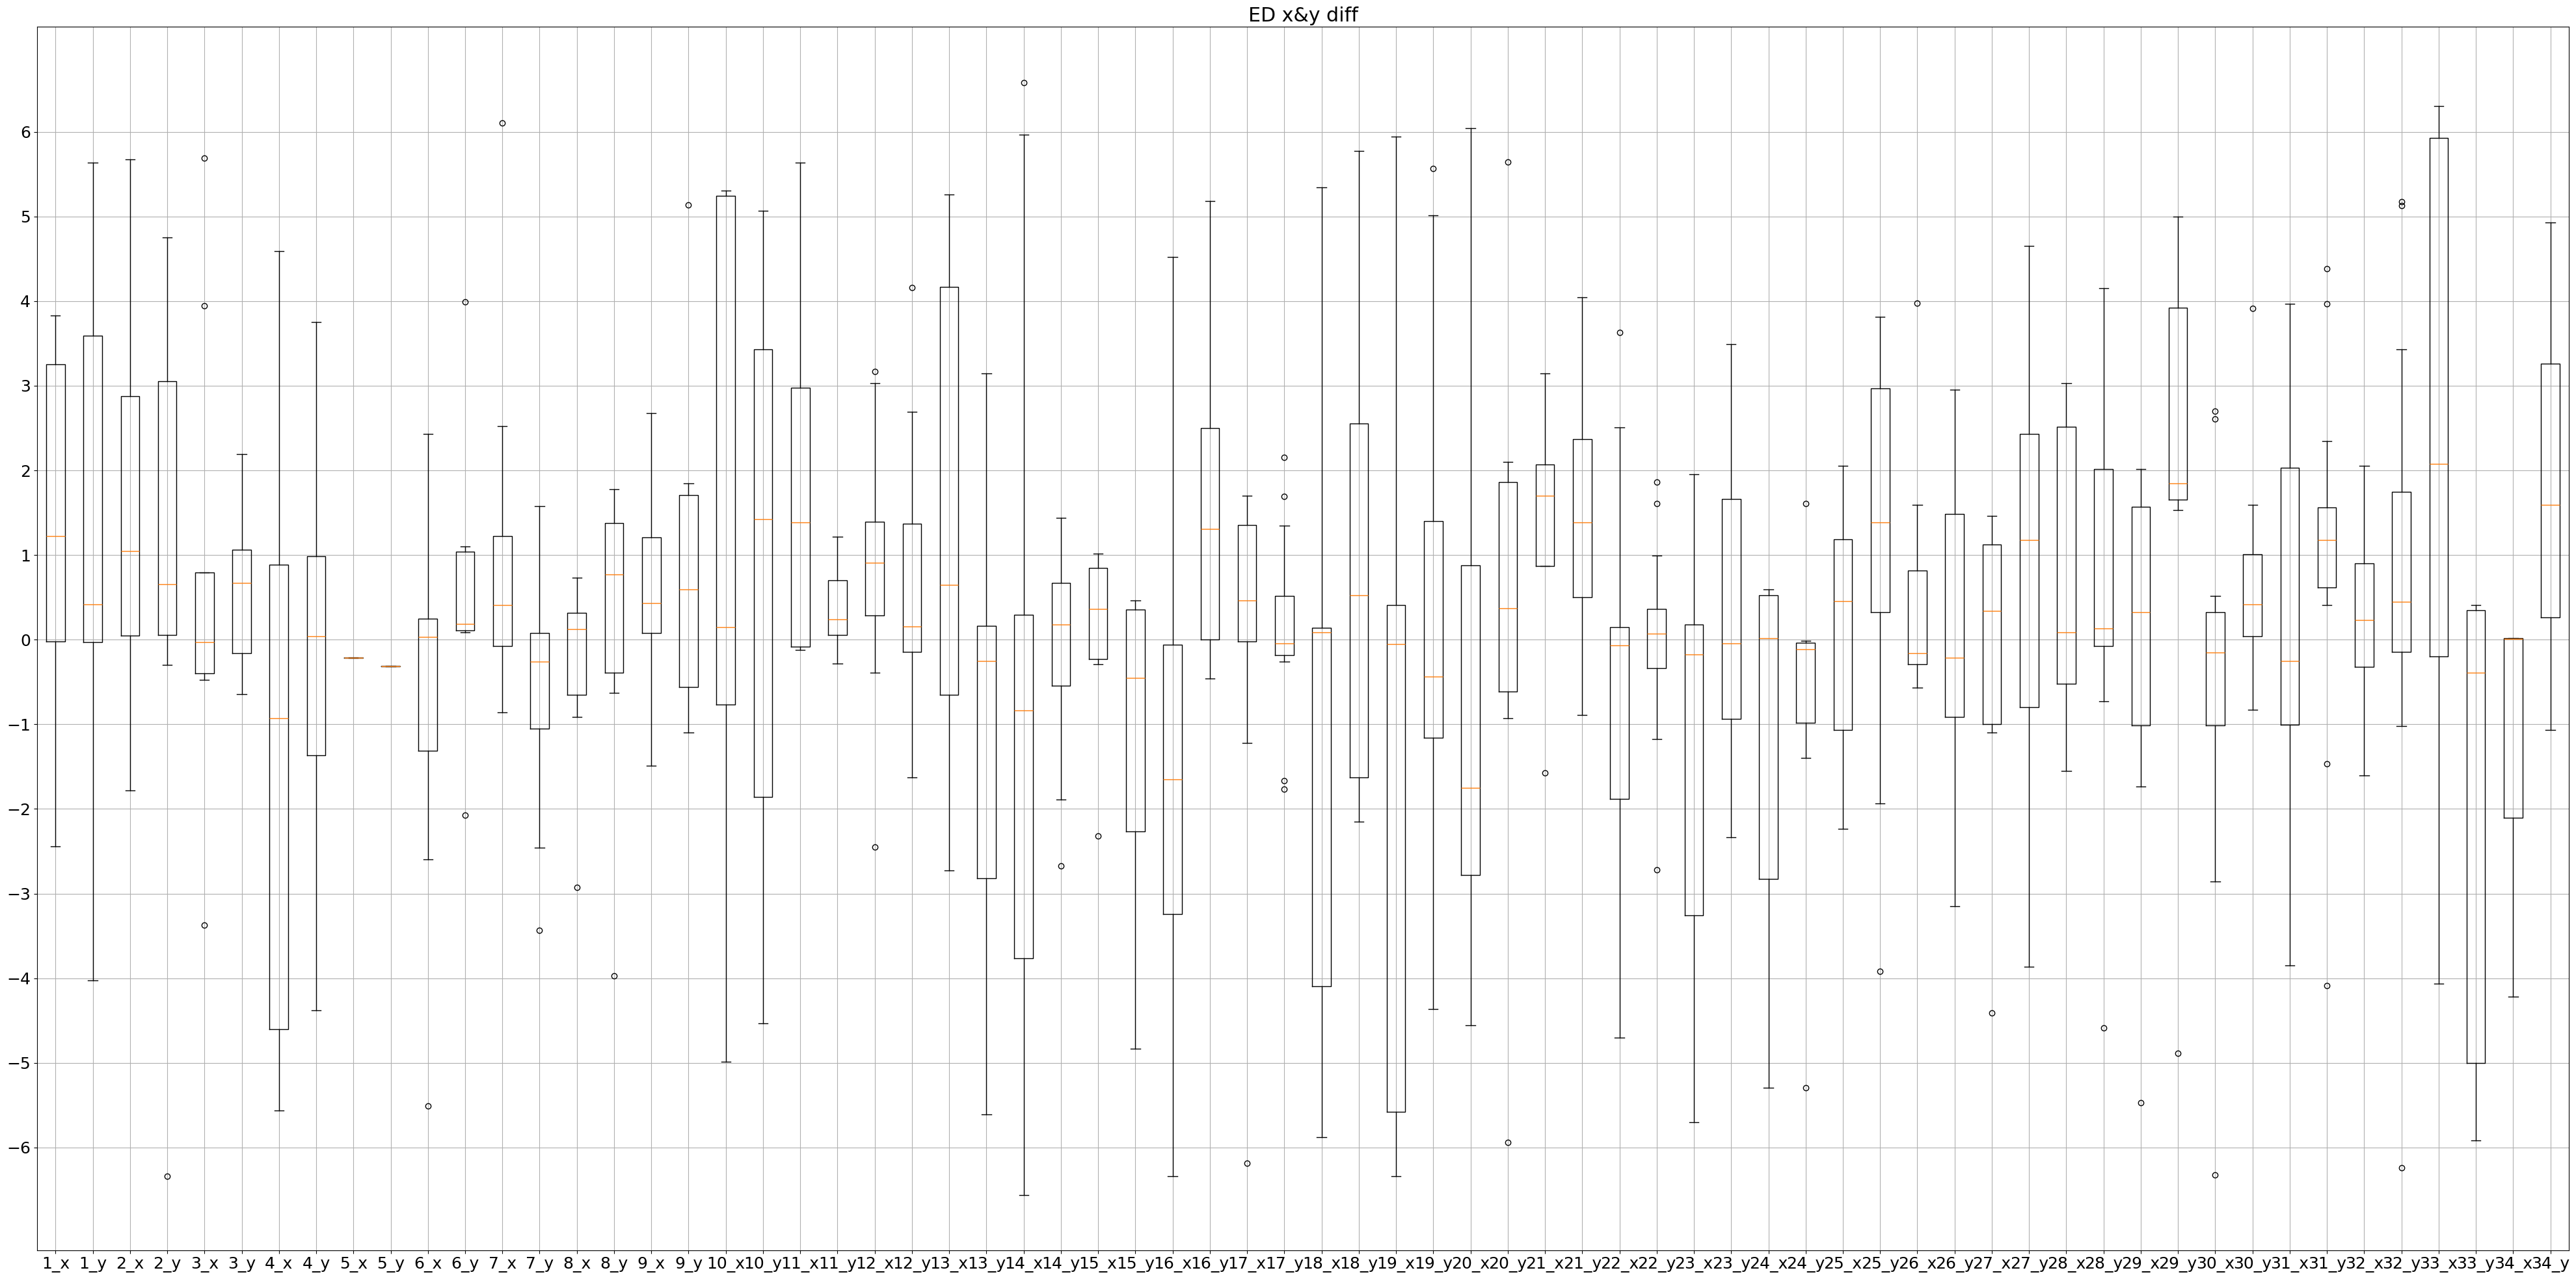

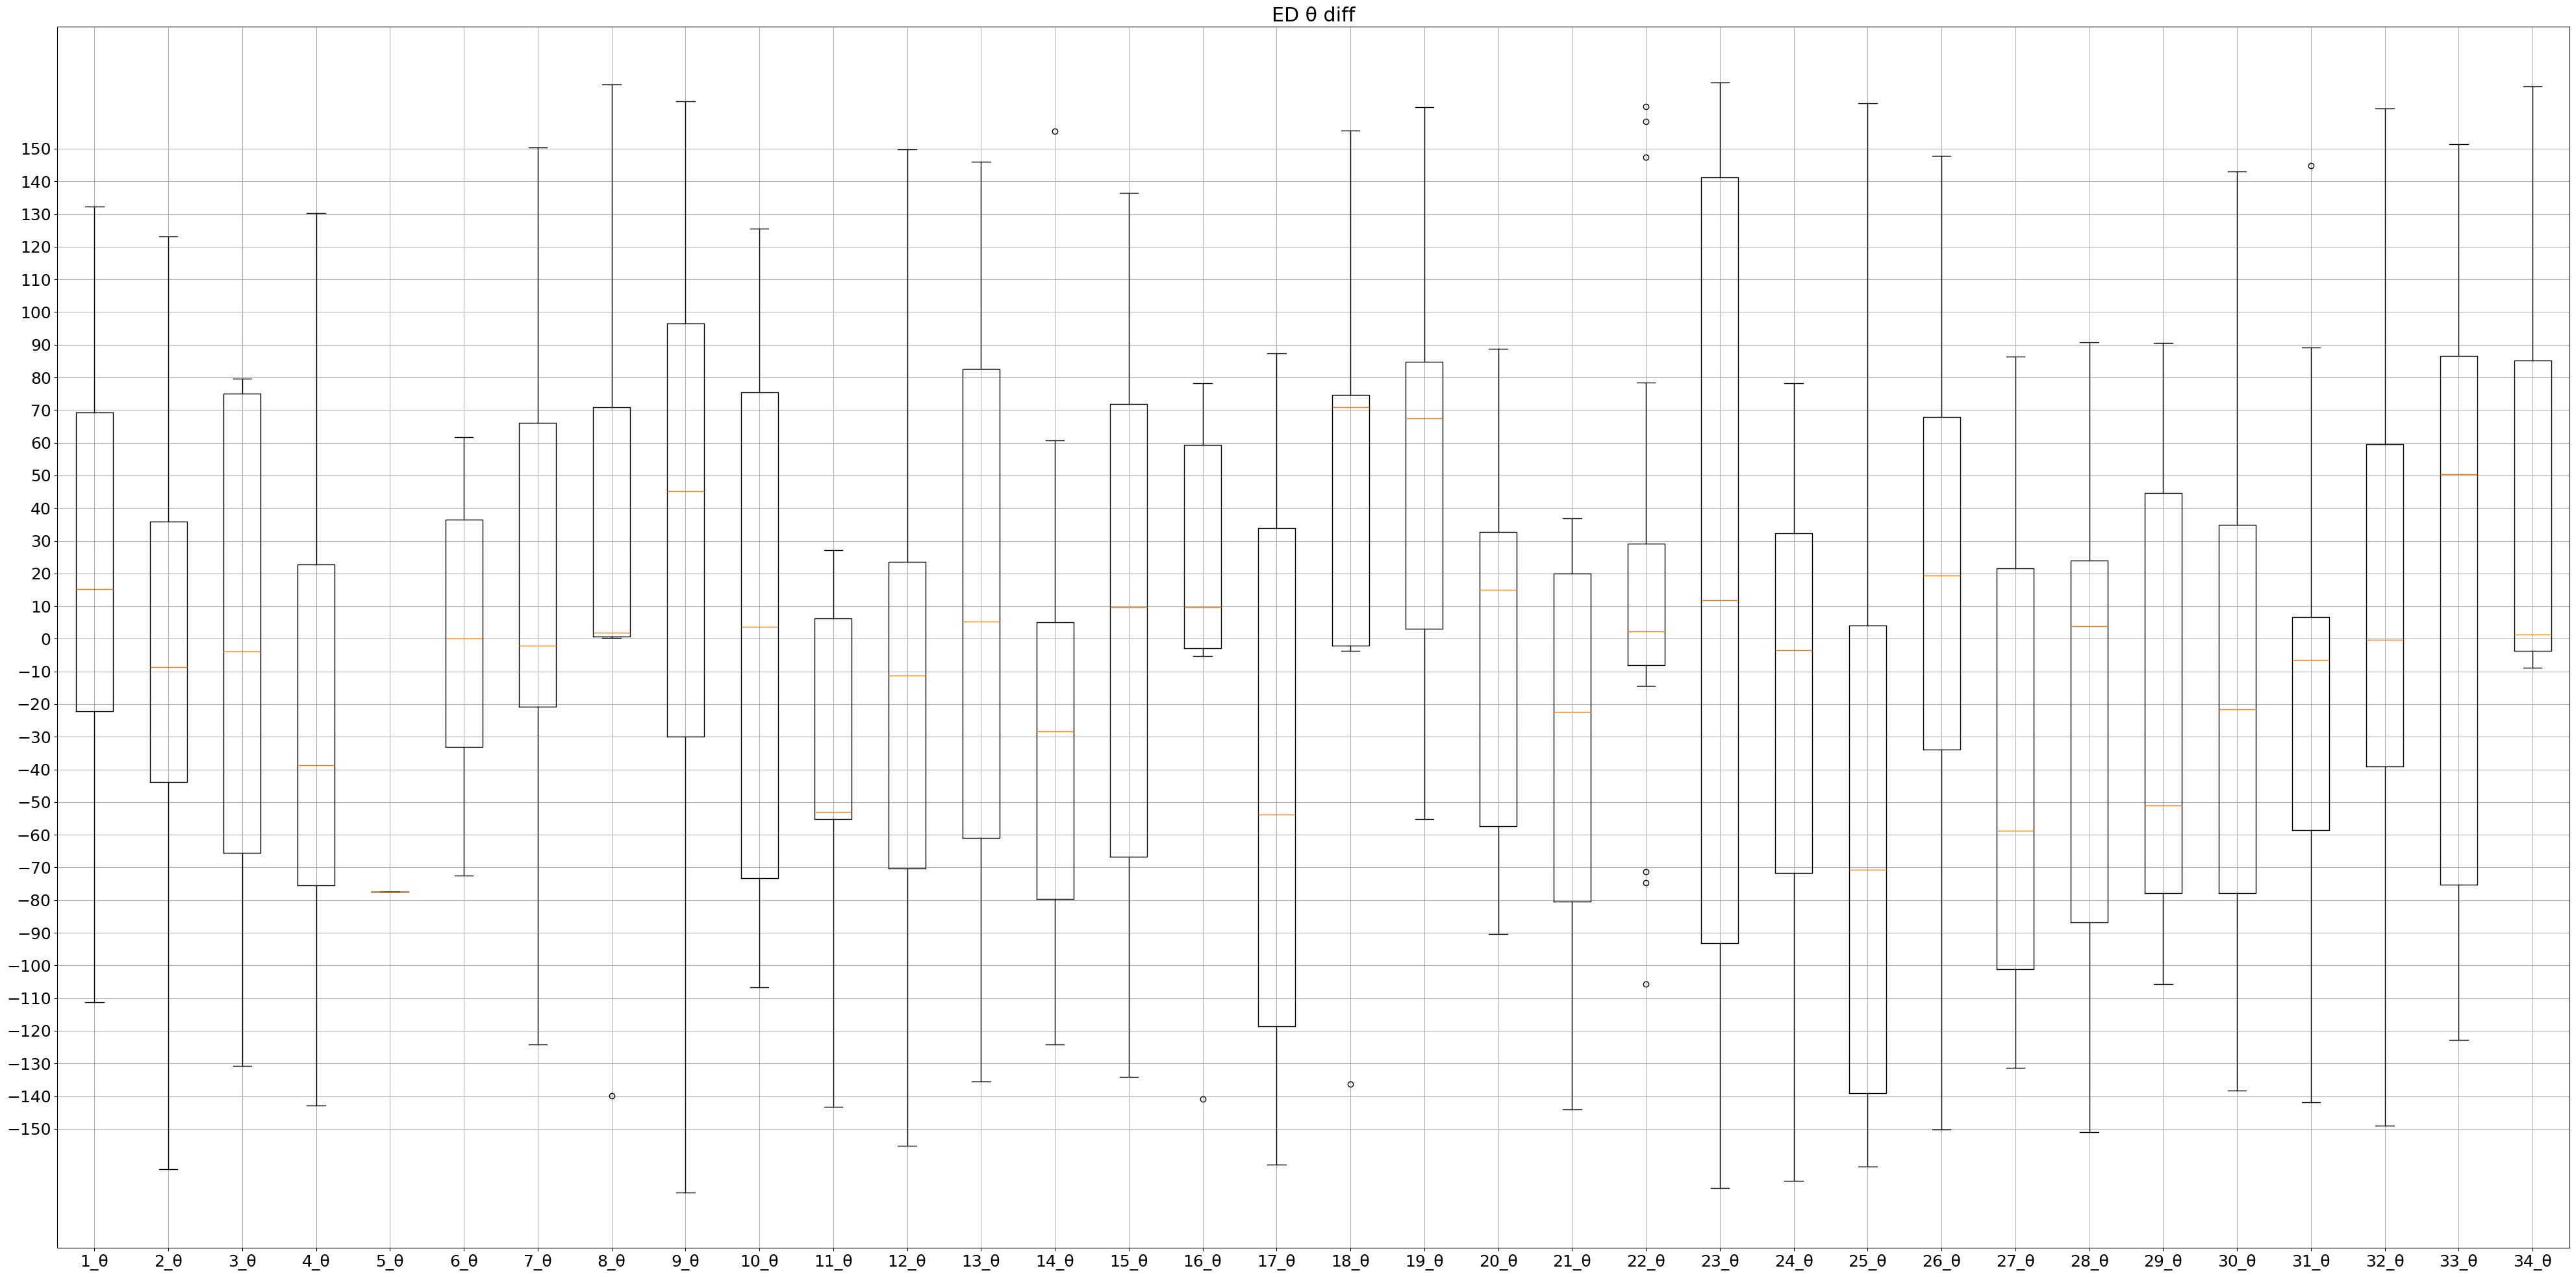

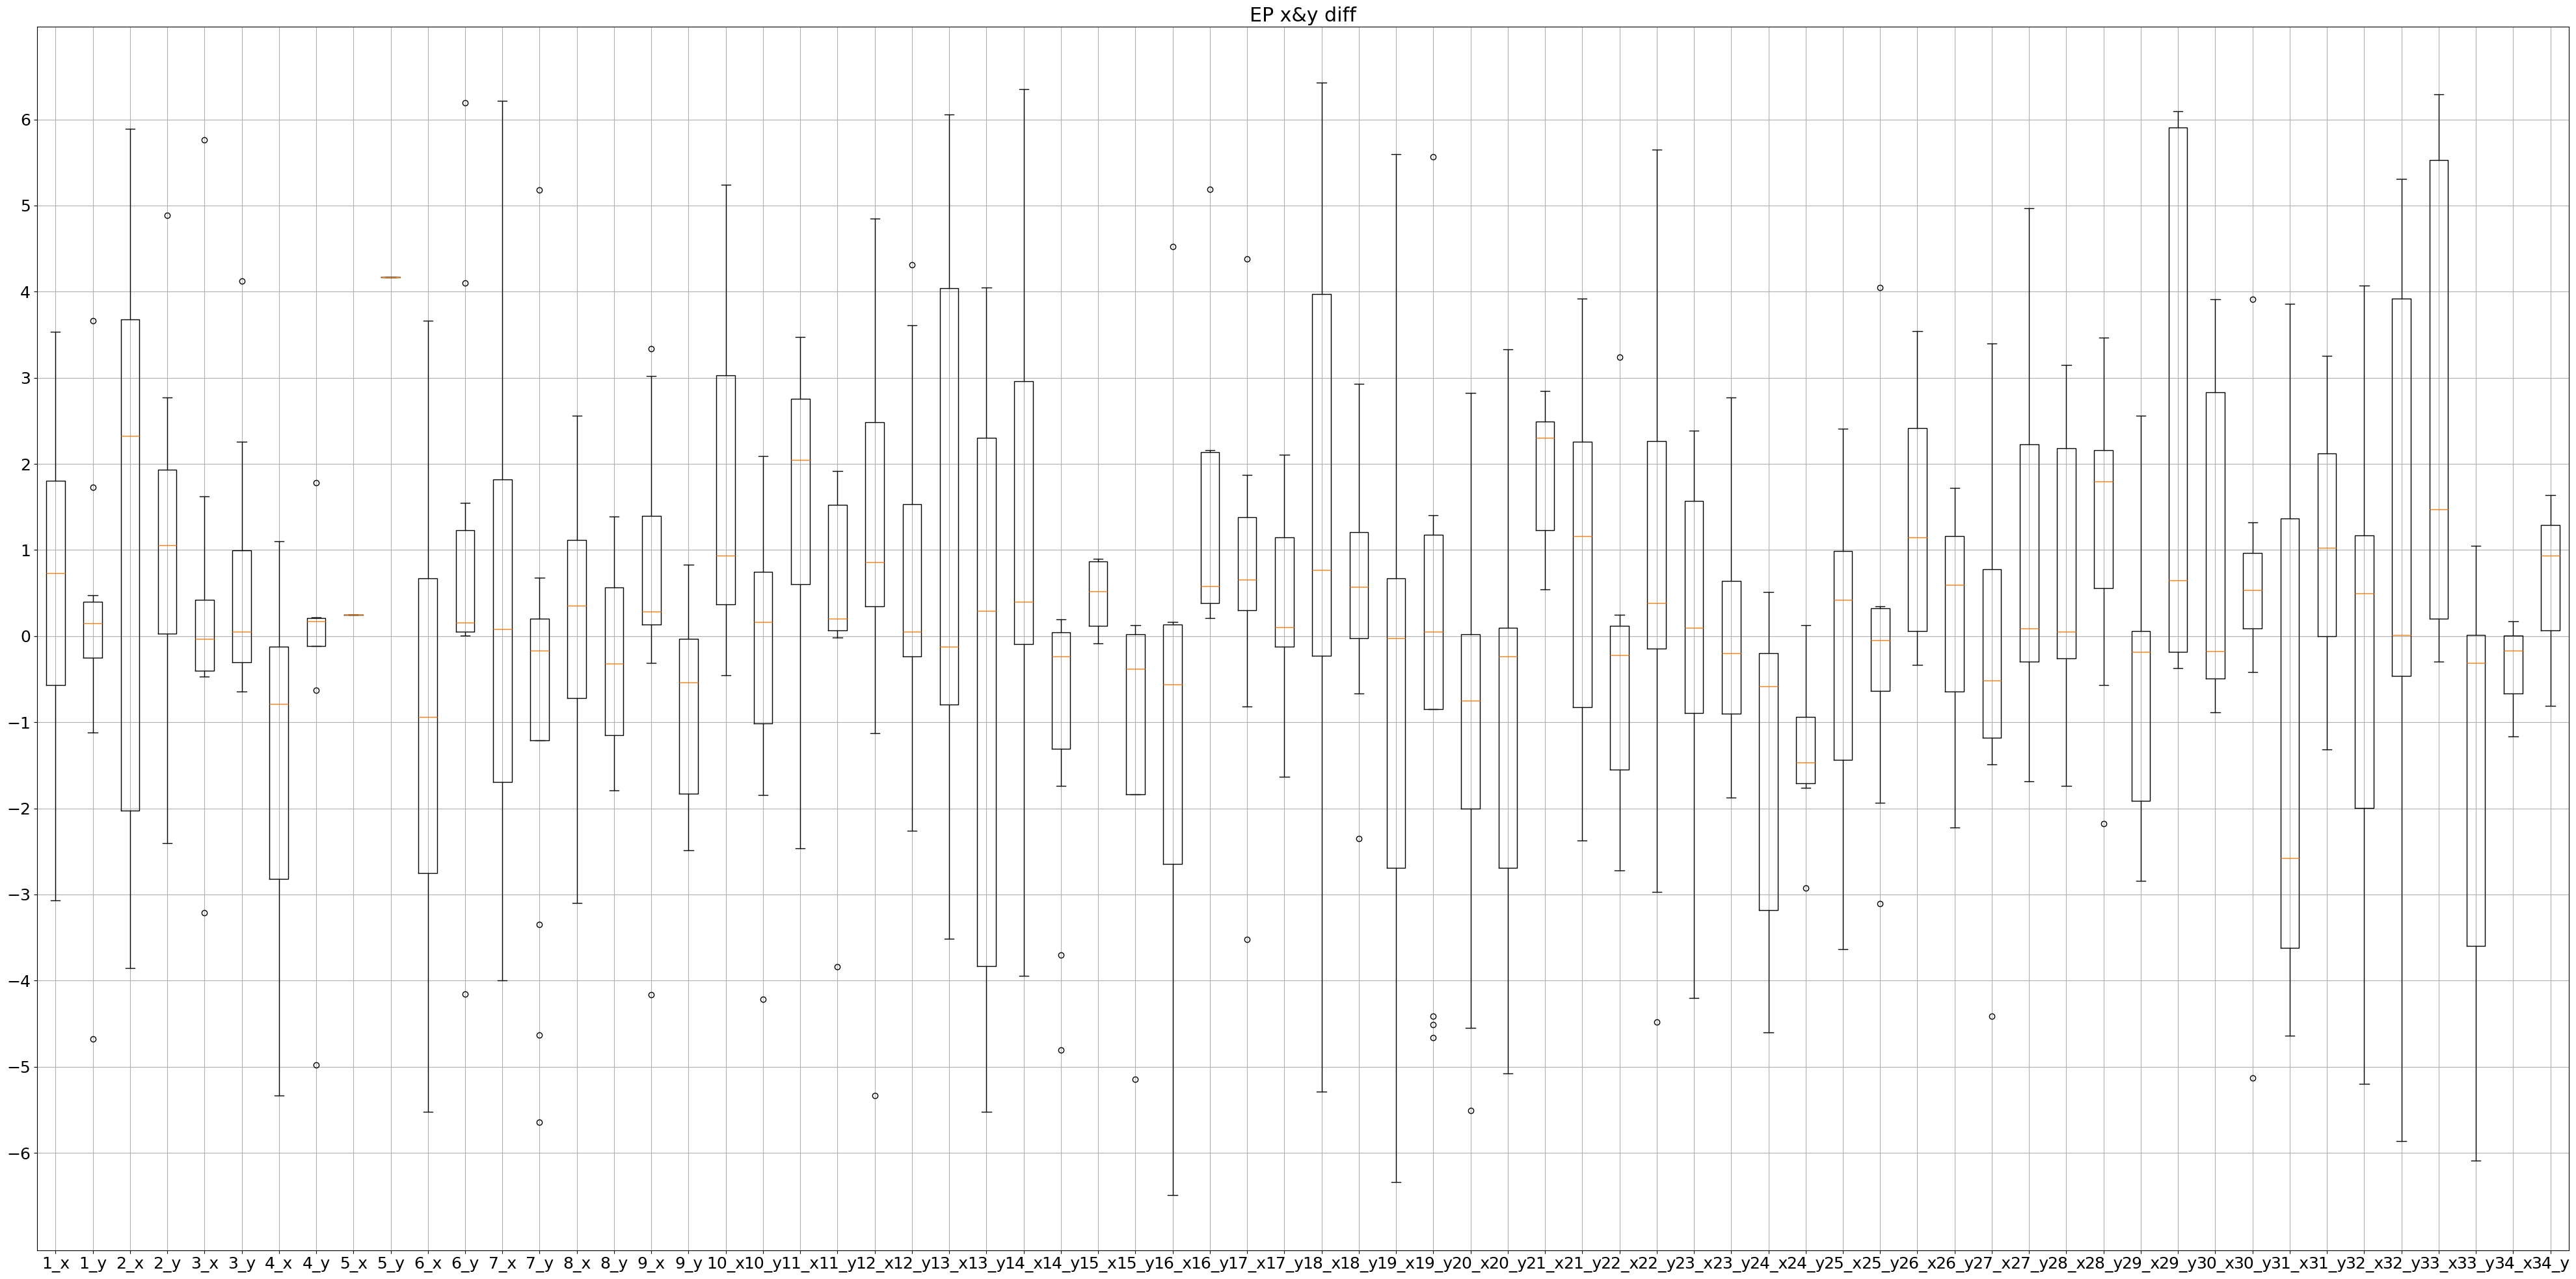

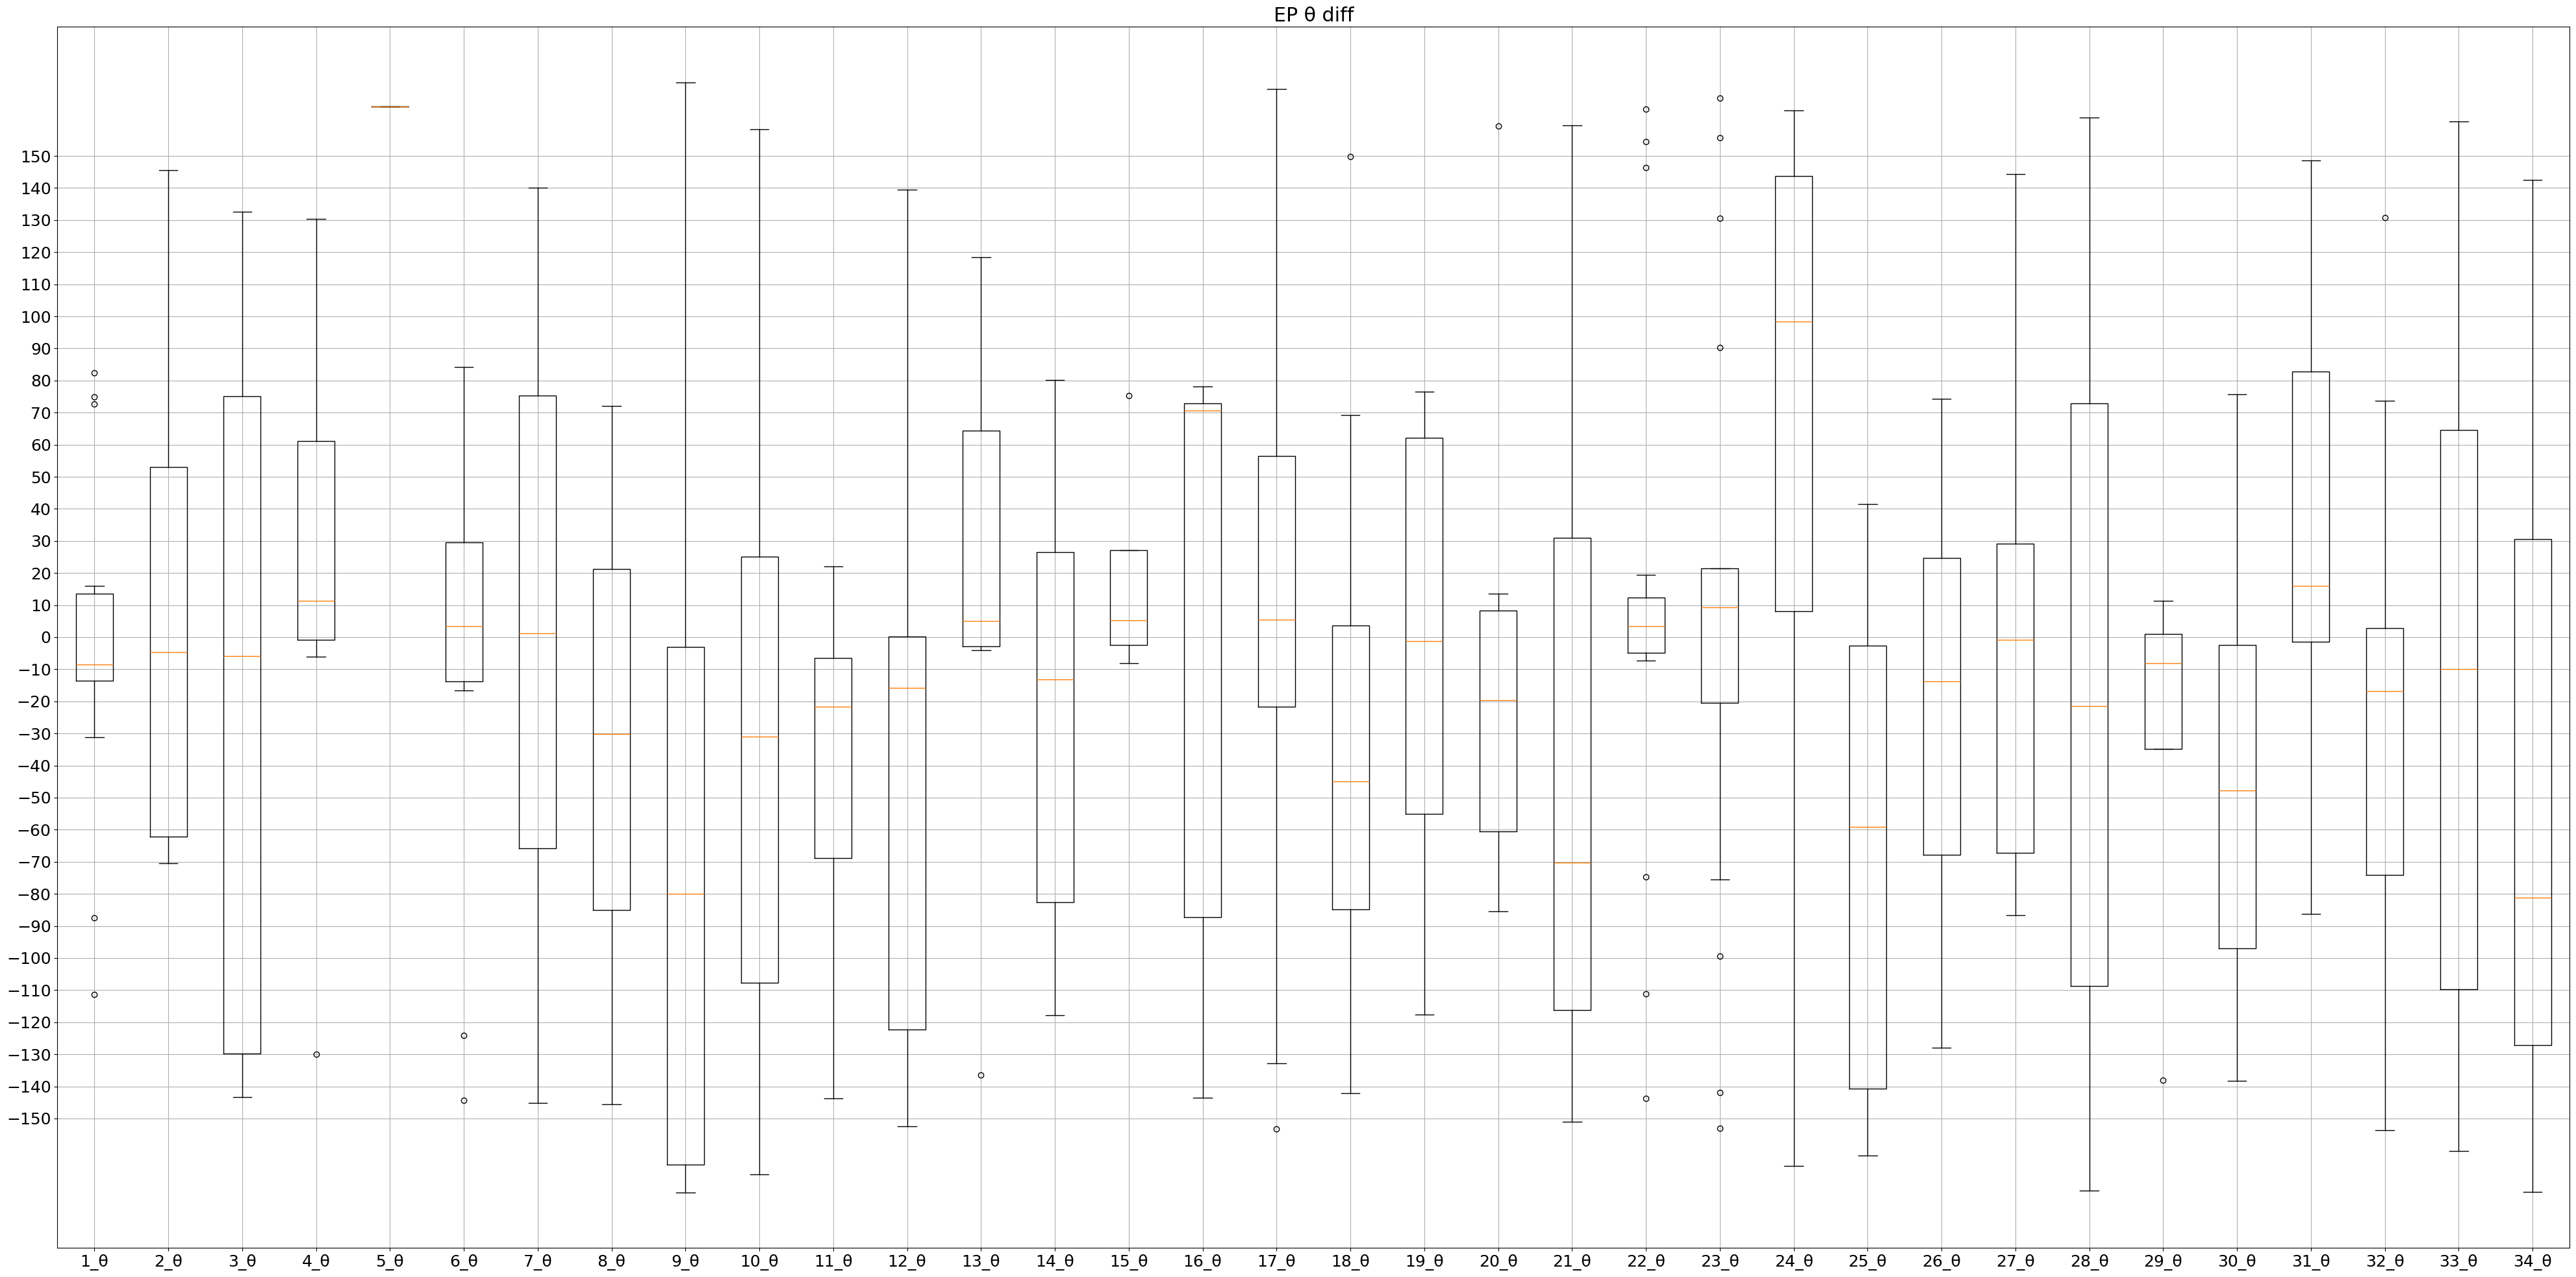

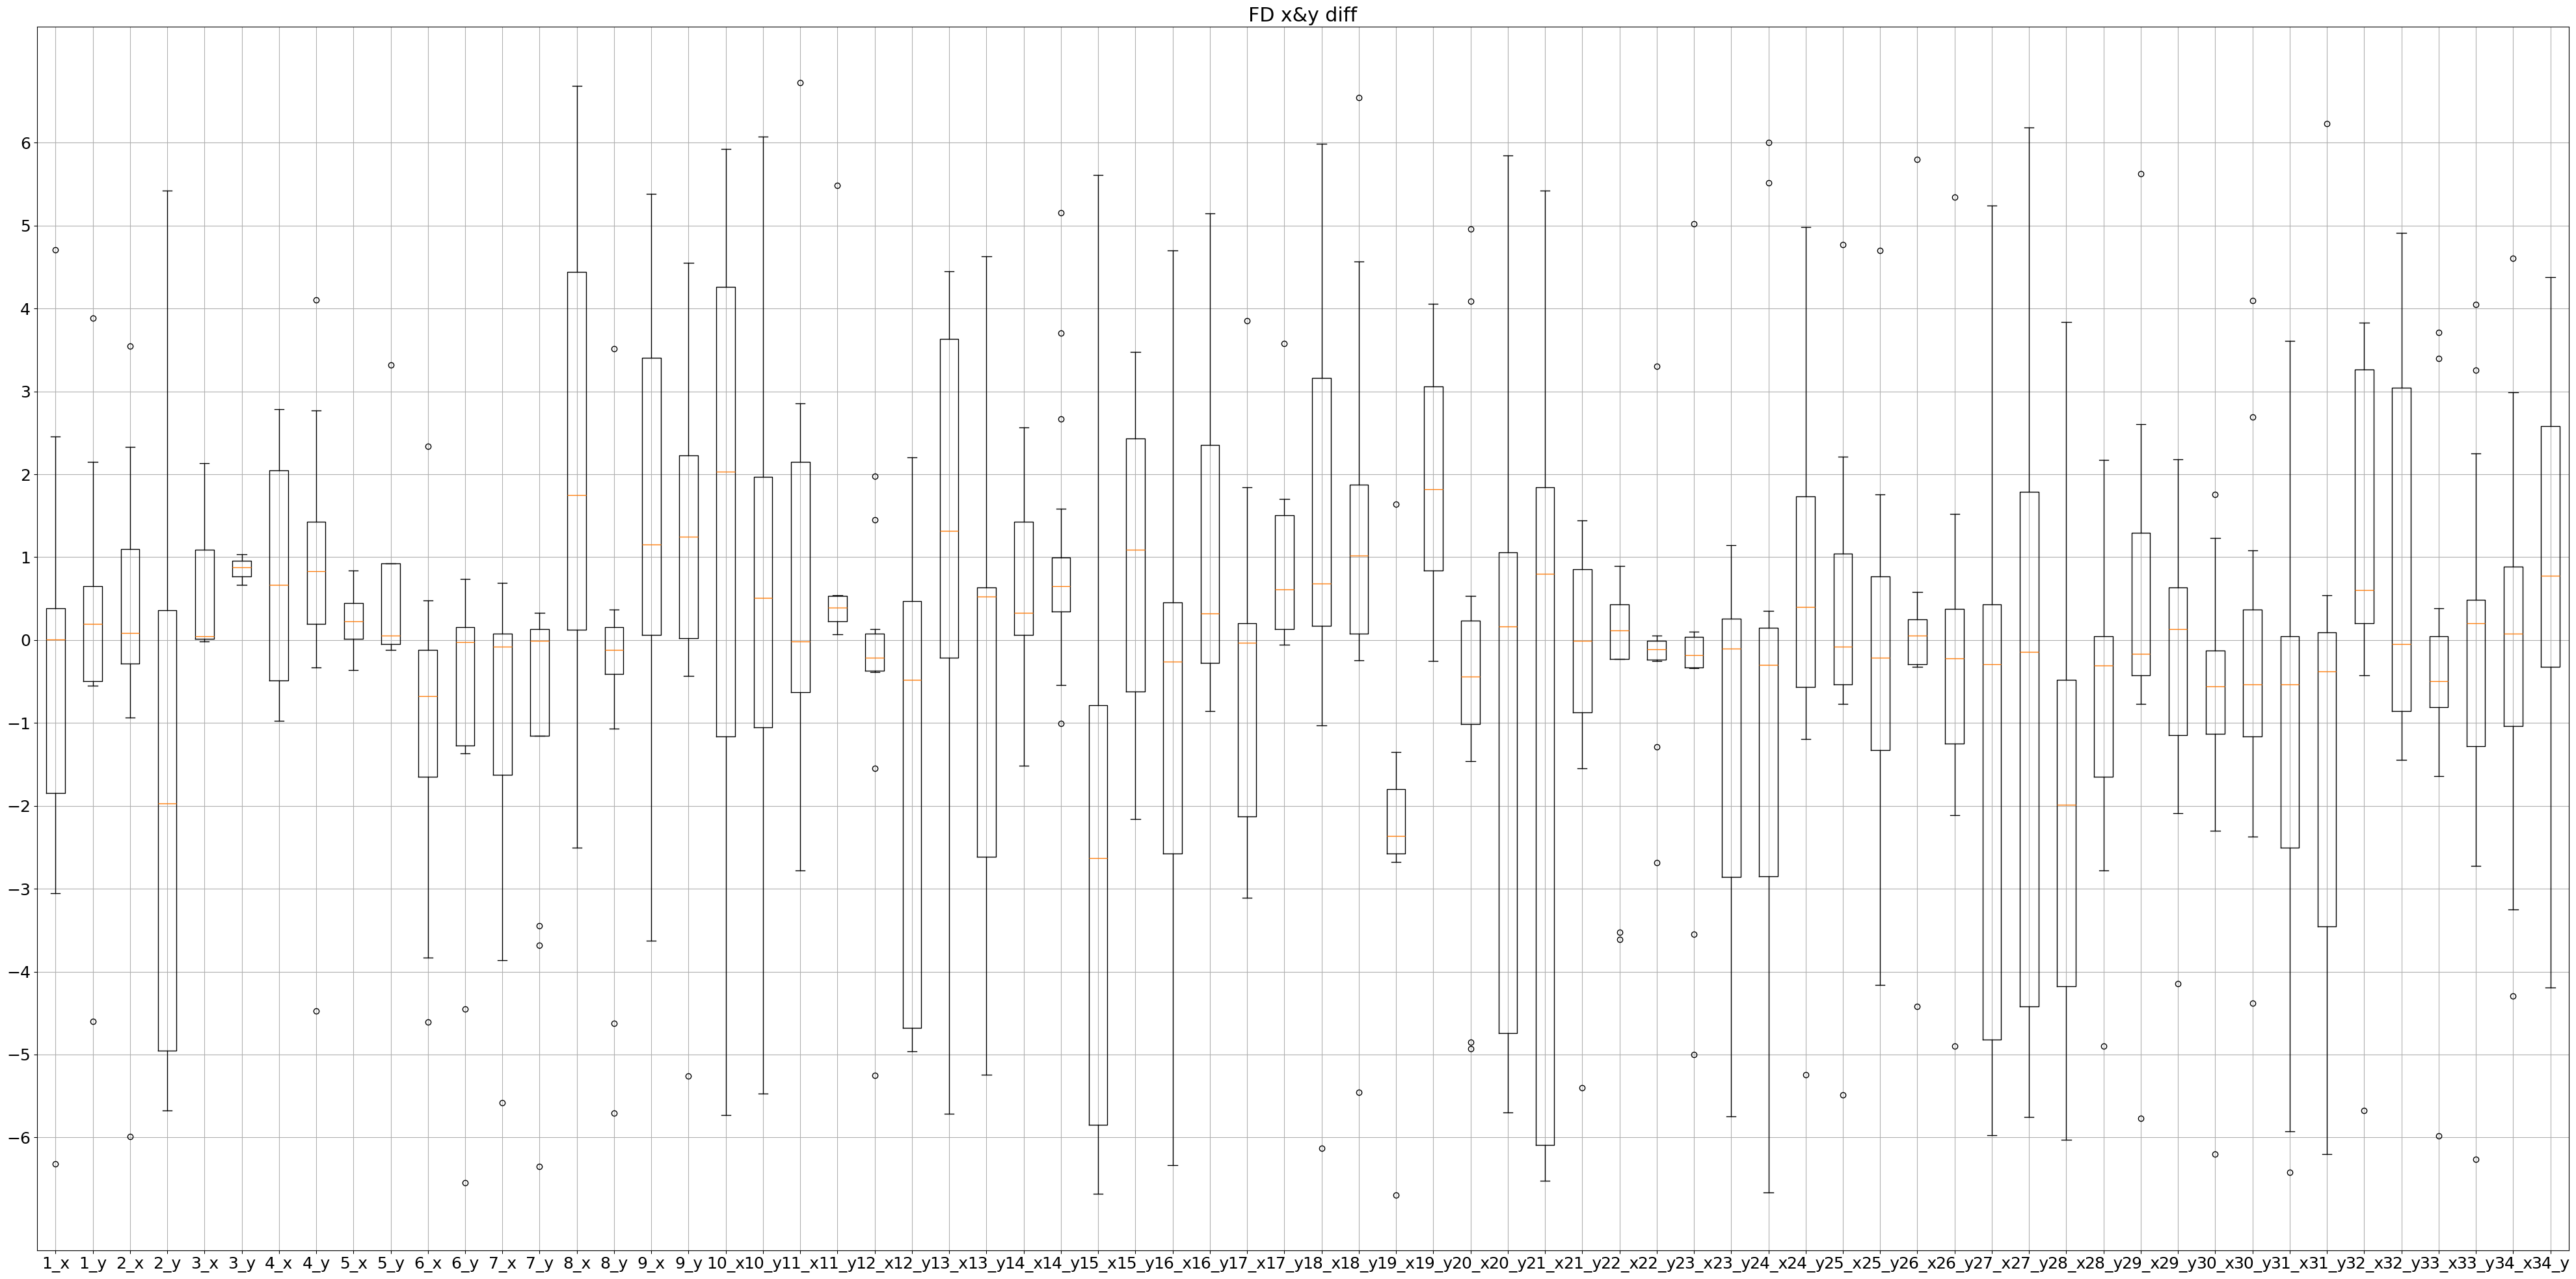

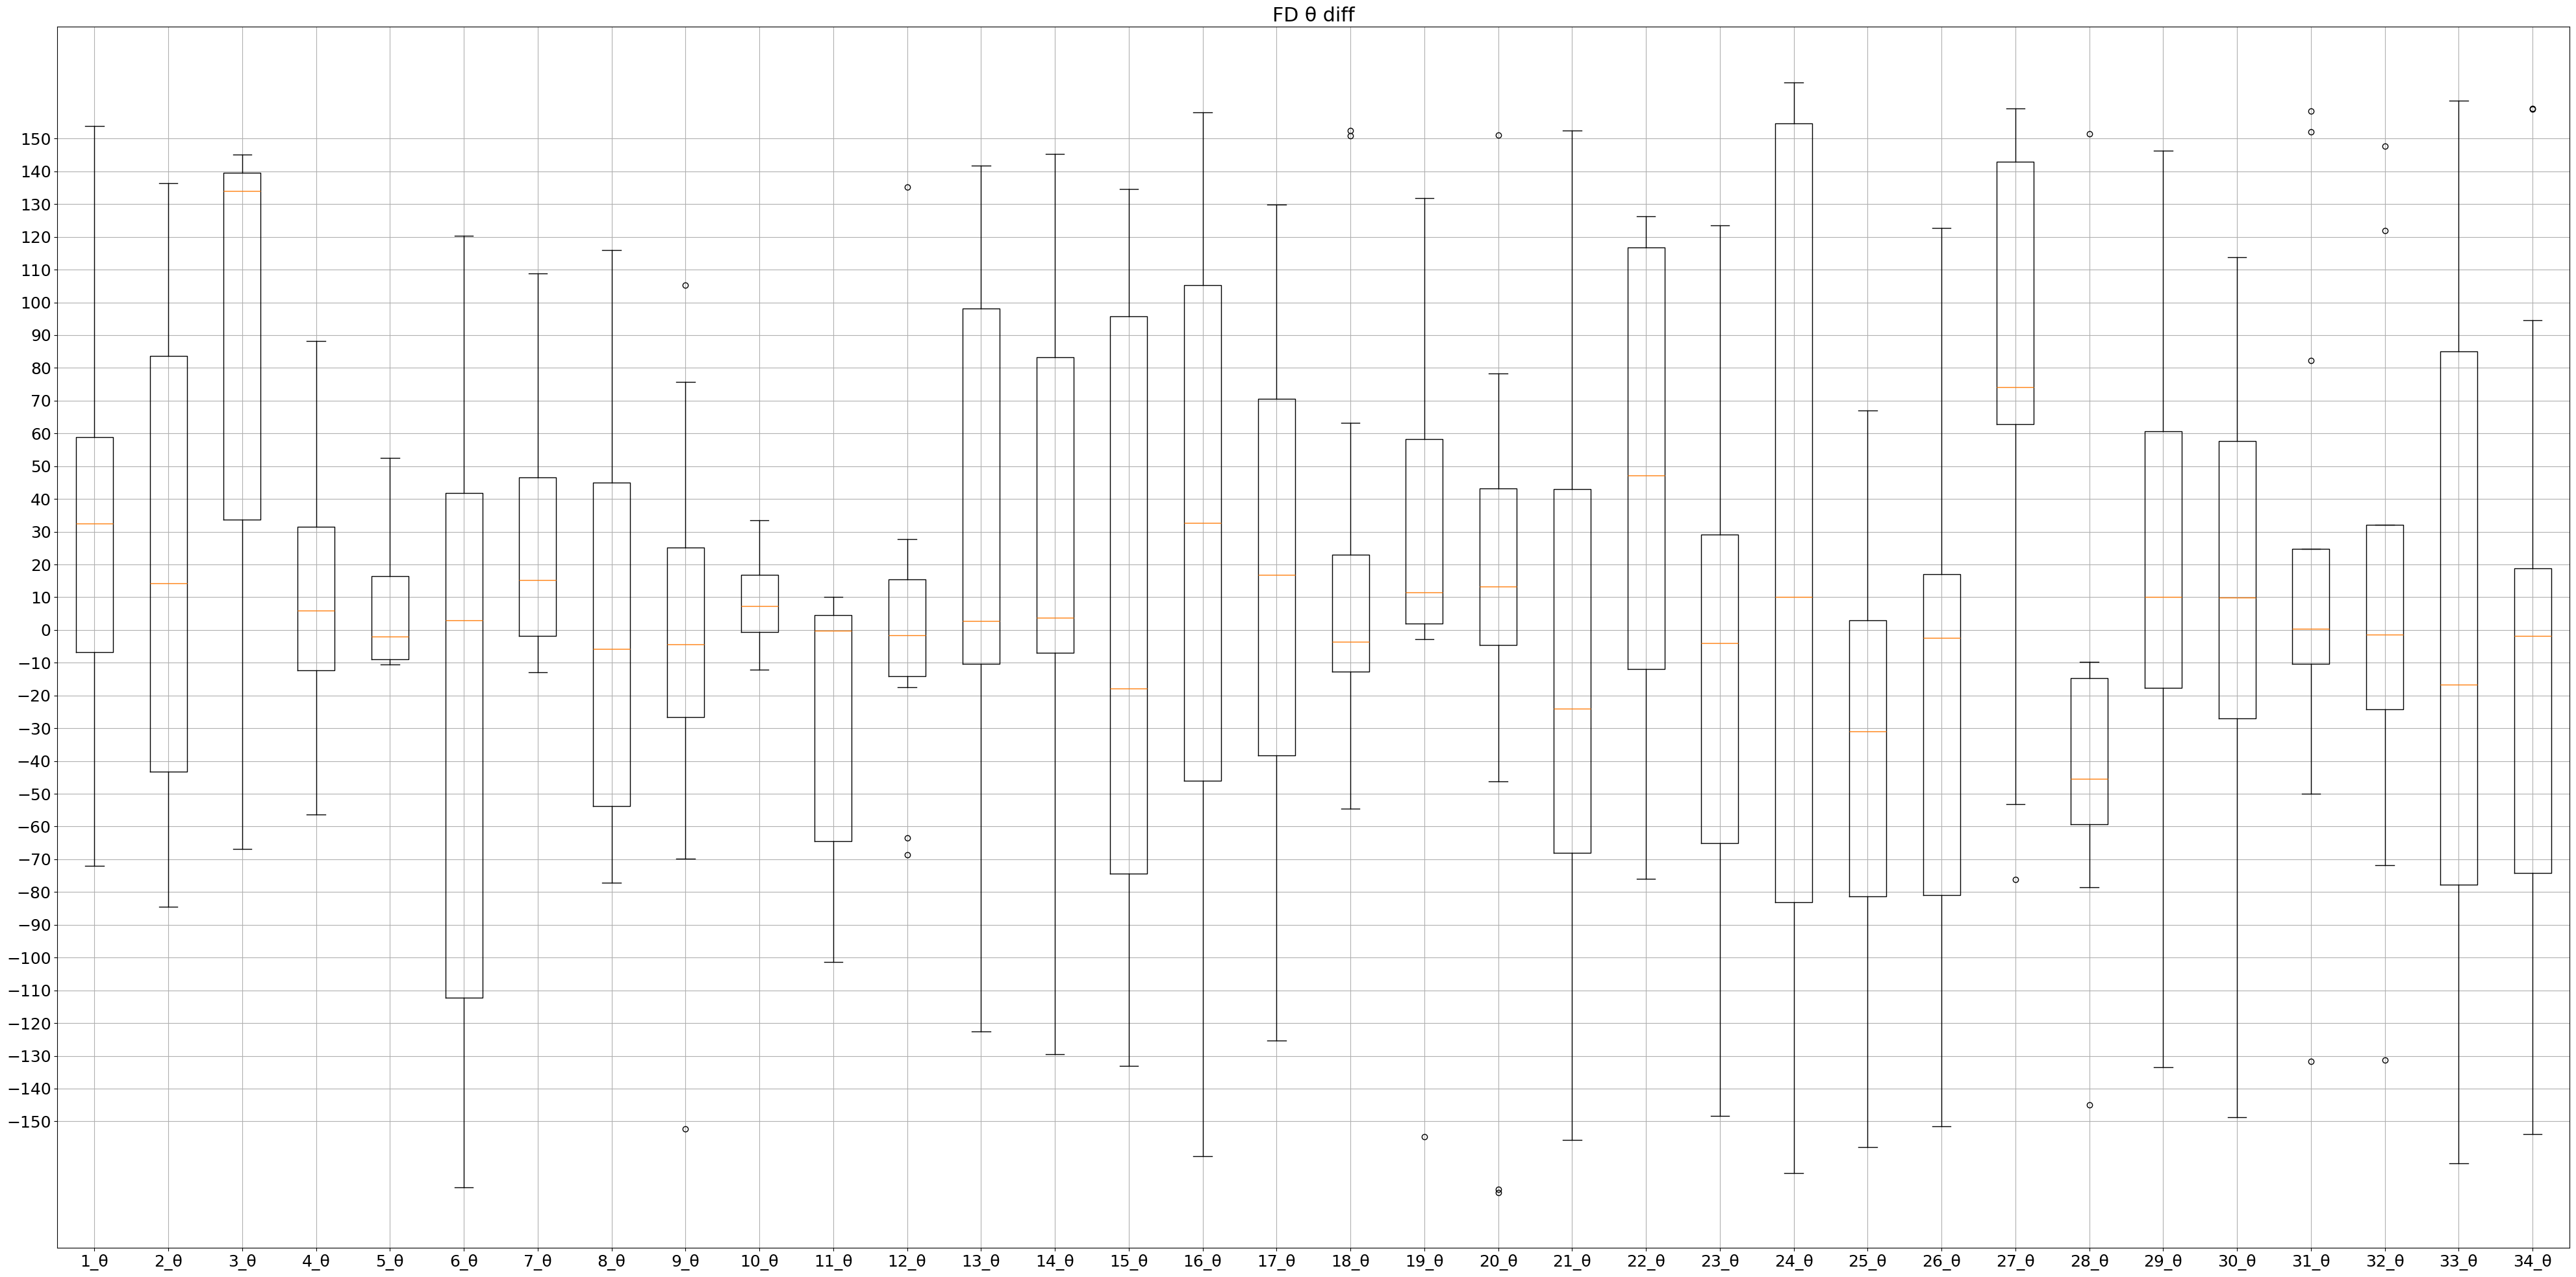

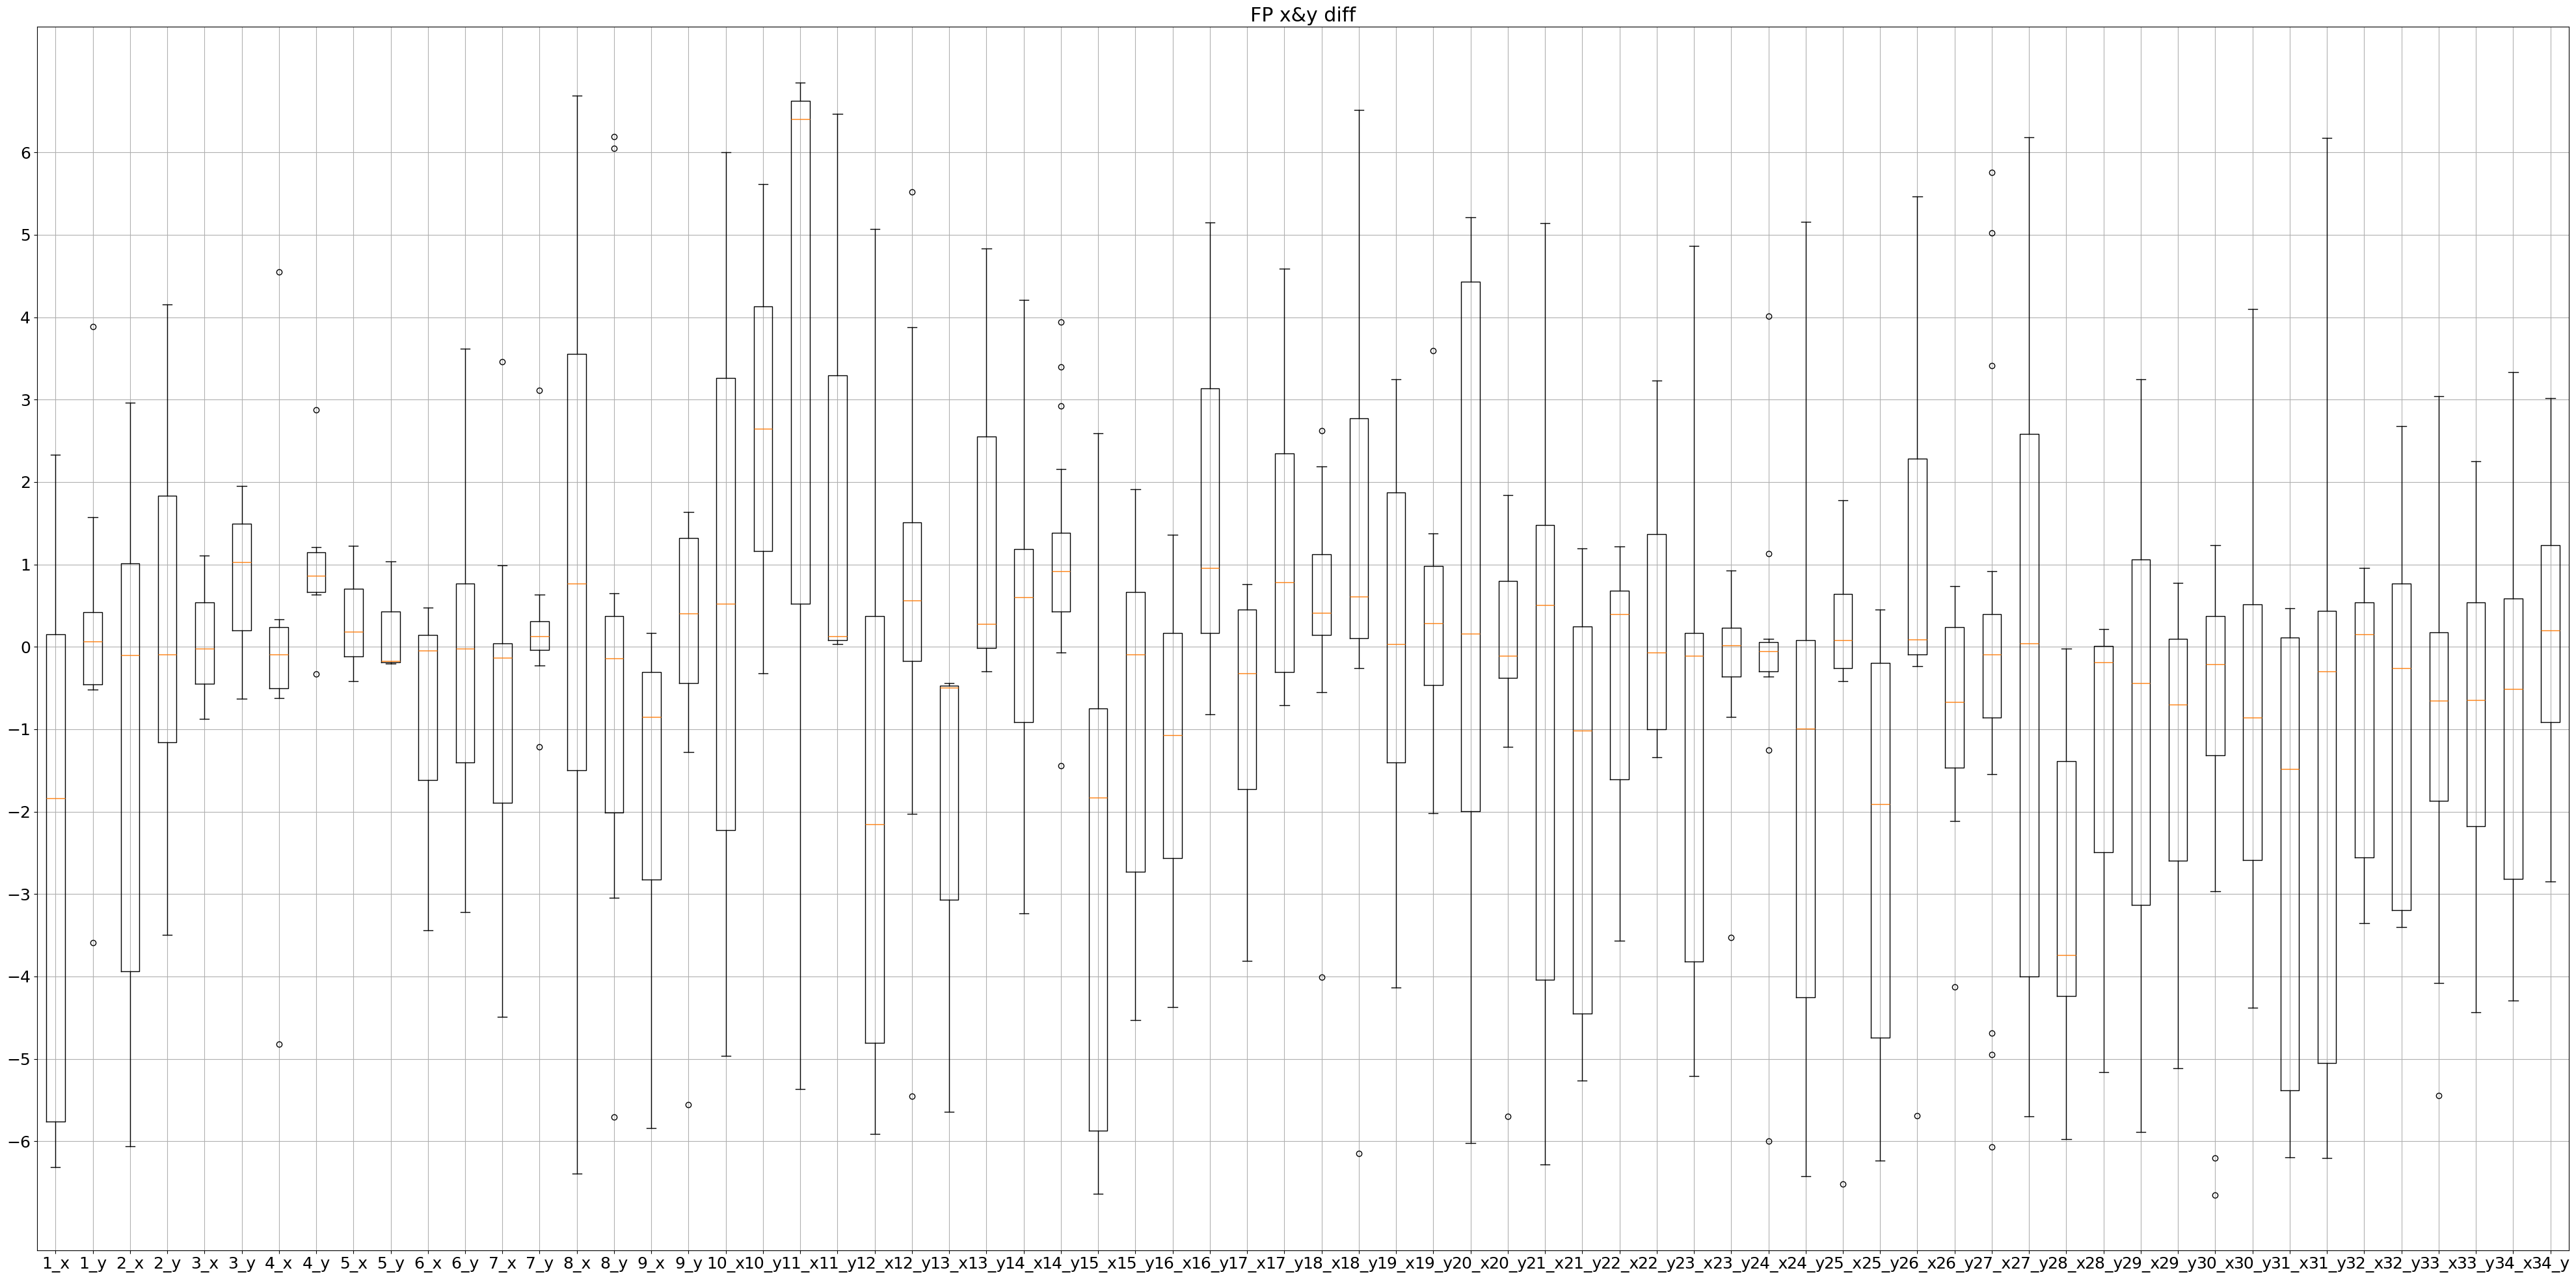

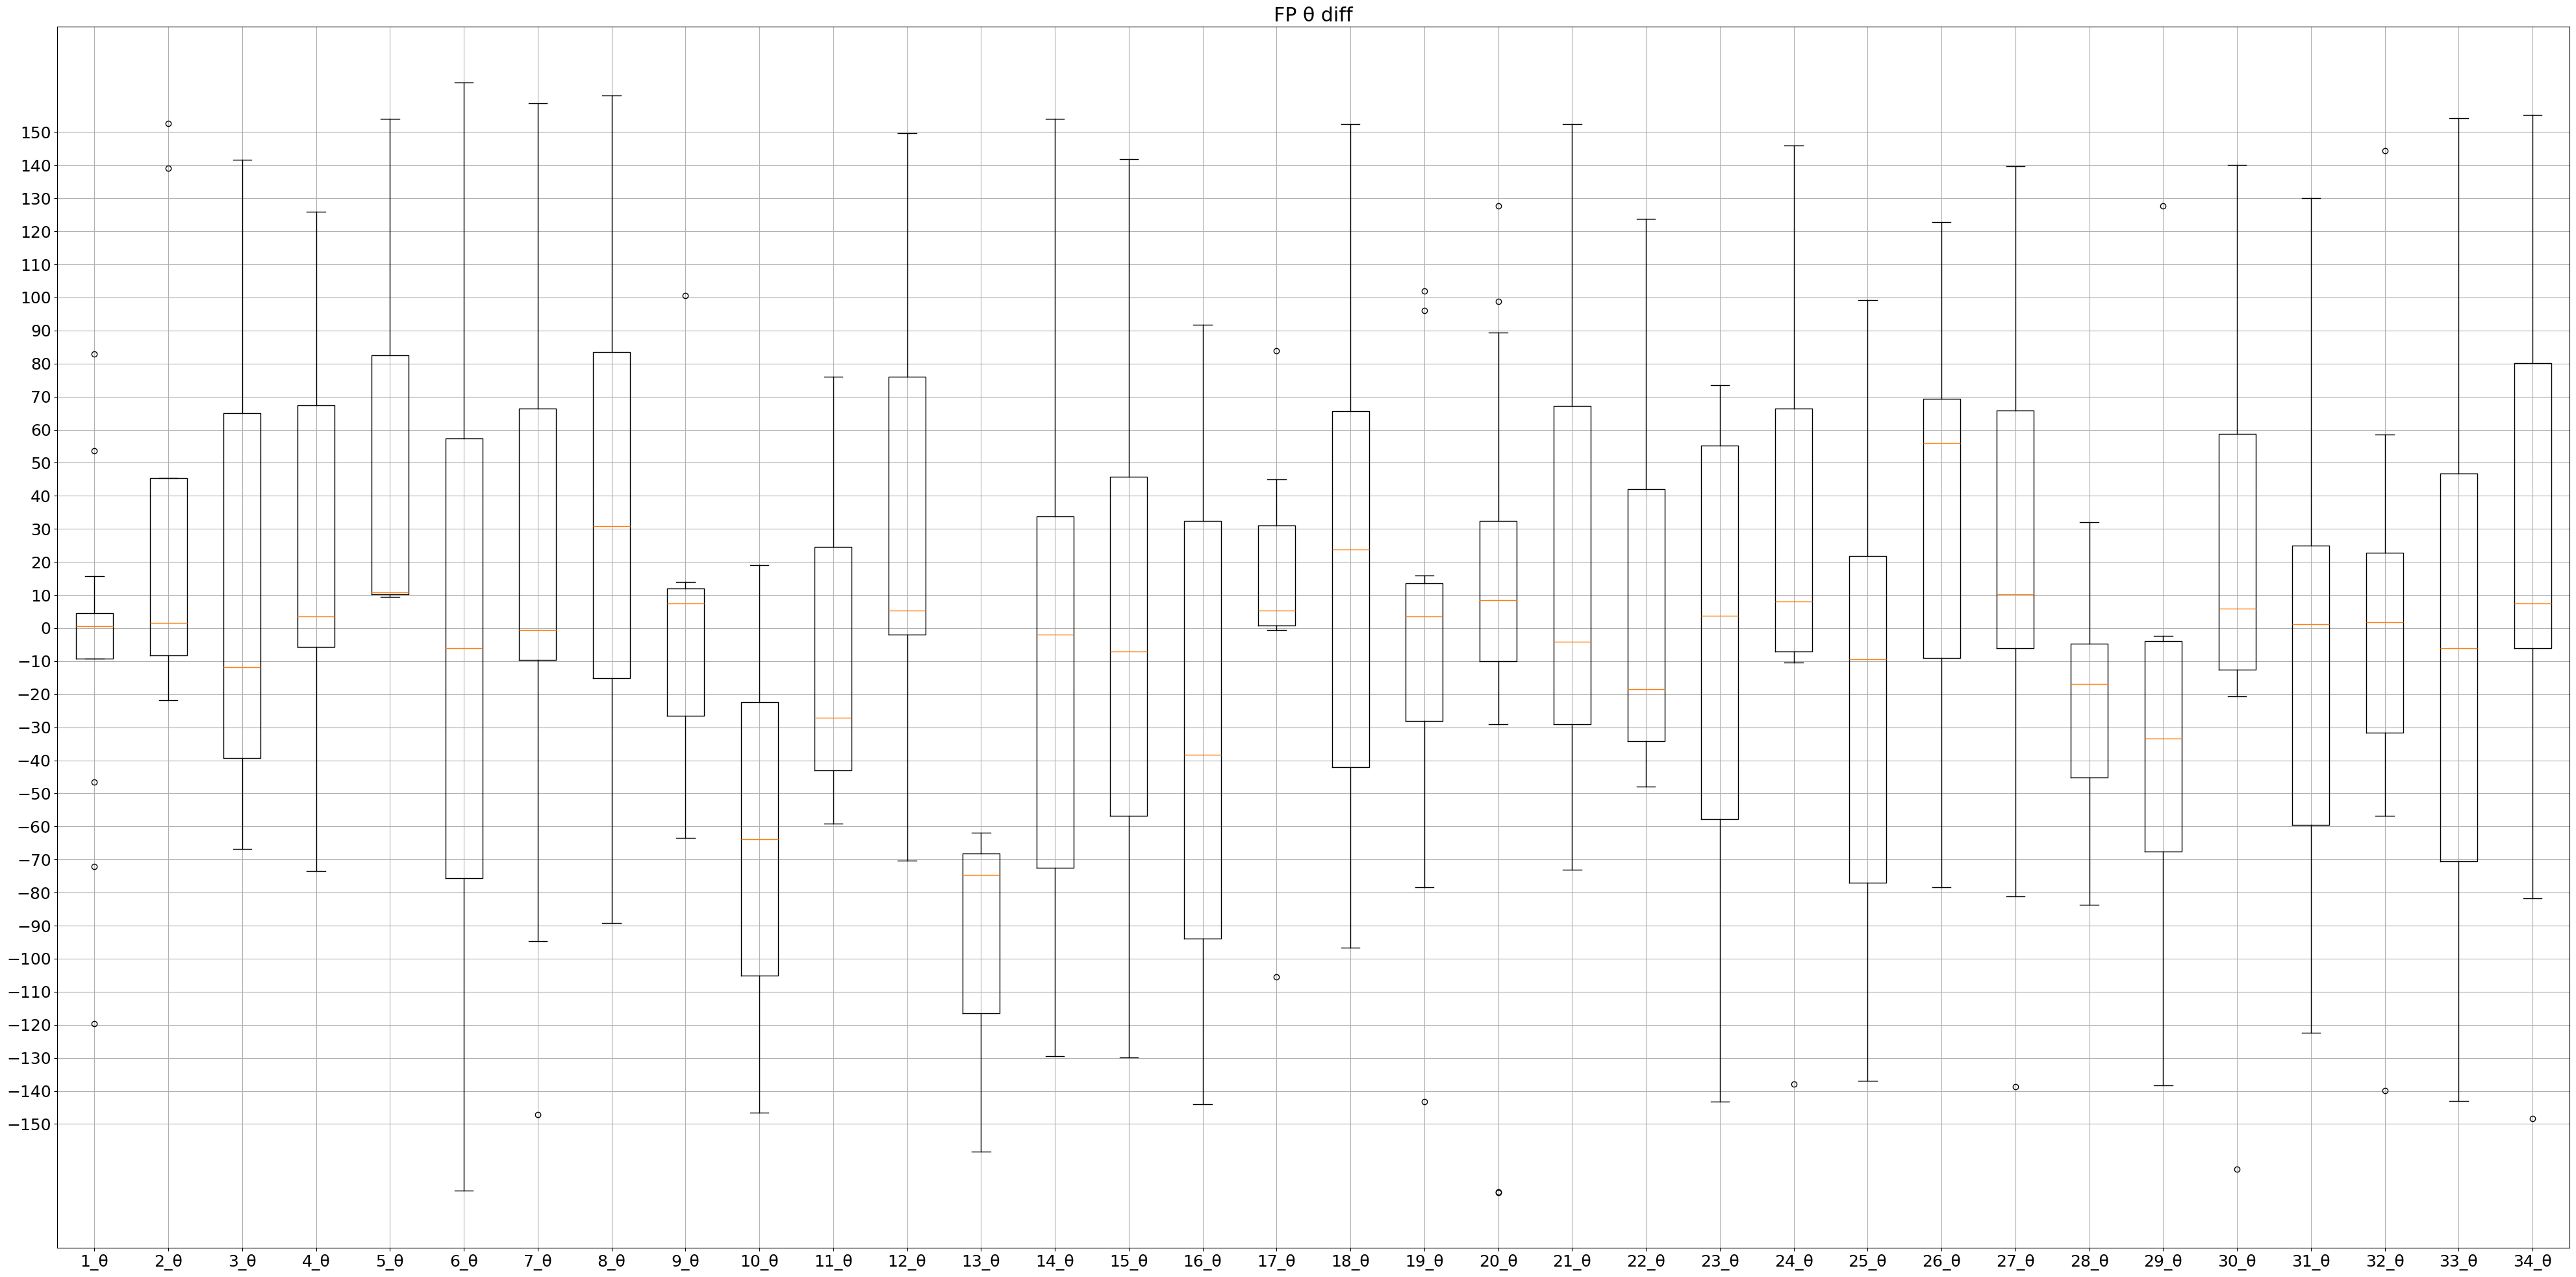

In [92]:
fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
ax.boxplot(ED_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('ED x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(ED_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('ED θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('EP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('EP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FD x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FD θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

# テスト

In [66]:
x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for i in range(n_gestures):
    x_ED_gesture[i+1] = []
    y_ED_gesture[i+1] = []
    theta_ED_gesture[i+1] = []
    x_EP_gesture[i+1] = []
    y_EP_gesture[i+1] = []
    theta_EP_gesture[i+1] = []
    x_FD_gesture[i+1] = []
    y_FD_gesture[i+1] = []
    theta_FD_gesture[i+1] = []
    x_FP_gesture[i+1] = []
    y_FP_gesture[i+1] = []
    theta_FP_gesture[i+1] = []

In [67]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        gesture = diff_list['gesture']
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[gesture].append(diff['x_distance'])
                y_ED_gesture[gesture].append(diff['y_distance'])
                theta_ED_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[gesture].append(diff['x_distance'])
                y_EP_gesture[gesture].append(diff['y_distance'])
                theta_EP_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[gesture].append(diff['x_distance'])
                y_FD_gesture[gesture].append(diff['y_distance'])
                theta_FD_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[gesture].append(diff['x_distance'])
                y_FP_gesture[gesture].append(diff['y_distance'])
                theta_FP_gesture[gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': 1, 'trial': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 20, 'x_distance': 0.6355043368060231, 'y_distance': 0.2968244295037339, 'theta_distance': 126.80880311567324}, {'session1_cluster': 1, 'session2_cluster': 20, 'x_distance': 0.8046718794426484, 'y_distance': 0.20238527097442738, 'theta_distance': 6.995579169369314}, {'session1_cluster': 2, 'session2_cluster': 20, 'x_distance': 0.34048013321548076, 'y_distance': 0.3659353932278293, 'theta_distance': -18.365583335385004}, {'session1_cluster': 30, 'session2_cluster': 10, 'x_distance': -0.02485568984674824, 'y_distance': -0.05747863767190342, 'theta_distance': 9.093665741959128}]}
{'subject': 1, 'gesture': 1, 'trial': 1, 'electrode_place': 'EP', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 31, 'x_distance': 1.3986981499463313, 'y_distance': -3.0642257542032985, 'theta_distance': -72.11244356834571}, {'session1_cluster': 30, 'session2_cluster':

In [68]:
ED_xy_list = []
EP_xy_list = []
FD_xy_list = []
FP_xy_list = []
for i in range(n_gestures):
    ED_xy_list.append(x_ED_gesture[i+1])
    ED_xy_list.append(y_ED_gesture[i+1])
    # ED_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_xy_list.append(x_EP_gesture[i+1])
    EP_xy_list.append(y_EP_gesture[i+1])
    # EP_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_xy_list.append(x_FD_gesture[i+1])
    FD_xy_list.append(y_FD_gesture[i+1])
    # FD_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_xy_list.append(x_FP_gesture[i+1])
    FP_xy_list.append(y_FP_gesture[i+1])
    # FP_list.append(theta_FP_gesture[i+1])

ED_theta_list = []
EP_theta_list = []
FD_theta_list = []
FP_theta_list = []
for i in range(n_gestures):
    ED_theta_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_theta_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_theta_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_theta_list.append(theta_FP_gesture[i+1])


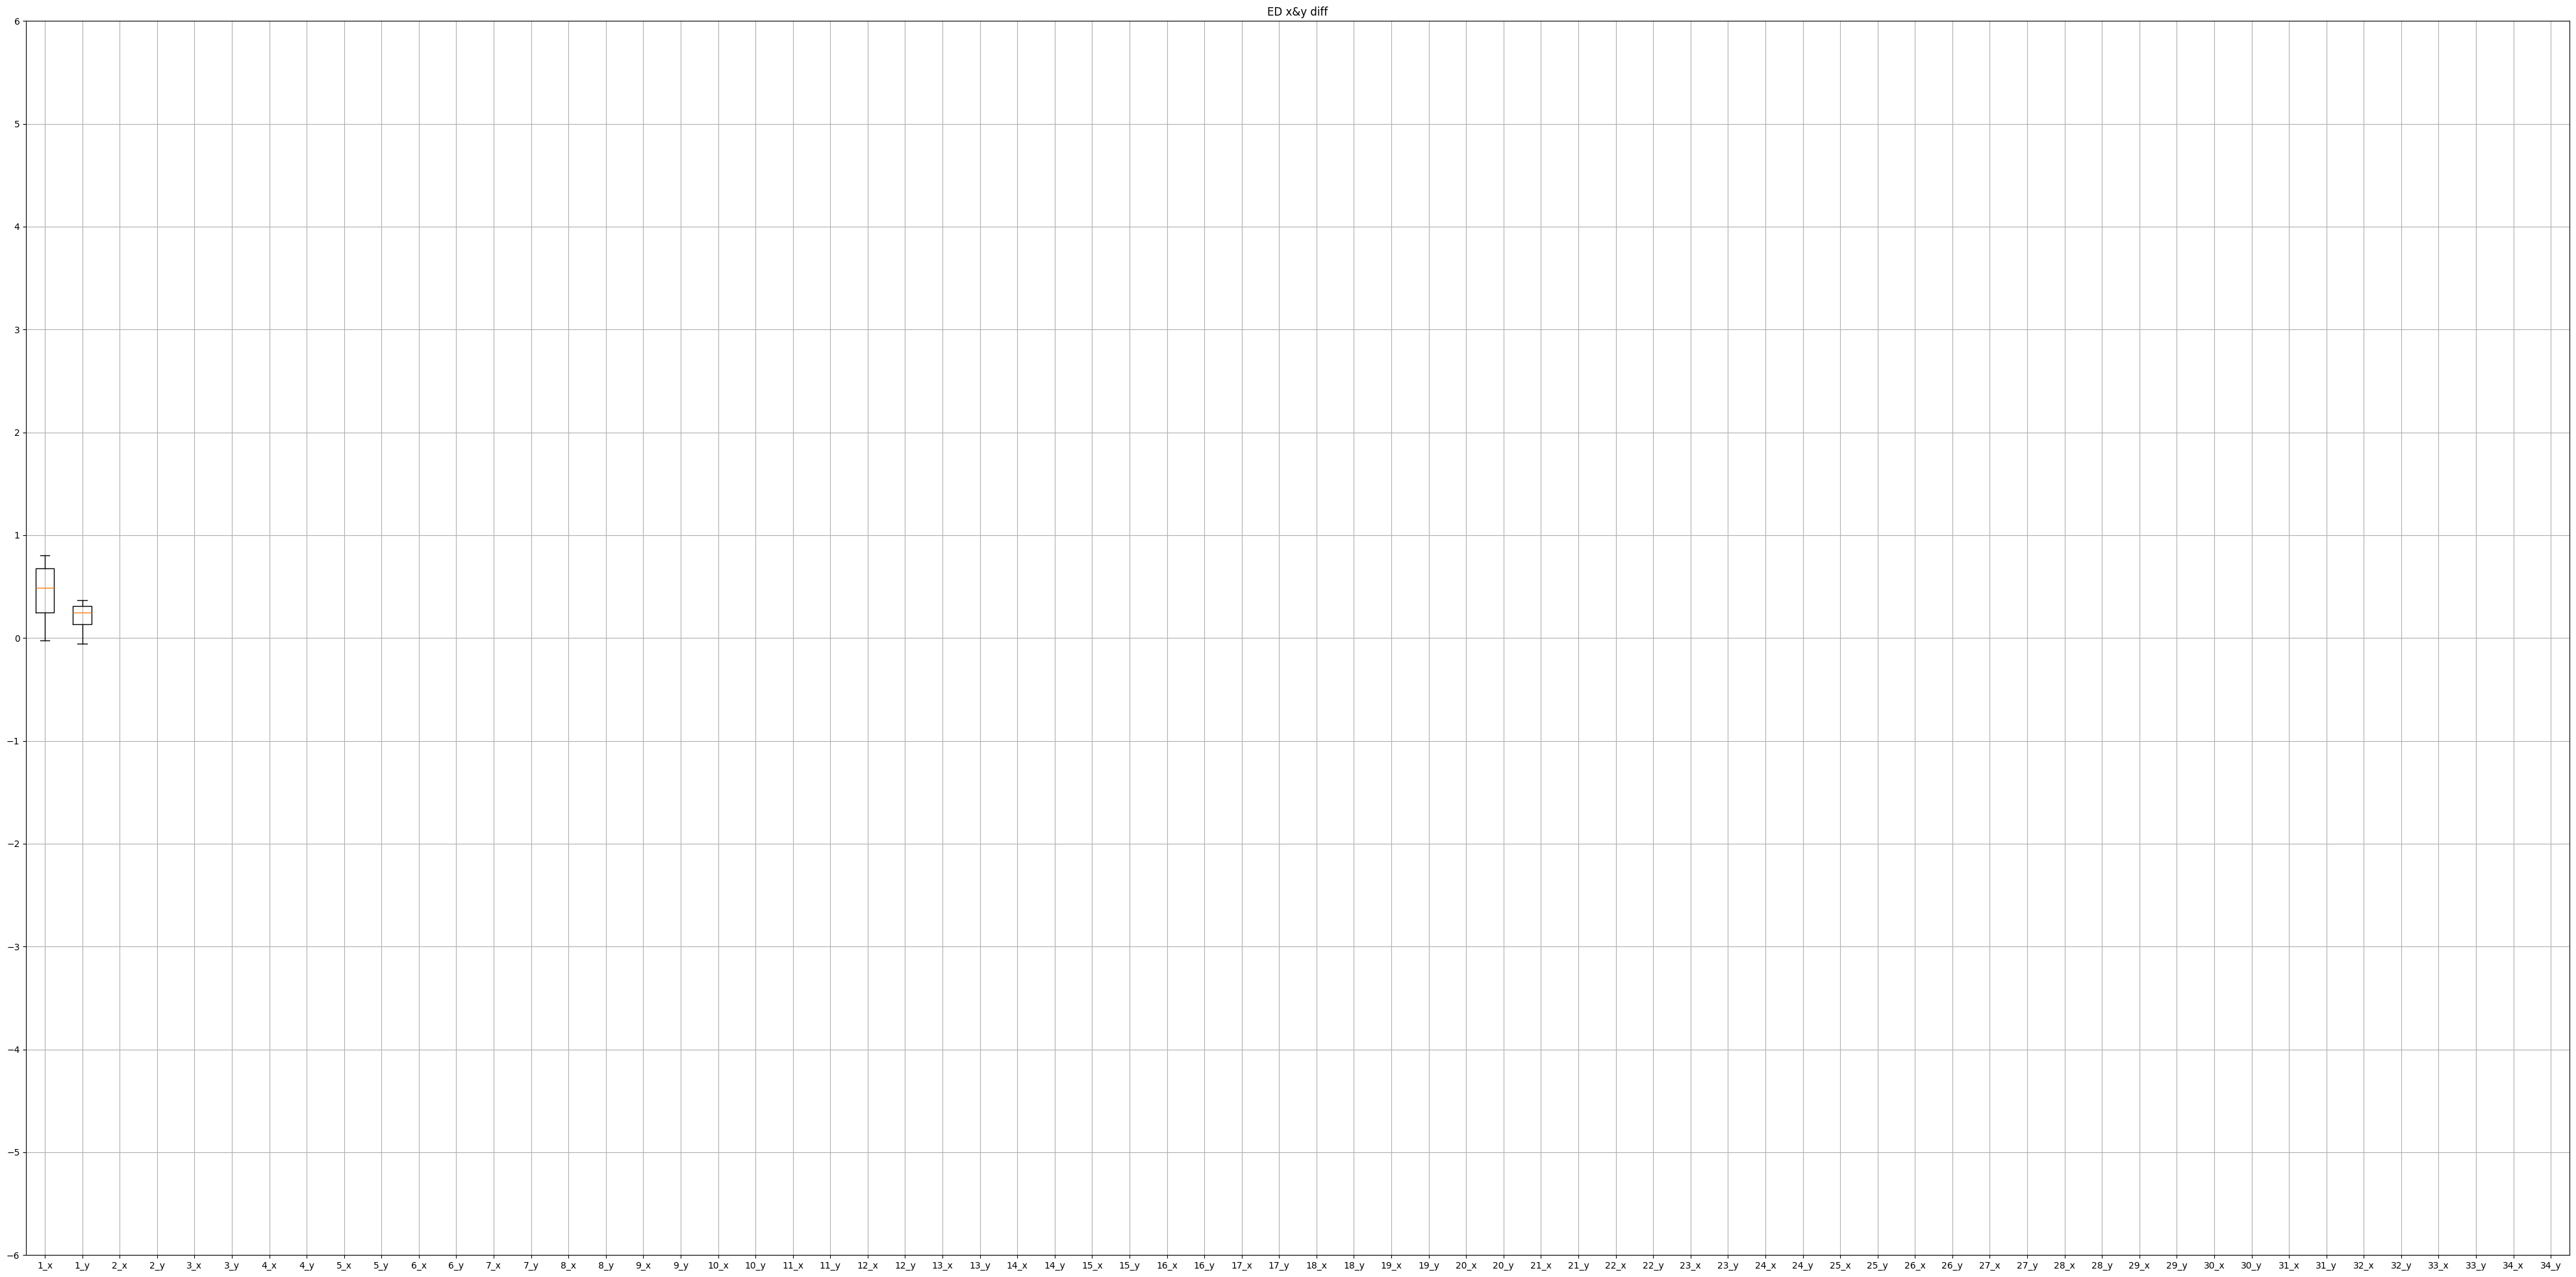

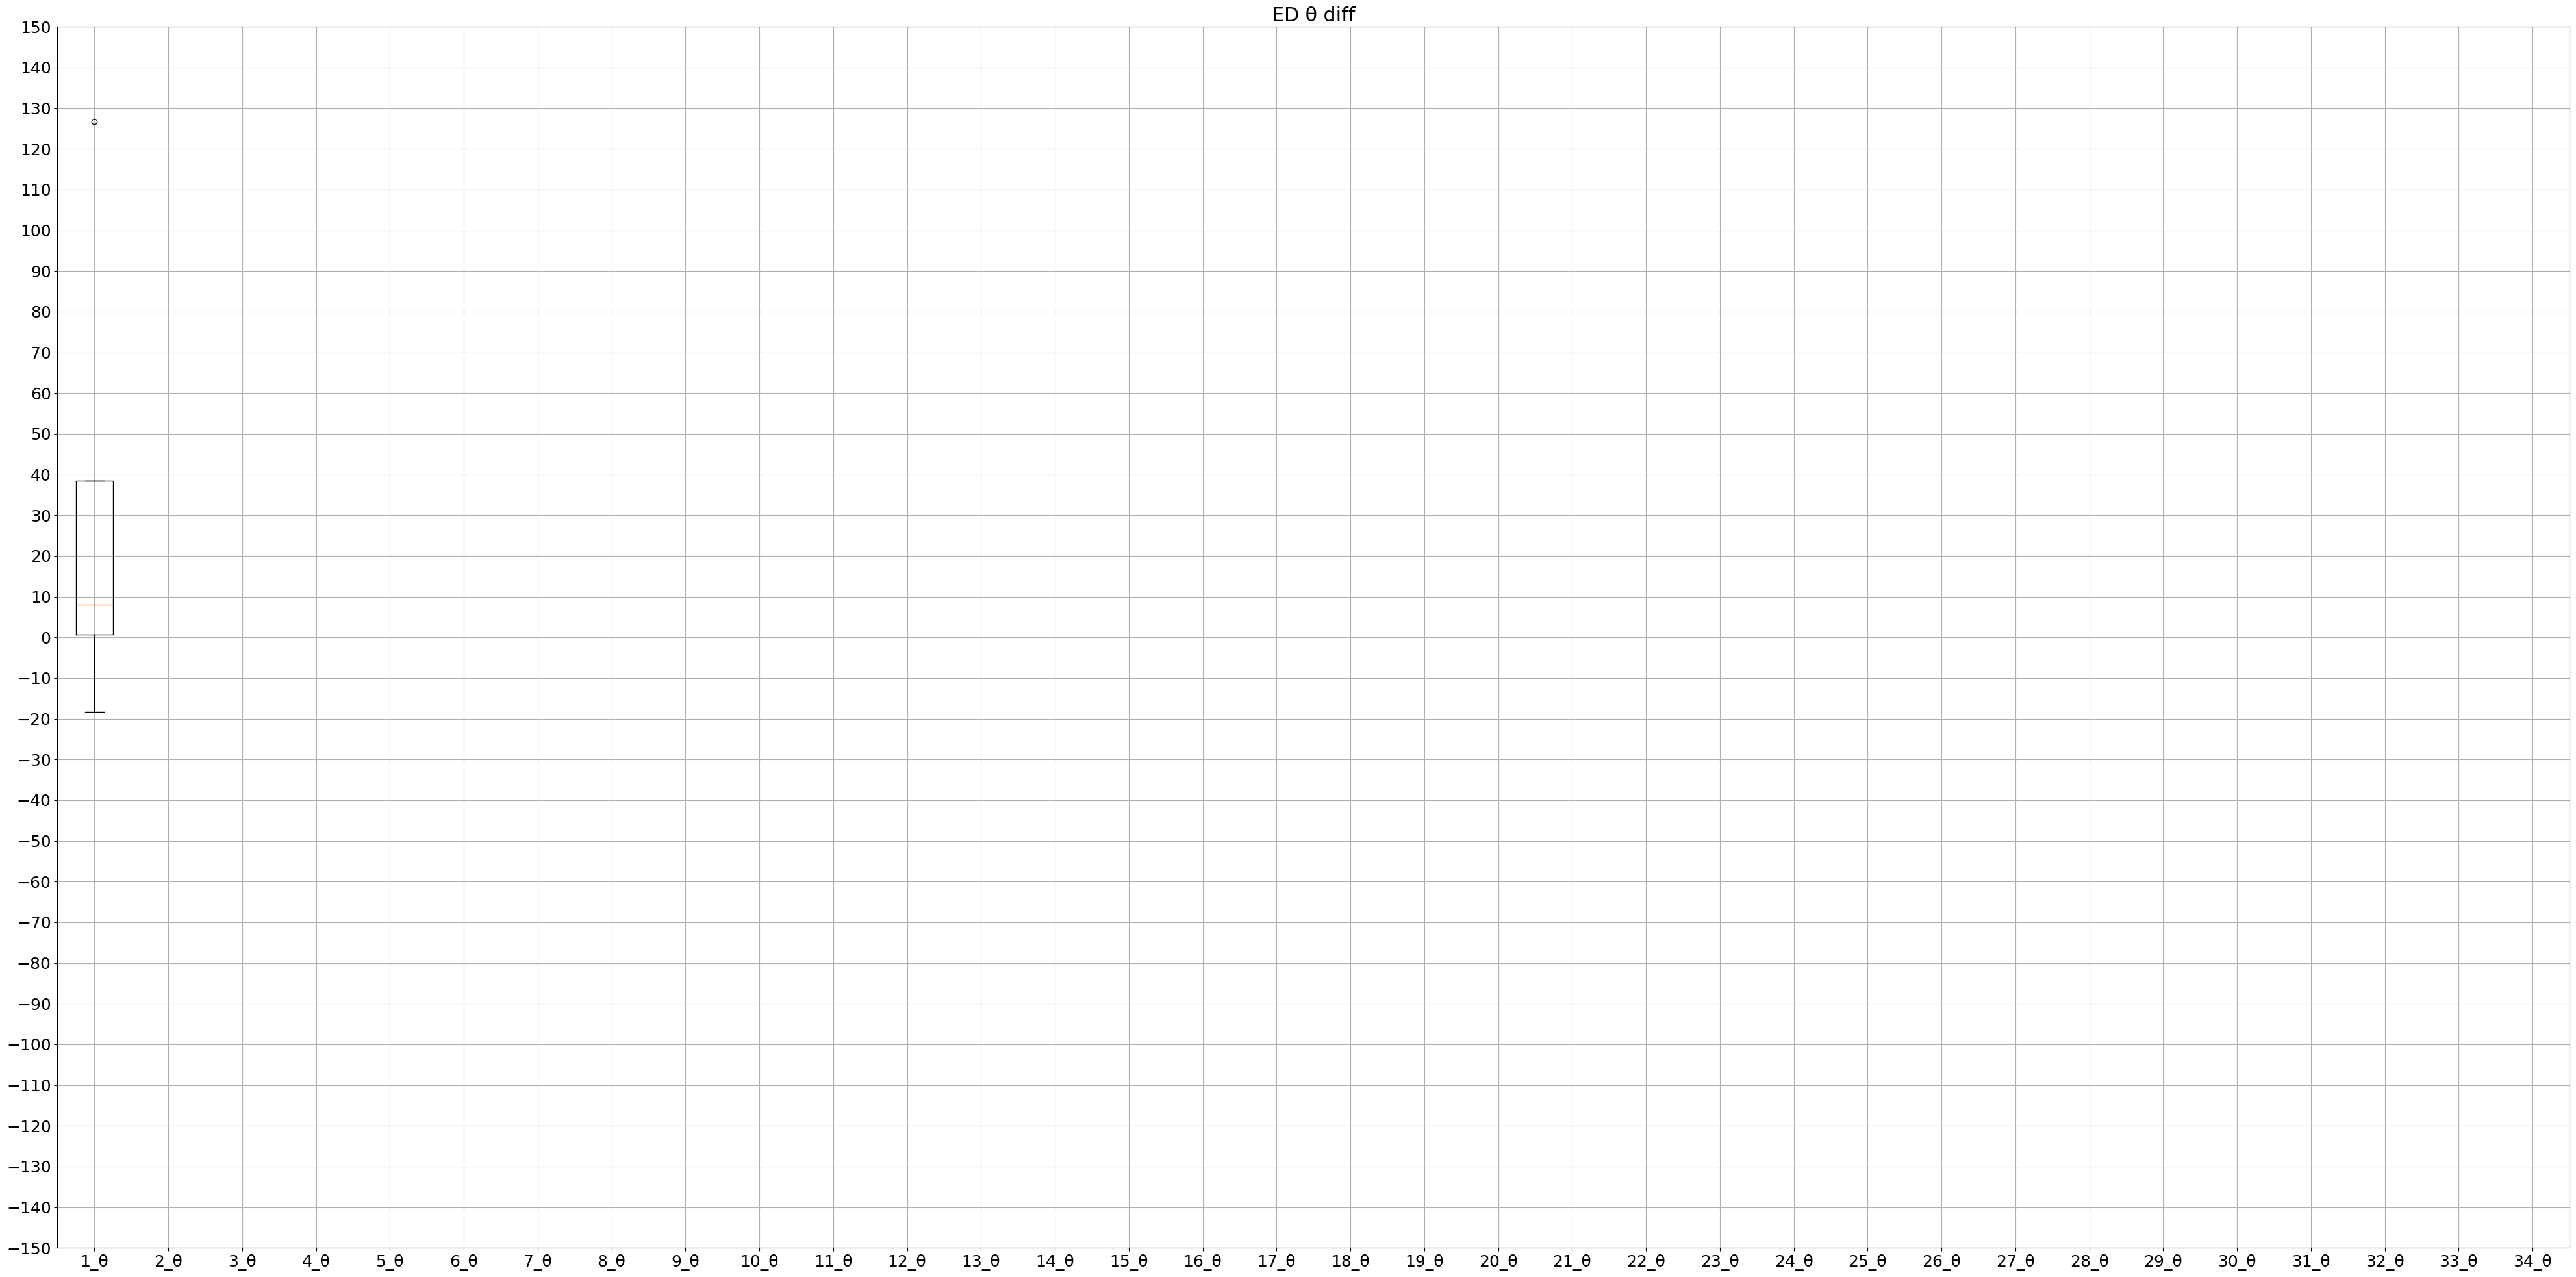

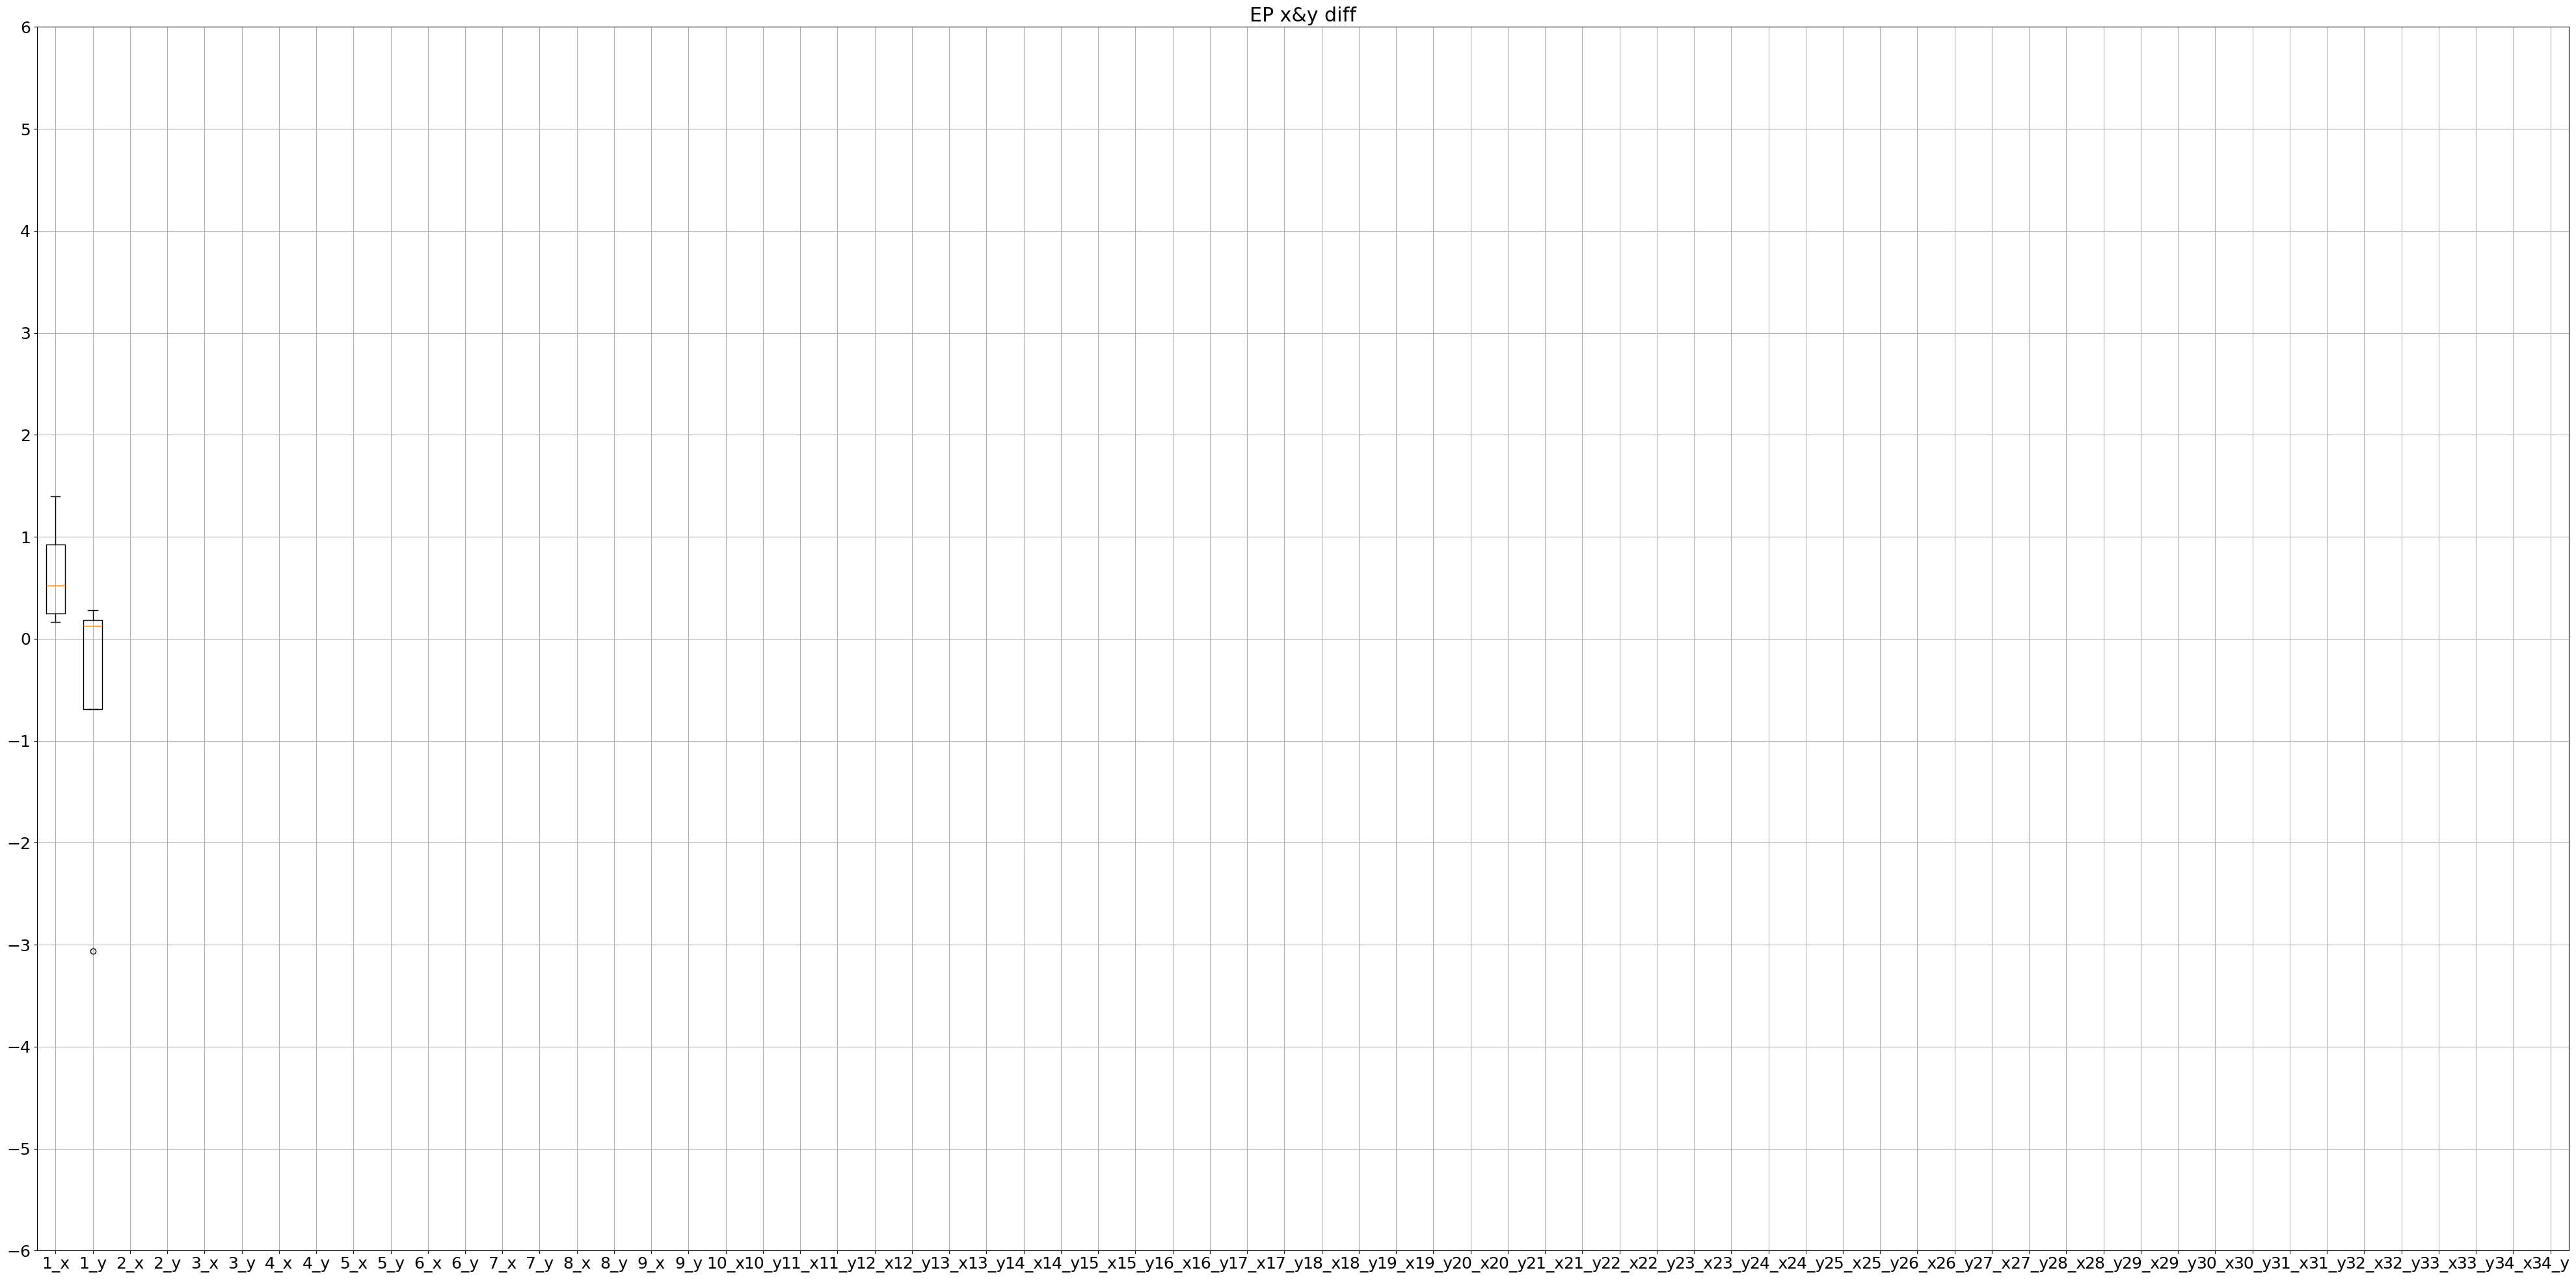

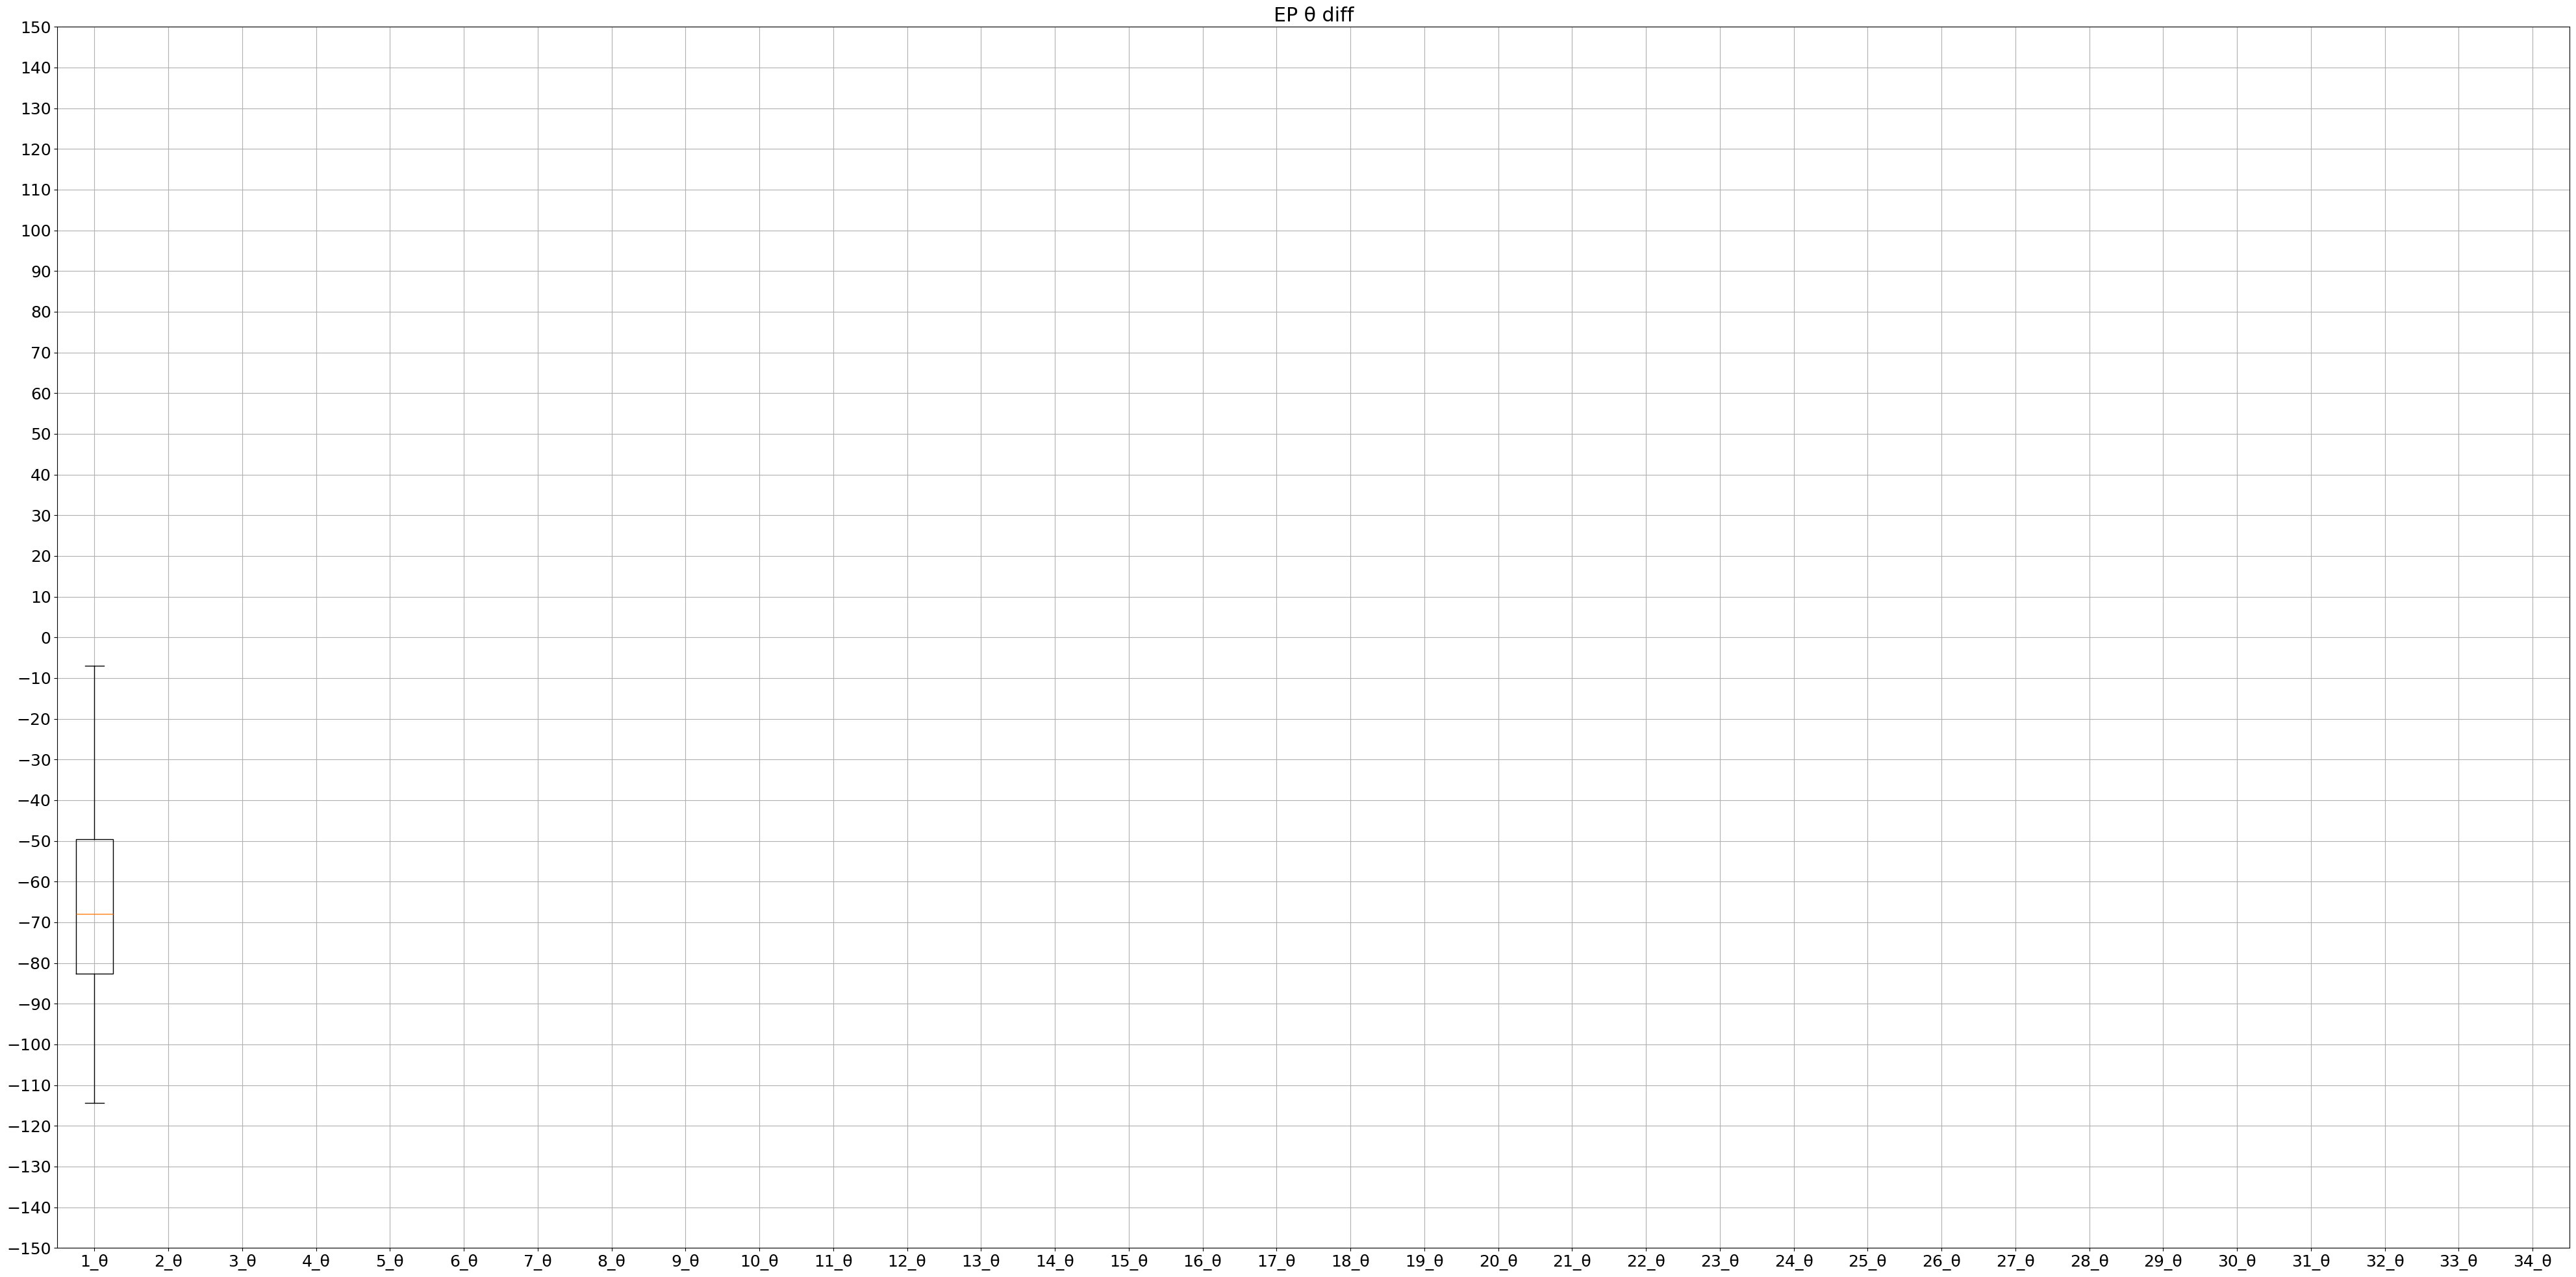

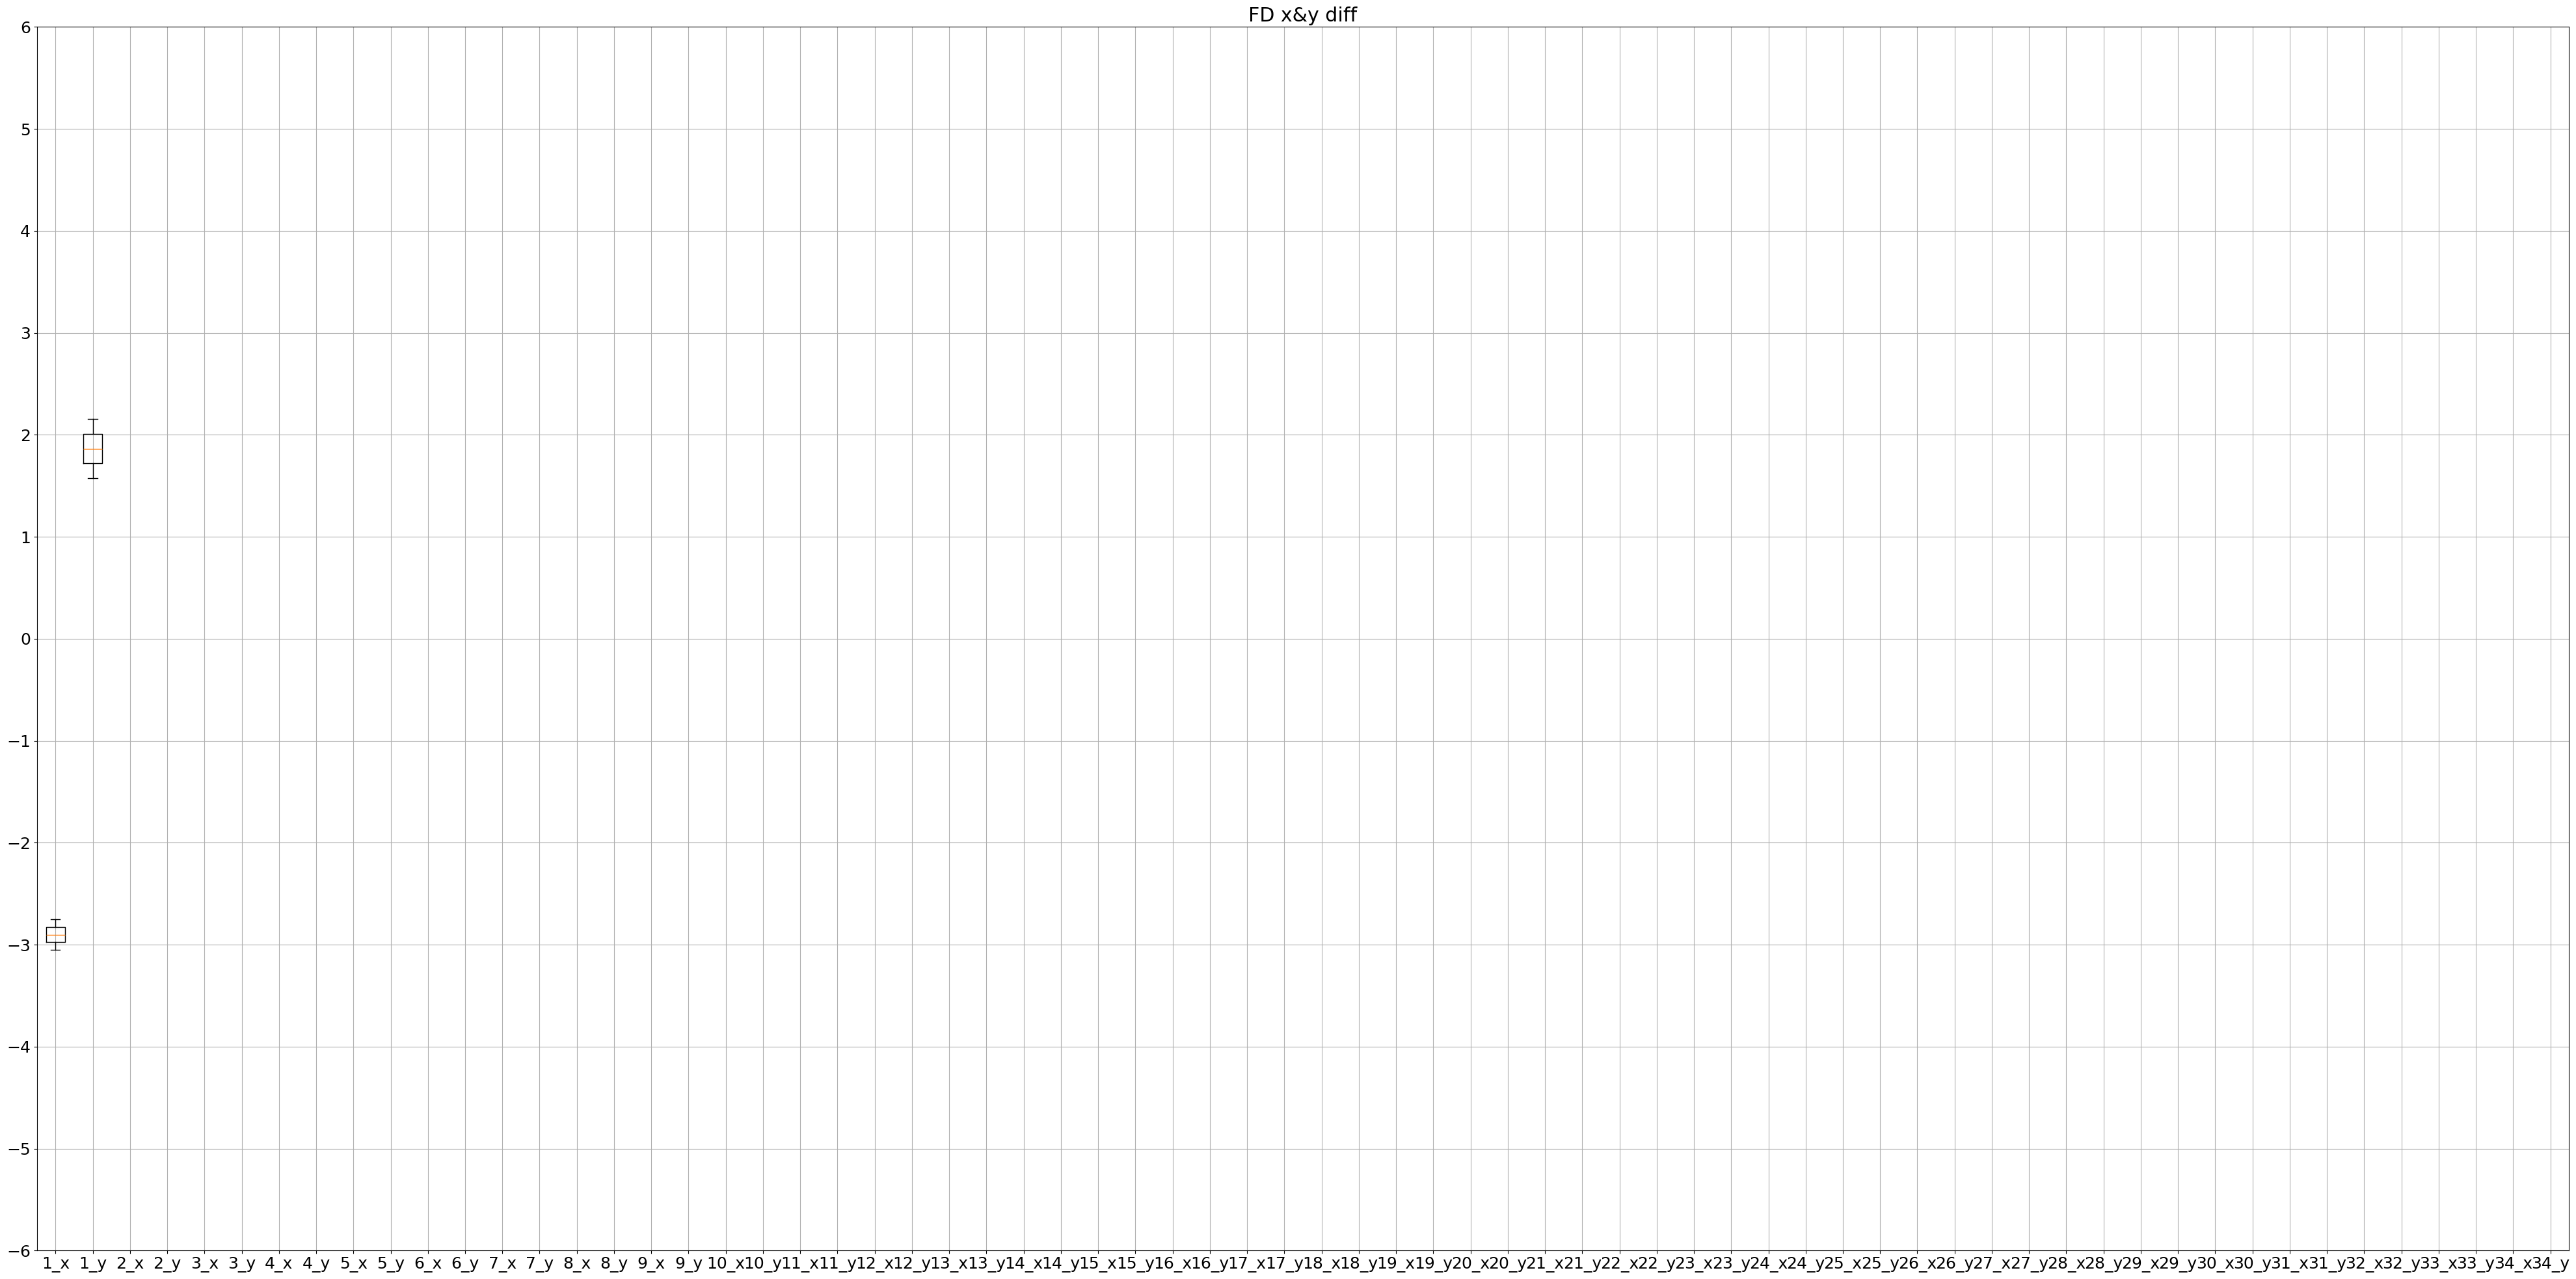

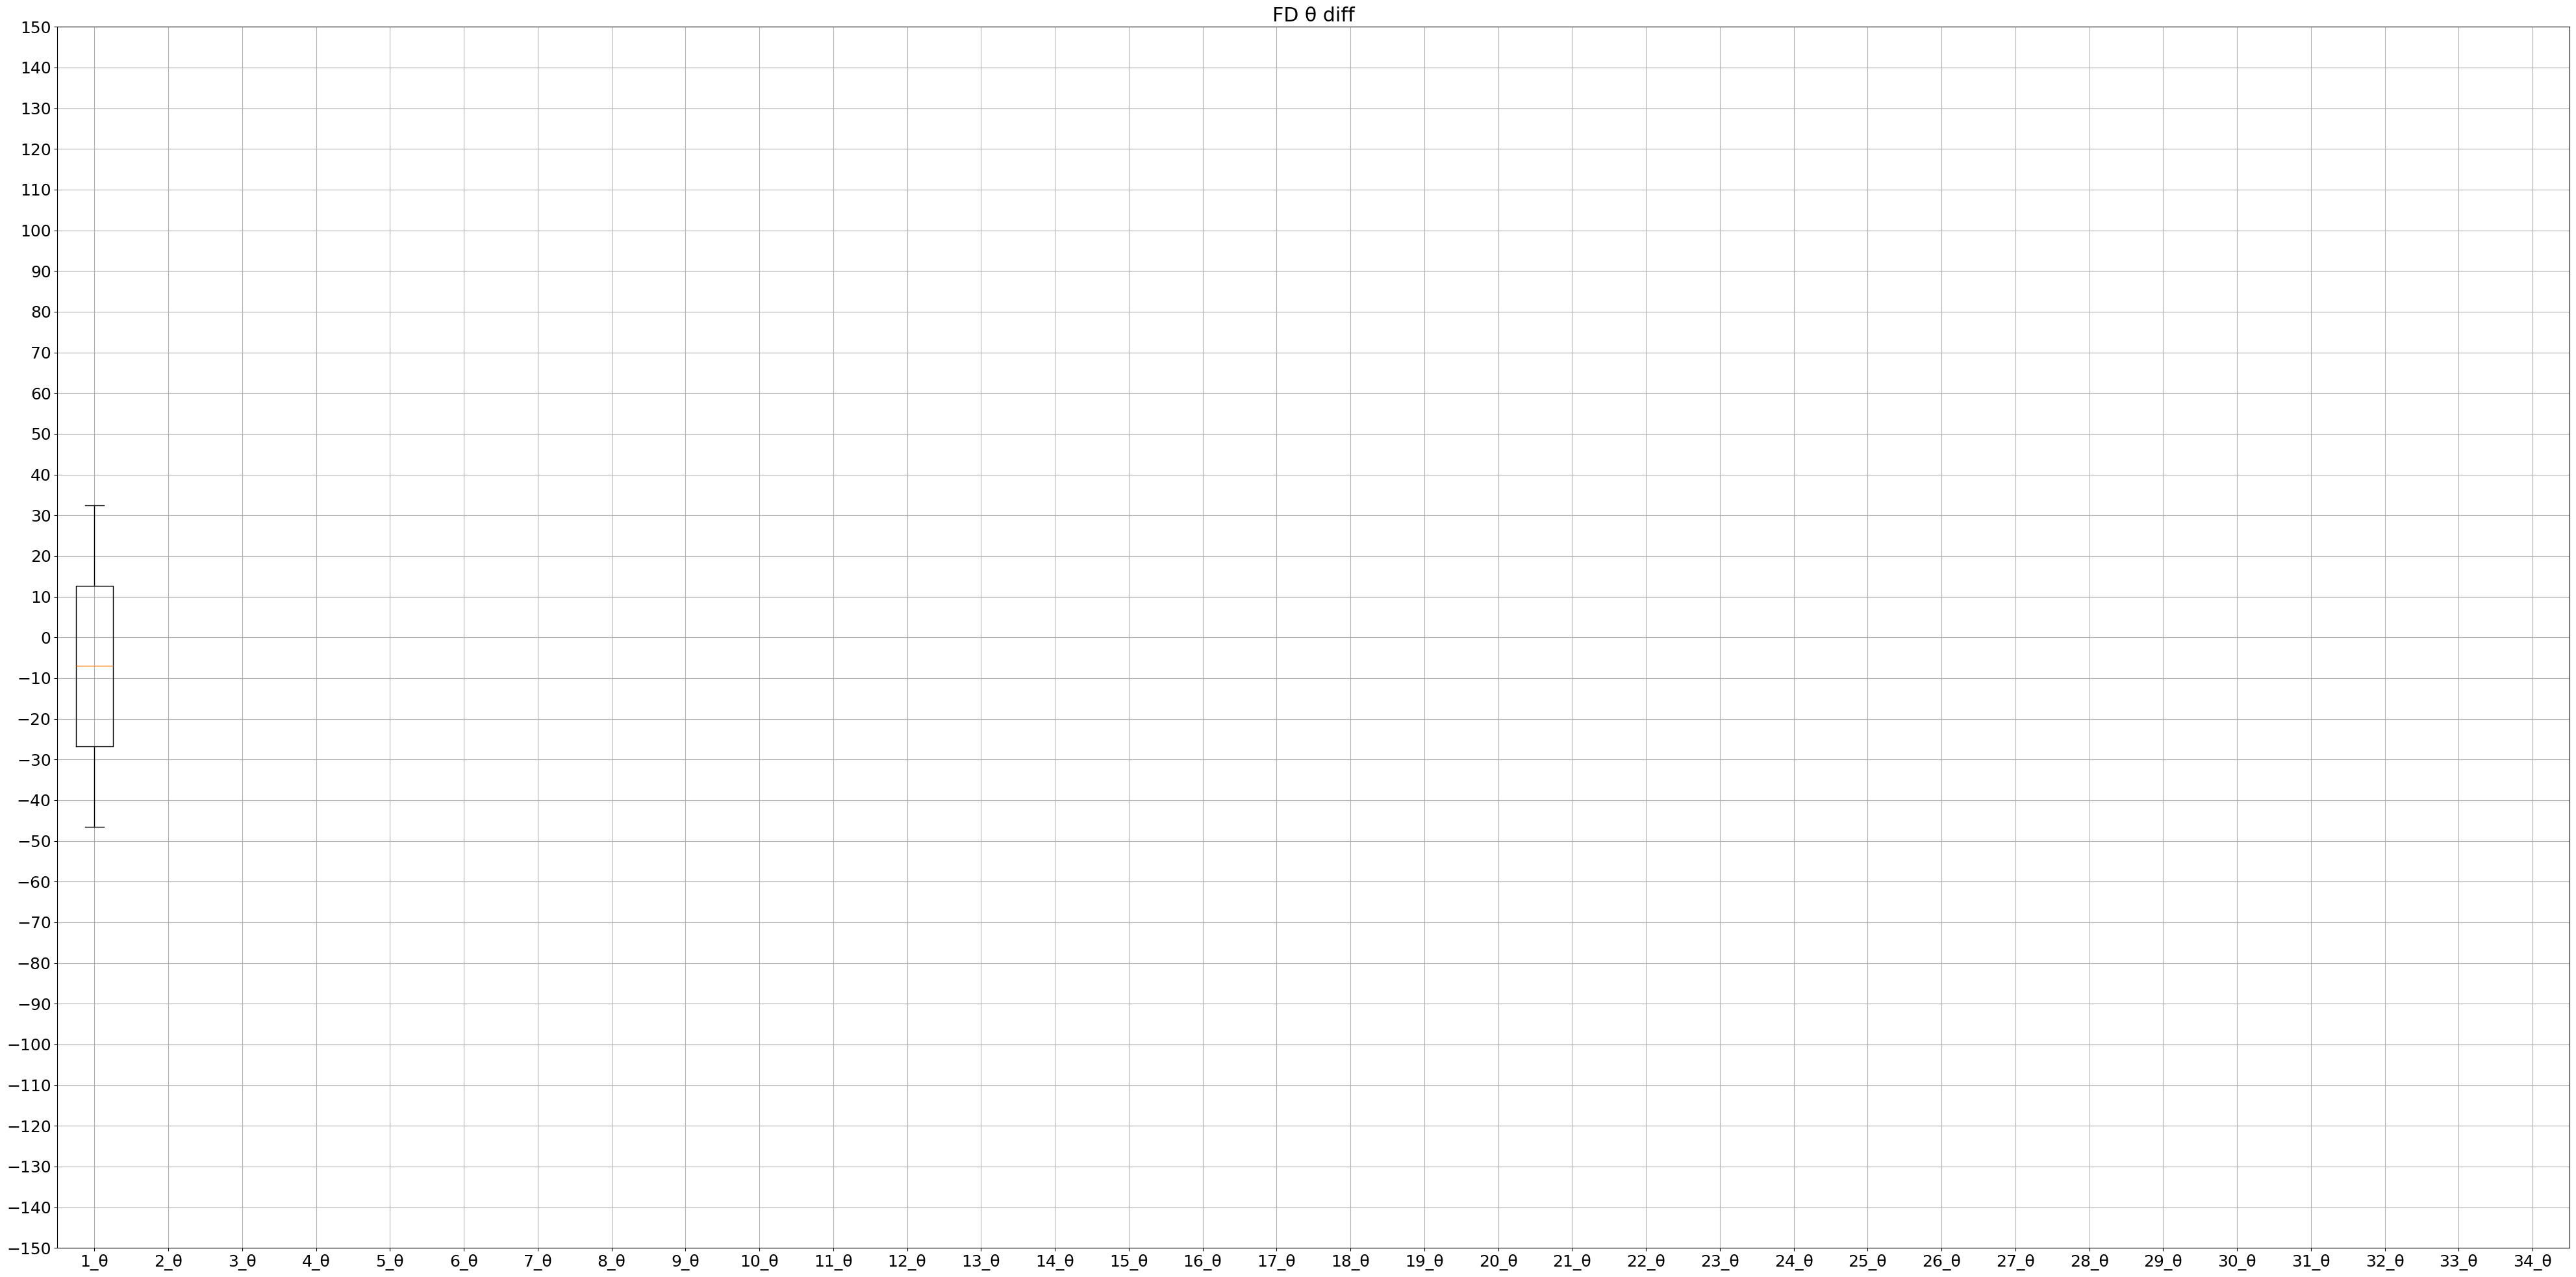

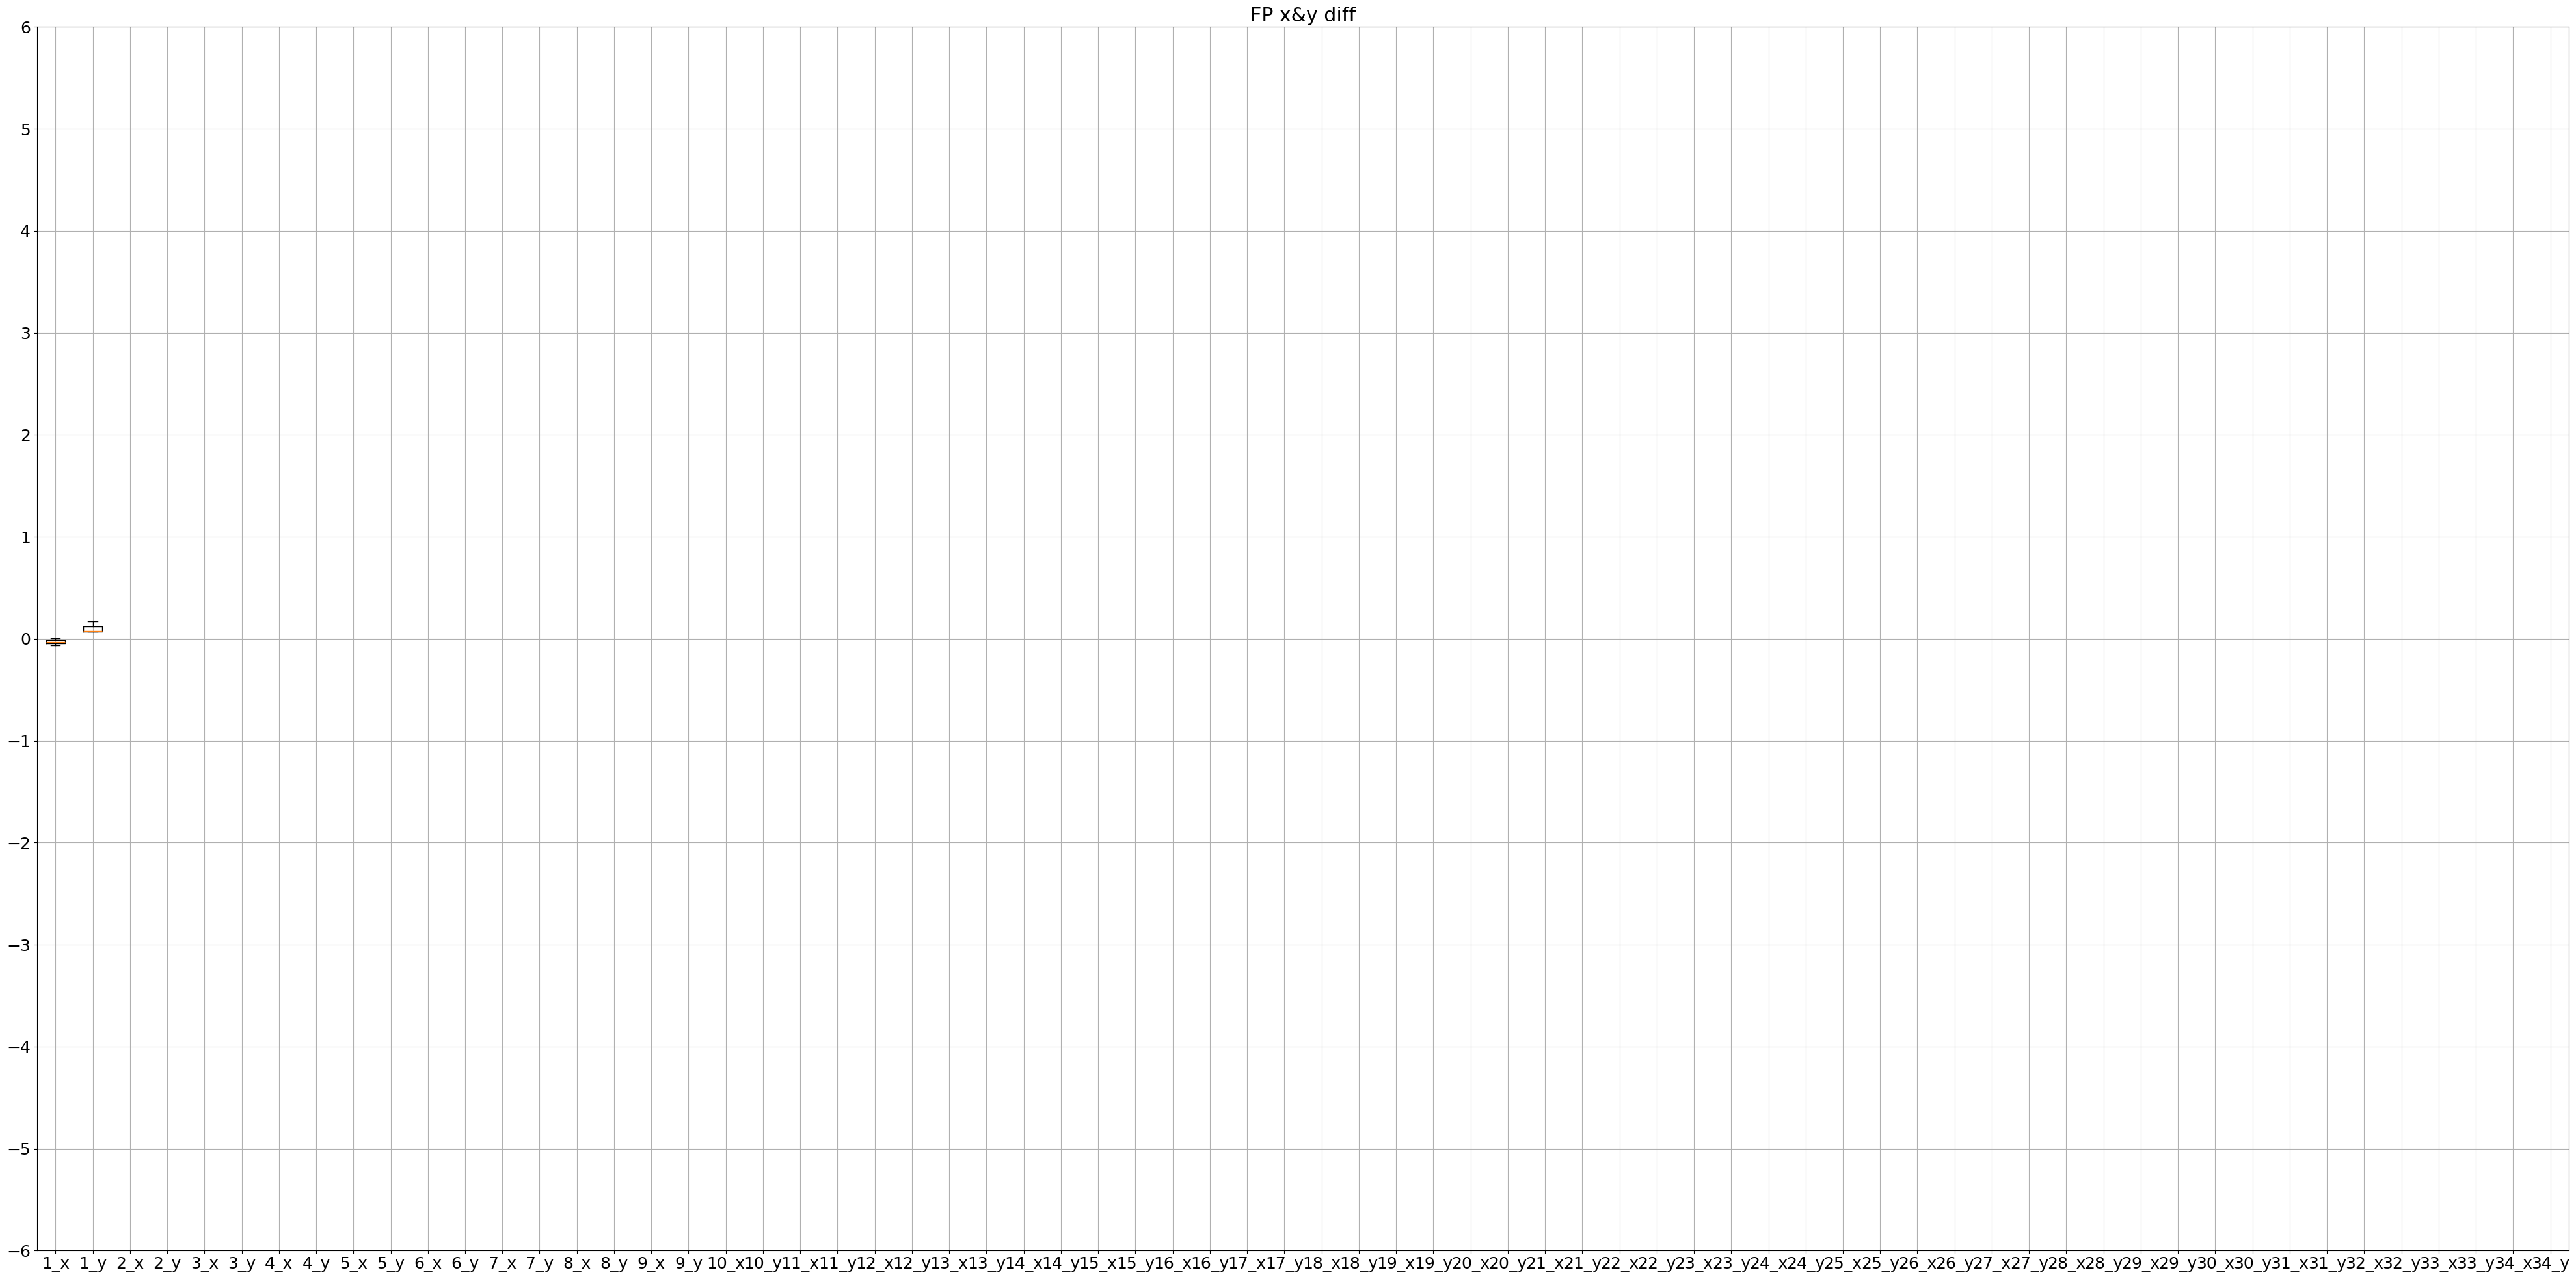

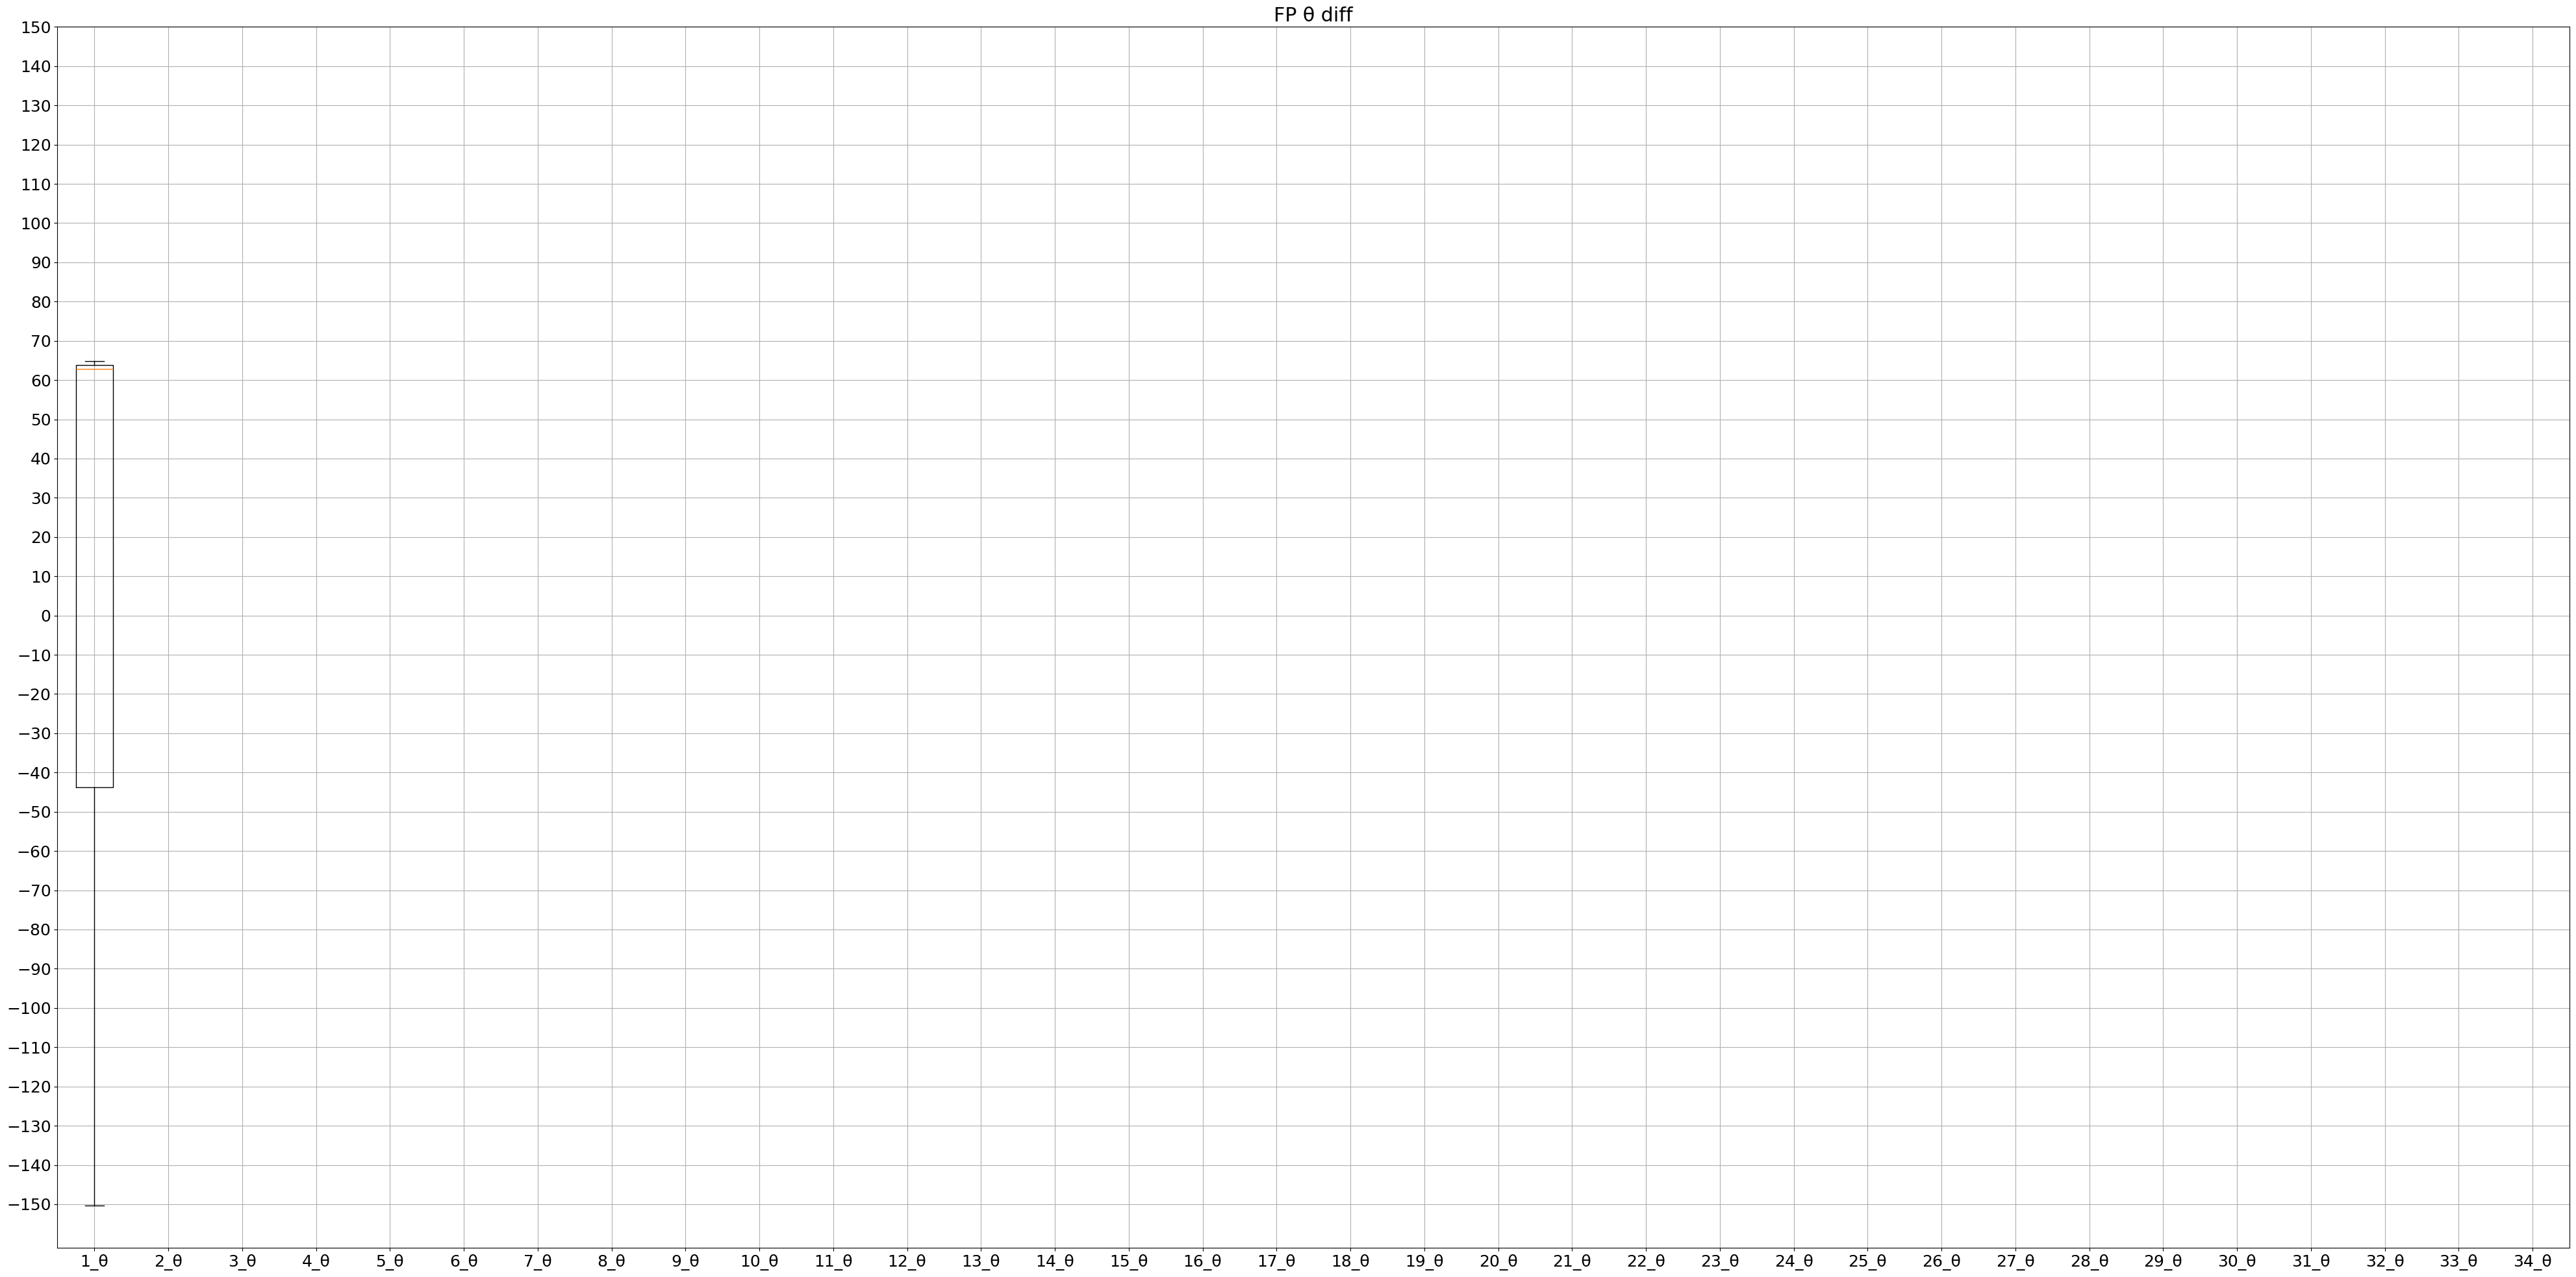

In [69]:
fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
ax.boxplot(ED_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('ED x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(ED_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('ED θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('EP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('EP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FD x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FD θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

In [430]:
x_EP_gesture

{1: [3.9834823697861856,
  0.7655725323054208,
  3.10617847342346,
  4.05349287187996,
  0.02115415804537779,
  4.334289507071547,
  -2.0264028596544827,
  0.4968693264360893,
  -5.847779801428611,
  -3.4256882912377815,
  5.088462625187774,
  -2.815297700907411,
  -0.6464783735621789,
  -0.1856303651496478],
 2: [-4.383692196949831,
  4.804497197418508,
  0.7248619611685081,
  -3.791830325561055,
  -0.04234048237382115,
  0.09624850053188716,
  4.345596361753619,
  -2.9286777577151706,
  -5.986402567666984,
  -0.1973619220428227],
 3: [-4.272417083576745,
  -1.4333028944917685,
  -1.710188106816556,
  -3.6334575541587704,
  -1.1952906307007805,
  0.46390829100145536,
  0.6186796978131253,
  0.0863139874856862,
  0.3164866657704213,
  0.2793831342879537,
  -3.0361482531842716,
  -2.659884482496575,
  0.40483640553411027,
  -2.5013905247837376,
  -2.717533002360726],
 4: [-3.44605547402925,
  0.004803654453026773,
  0.22843289959930946,
  0.4934622049706885,
  -3.1976287312558105,
  -3.

In [13]:
record_session1 = wfdb.rdrecord('pr_dataset/subject01_session1/maintenance_preprocess_sample19')
record_session2 = wfdb.rdrecord('pr_dataset/subject01_session2/maintenance_preprocess_sample19')

In [14]:
filtered_emg_ED_session1 = record_session1.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session1 = record_session1.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session1 = record_session1.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session1 = record_session1.p_signal[:,192:256] #Flexor Proximal

filtered_emg_ED_session2 = record_session2.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session2 = record_session2.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session2 = record_session2.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session2 = record_session2.p_signal[:,192:256] #Flexor Proximal

In [ ]:
ied = 2
results_df = results_df_session1
#仮想双極電極の電極間距離（cm）
a = ied

n_clusters = results_df['direction_cluster'].nunique()
cluster_colors = get_cluster_colors(n_clusters)

virtual_bipolars = []
labels = []
center_direction = []
for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
  sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
  if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
    x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
    theta = sub_df['theta_deg'].mean()
    dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale
    print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
    x1 = x - a/2*np.cos(np.radians(theta))
    y1 = y - a/2*np.sin(np.radians(theta))
    x2 = x + a/2*np.cos(np.radians(theta))
    y2 = y + a/2*np.sin(np.radians(theta))
    virtual_bipolars.append([x1, y1, x2, y2])
    labels.append(direction_cluster)
    center_direction.append([x, y, theta])
    # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
    color = cluster_colors[n]
    plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
    plt.plot(x, y, 'o', color=color,
              label=f"Center Cl {direction_cluster}" if f"Center Cl {direction_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")
# ラベル・軸
plt.xlabel("center_x")
plt.ylabel("center_y")
plt.title("2-Stage Clustering of Muscle Fiber Direction")
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

print(len(virtual_bipolars))
# return virtual_bipolars, labels, center_direction

In [ ]:
#分類器
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix

X_train = np.array(X_session1).reshape(-1,1)
y_train = np.array(y_session1).reshape(-1,1)
X_test = np.array(X_session2).reshape(-1,1)
y_test = np.array(y_session2).reshape(-1,1)

# データ分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVMモデル学習
model = SVC(kernel='rbf', probability=True, random_state=0)
model.fit(X_train, y_train)

prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
# === 各テストラベルごとに学習クラスへの平均確率を出力 ===
class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

result = []

for test_label in np.unique(y_test):
    idx = y_test.reshape(-1) == test_label
    mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
    result.append([test_label] + list(mean_prob))

# === 表形式で表示 ===
columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
df_result = pd.DataFrame(result, columns=columns)

# import seaborn as sns
# import matplotlib.pyplot as plt

print(df_result)

In [ ]:
max_train_idx = []
for i in range(np.array(result).shape[0]):
j = np.argmax(np.array(result)[i,1:])
max_train_idx.append(j)
# print(max_train_idx)
for k in set(max_train_idx):
if max_train_idx.count(k) >=2:
    idx = max_train_idx == k
    l = np.argmax(np.array(result)[idx, k+1], axis=0)
    max_test_idx = [i for i, j in enumerate(idx) if j == True]
    print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
else:
    print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')

In [343]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

In [ ]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        for k in range(n_trials):
            print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))
            print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

検出されたピーク数（条件を満たすもの）: 946


C:\Users\takeu\AppData\Local\Temp\ipykernel_8356\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


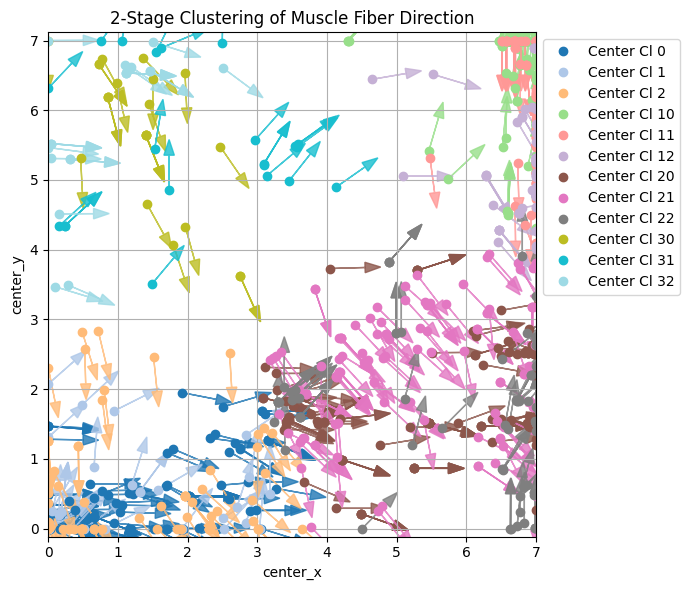

In [25]:
emg_data_session1 = filtered_emg_FD_session1
features_session1 = get_centers_directions(emg_data_session1, window_size=50, threshold=0)
results_df_session1, summary_df_session1 = clustering(features_session1)
summary_df_session1
plot_fiber(results_df_session1)
virtual_bipolars_session1, labels_session1, center_direction_session1, n_virtual_bipolars_session1 = get_virtual_bipolars(results_df_session1)
virtual_emg_session1 = get_virtual_emg(emg_data_session1, virtual_bipolars_session1)
X_session1, y_session1 = get_features(virtual_emg_session1, labels_session1)

In [16]:
summary_df_session1

cluster  center_x_mean  center_x_std  center_y_mean  center_y_std  \
0         0       5.646943      1.229951       0.940980      0.851299   
1         1       4.896573      0.670037       0.762029      0.777889   
2         2       5.664377      1.265852       0.548066      1.092759   
3        10       0.156271      0.310457       0.240048      0.534265   
4        11       0.423330      0.424788       0.408167      0.627024   
5        12       0.281492      0.413821       0.235038      0.486817   
6        20       2.390439      1.340040       4.381913      1.071542   
7        21       2.948888      1.167173       3.793571      0.928530   
8        22       2.536257      1.629225       4.757233      1.539894   
9        30       2.165125      0.721925       0.248735      0.531442   
10       31       2.236386      0.519681       0.437845      0.671107   
11       32       2.135913      0.574366       0.229696      0.447954   

    theta_deg_mean  theta_deg_std  count  
0       -73.564912      16.155850     14  
1        70.063968      19.335590     18  
2        -2.737701      15.327538     26  
3        52.363906      12.713131    107  
4       -53.157946      20.657773     50  
5        12.639763      11.781344    196  
6        58.462809      21.906058     46  
7       -82.332147      11.692042     46  
8       -18.892597      19.469370     20  
9        63.777193      18.874557    103  
10      -71.578092      15.901389     91  
11        0.477306      16.326769    141

検出されたピーク数（条件を満たすもの）: 670


C:\Users\takeu\AppData\Local\Temp\ipykernel_8356\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


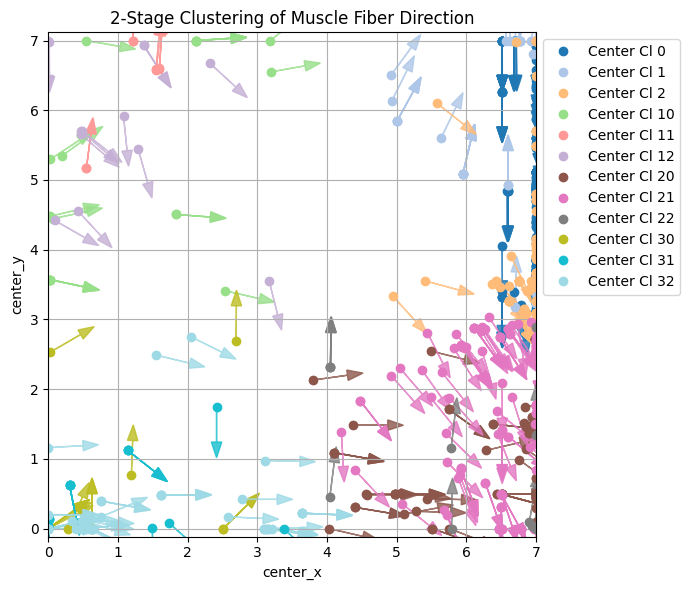

In [26]:
emg_data_session2 = filtered_emg_FD_session2
features_session2 = get_centers_directions(emg_data_session2, window_size=50, threshold=0)
results_df_session2, summary_df_session2 = clustering(features_session2)
summary_df_session2
plot_fiber(results_df_session2)
virtual_bipolars_session2, labels_session2, center_direction_session2, n_virtual_bipolars_session2 = get_virtual_bipolars(results_df_session2)
virtual_emg_session2 = get_virtual_emg(emg_data_session2, virtual_bipolars_session2)
X_session2, y_session2 = get_features(virtual_emg_session2, labels_session2)

In [18]:
summary_df_session2

cluster  center_x_mean  center_x_std  center_y_mean  center_y_std  \
0         0       1.447208      0.991705       5.278212      0.657737   
1         1       1.604446      0.865024       5.080408      1.280769   
2         2       1.078674      1.051168       5.109679      0.862641   
3        10       1.895657      1.036626       0.110035      0.265006   
4        11       2.079713      0.818067       0.316744      0.506814   
5        12       1.428540      1.009777       0.345043      0.467455   
6        20       4.538659      0.935528       3.424193      1.794956   
7        21       5.006030      1.134785       3.454777      1.646872   
8        22       5.839313      1.143316       4.003052      1.759573   
9        30       0.768018      0.754108       2.191350      0.927227   
10       31       0.742728      0.661715       2.239756      0.772510   
11       32       1.452888      1.010593       2.114192      0.618238   

    theta_deg_mean  theta_deg_std  count  
0        76.620041      15.680070     27  
1       -63.869229      15.876059     21  
2         6.724072      12.356571     32  
3        72.148228      18.112539    127  
4       -68.850123      14.605474    181  
5       -19.350123      18.120650    140  
6       -13.465207      19.750113     35  
7       -73.352762      13.262744     23  
8        56.987477      20.948718     30  
9       -11.281539      19.728473     51  
10       65.173470      20.036089     56  
11      -78.173746      14.947349     20

In [27]:
if n_virtual_bipolars_session1 >= 1 and n_virtual_bipolars_session2 >= 1:
    result, y_train, y_test = SVC_classifier(X_session1, y_session1, X_session2, y_session2)
    diff = diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2)
else:
    diff = [None]

In [28]:
diff

[None]

In [321]:
n_virtual_bipolars_session2

0

In [338]:
diffs

[{'diff': [{'train': 0,
    'test': 30,
    'x_diff': 3.8259491881339103,
    'y_diff': 3.593425777750928,
    'theta_diff': 132.32900987559782},
   {'train': 30,
    'test': 10,
    'x_diff': -0.02485568984674824,
    'y_diff': -0.05747863767190342,
    'theta_diff': 9.093665741959128}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_session2/maintenance_preprocess_sample1'],
  'electrode_place': 'ED'},
 {'diff': [{'train': 20,
    'test': 21,
    'x_diff': 3.9834823697861856,
    'y_diff': 2.5134437058997183,
    'theta_diff': -8.075040434084851},
   {'train': 30,
    'test': 31,
    'x_diff': 0.7655725323054208,
    'y_diff': 0.15258456651748098,
    'theta_diff': -6.914685794504898},
   {'train': 32,
    'test': 11,
    'x_diff': 3.10617847342346,
    'y_diff': 1.6273900614522736,
    'theta_diff': 14.760163601038961}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_s